# Proyecto de Ciencia de Datos: Modelos Predictivos para Propiedades de Materiales

#### importamos datos y librerías

In [570]:
from typing import Optional, Dict, Any, List
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    r2_score, mean_absolute_error, mean_squared_error, classification_report,
    make_scorer,
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# Modelos - clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Modelos - regresión
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# XGBoost opcional
try:
    from xgboost import XGBClassifier, XGBRegressor  # type: ignore
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    XGBClassifier = None  # type: ignore
    XGBRegressor = None  # type: ignore

from sklearn.metrics import confusion_matrix

# CatBoost opcional (GPU)
try:
    from catboost import CatBoostClassifier, Pool  # type: ignore
    HAS_CATBOOST = True
except Exception:
    HAS_CATBOOST = False
    CatBoostClassifier = None  # type: ignore
    Pool = None  # type: ignore

from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay


In [571]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



path = r'C:\Users\sevas\materials_project_dataset100k.csv'
data = pd.read_csv(path)


## Limpiamos los datos nulos o que no varian

In [572]:
# quitamos columnas que tengan mas del 50% de datos faltantes
data = data.dropna(thresh=len(data)*0.5, axis=1)
# quitamos filas que tenga valore repetidos varianza 0
data = data.loc[:, data.nunique() > 1]
#separar variables numericas y categoricas y boleanas
numericas = data.select_dtypes(include=['number'])
categoricas = data.select_dtypes(include=['object'])
booleanas = data.select_dtypes(include=['bool'])


# Histogramas de variables numericas

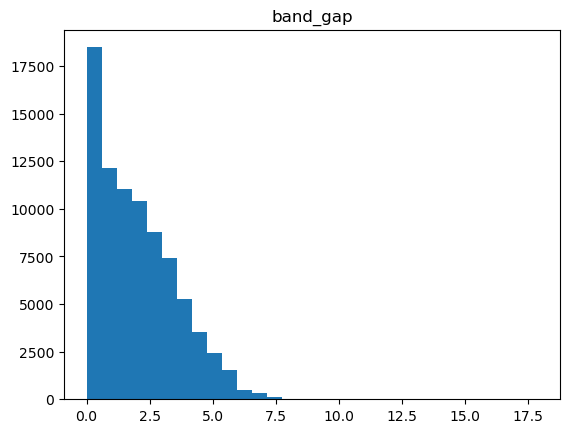

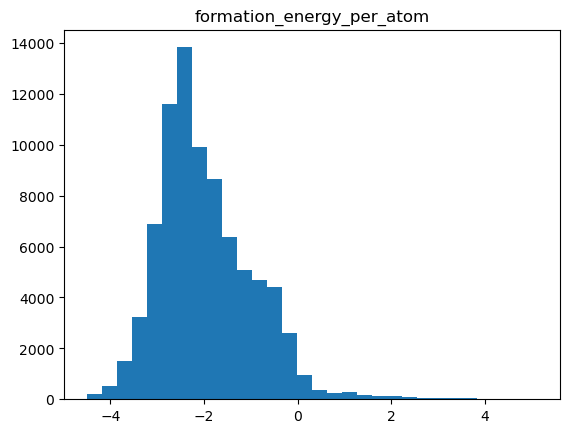

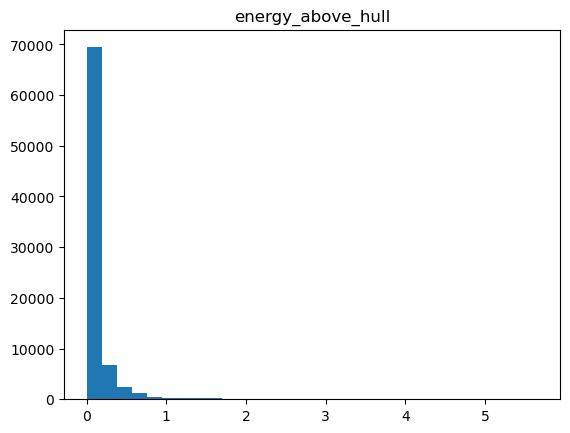

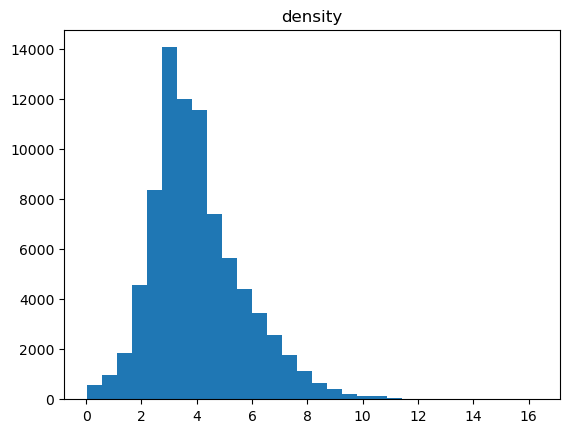

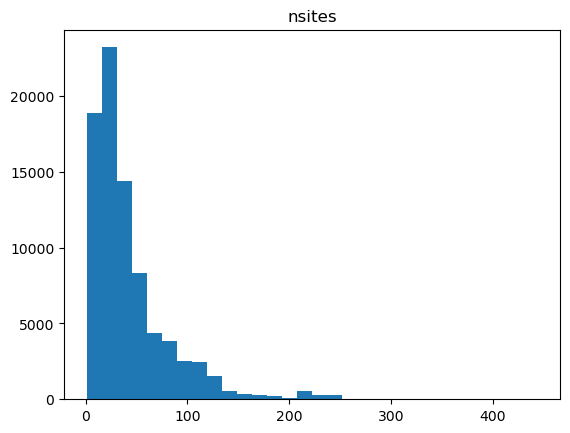

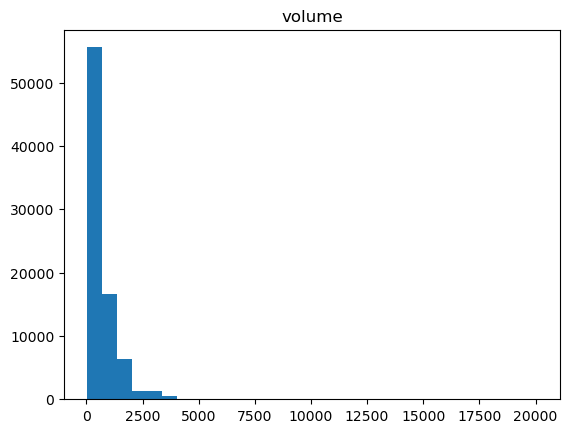

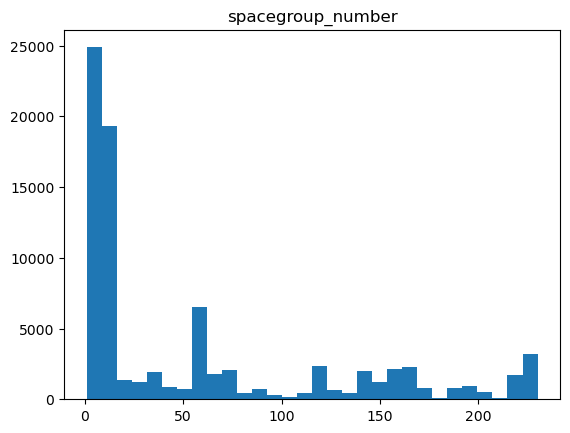

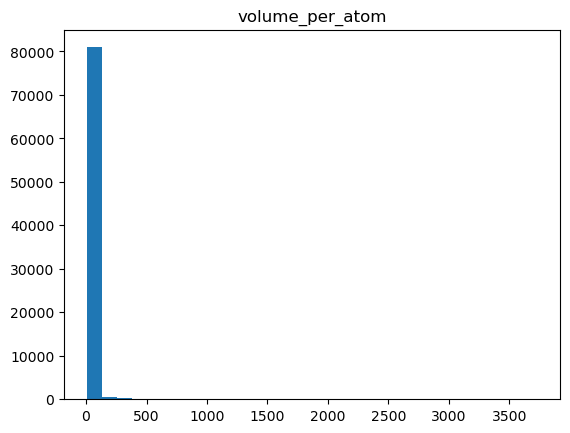

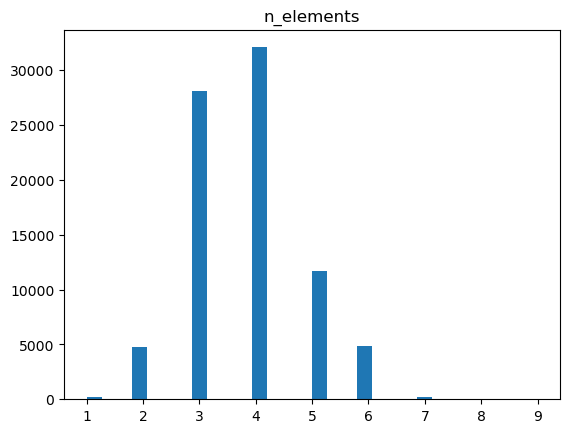

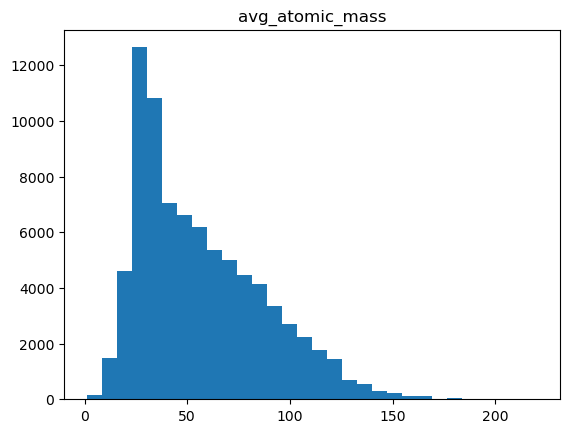

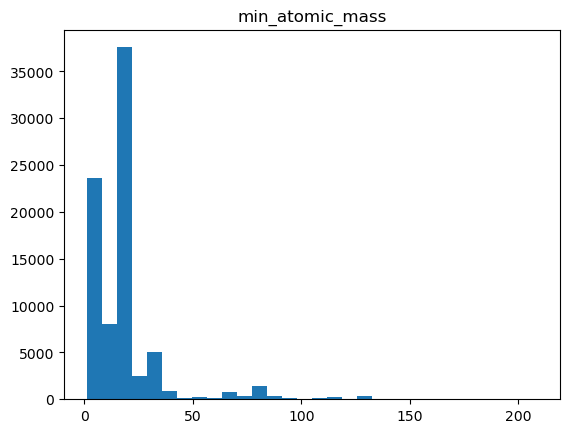

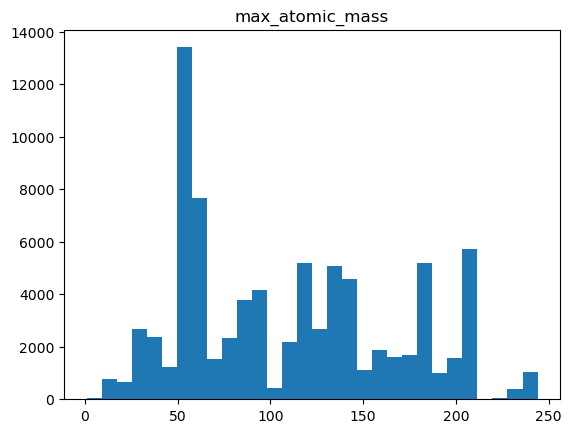

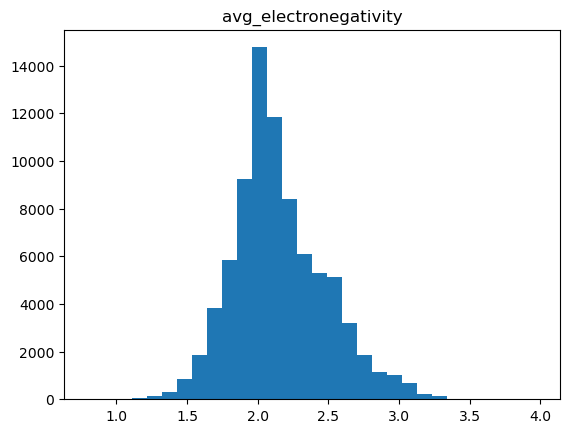

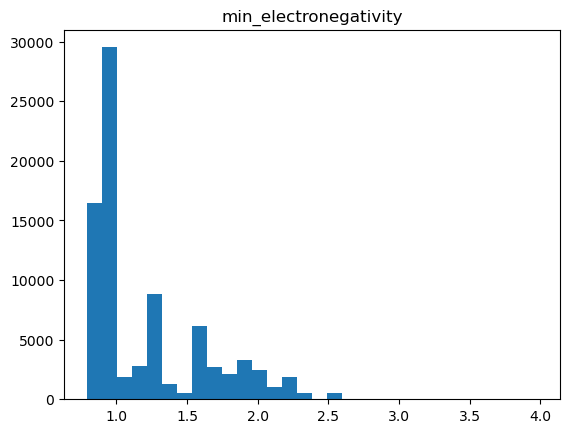

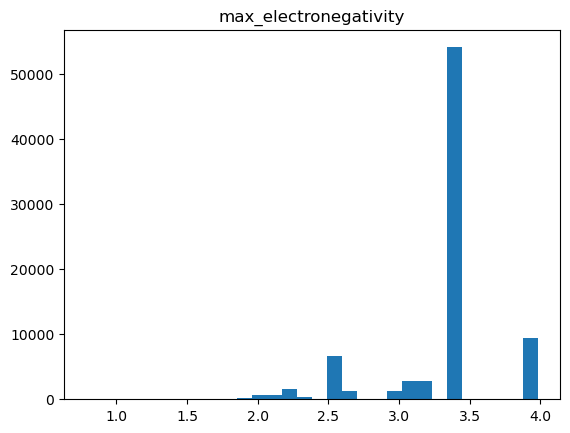

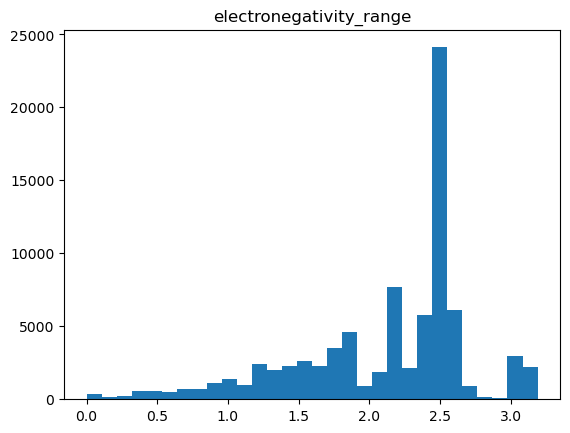

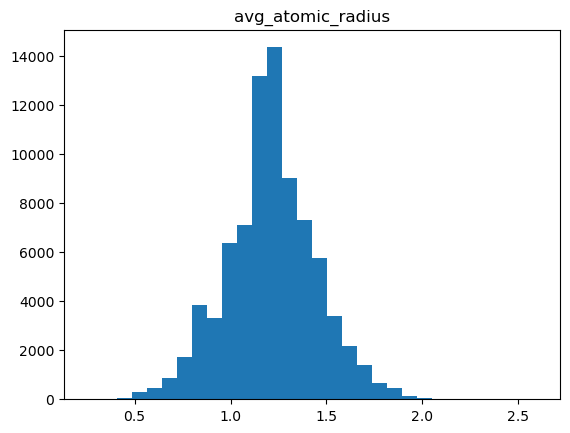

In [573]:
#histogramas de todas las variables numericas

for col in numericas.columns:
    plt.hist(numericas[col], bins=30)
    plt.title(col)
    plt.show()

##### miramos volumen_per_atomo ya que parece muy rara

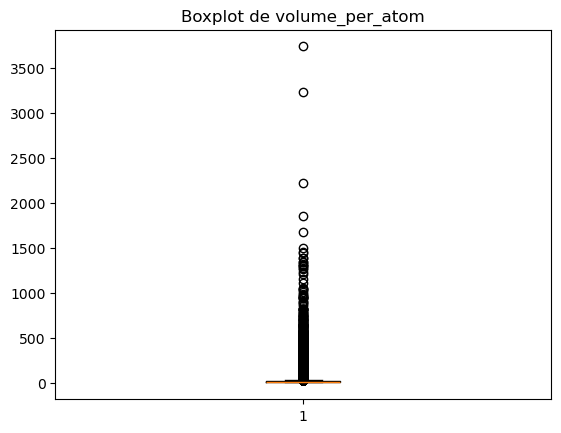

In [574]:
# grafica de bigotes para volumen_per_atomo
plt.boxplot(numericas['volume_per_atom'].dropna())
plt.title('Boxplot de volume_per_atom')
plt.show()

In [575]:
numericas[['electronegativity_range','avg_electronegativity','min_electronegativity','max_electronegativity']].describe()

electronegativity_range  avg_electronegativity  min_electronegativity  \
count             81996.000000           81989.000000           81989.000000   
mean                  2.111300               2.152604               1.216927   
std                   0.616776               0.330784               0.420568   
min                   0.000000               0.790000               0.790000   
25%                   1.770000               1.943333               0.930000   
50%                   2.340000               2.100000               0.980000   
75%                   2.510000               2.350000               1.540000   
max                   3.190000               3.980000               3.980000   

       max_electronegativity  
count           81989.000000  
mean                3.328407  
std                 0.431541  
min                 0.790000  
25%                 3.440000  
50%                 3.440000  
75%                 3.440000  
max                 3.980000

### parece ser que  min_electronegativity y max_electronegativity estan dentro de los valores de avg_electronegativity y electronegativity_range, analazaremos mas estas variables y veremos si quitarlas ya que son redundantes

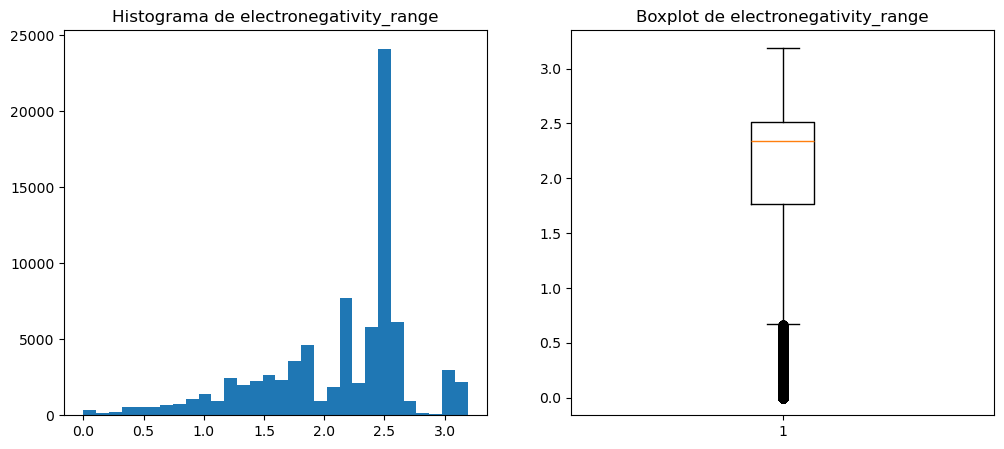

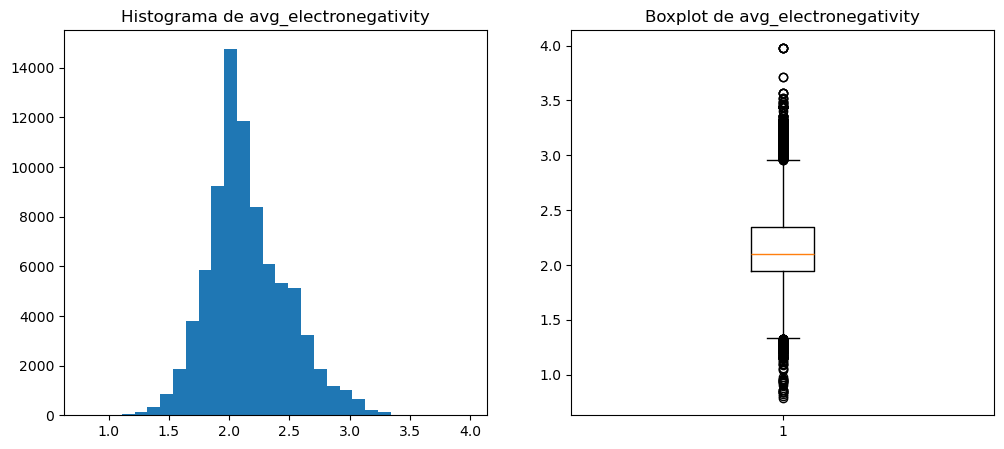

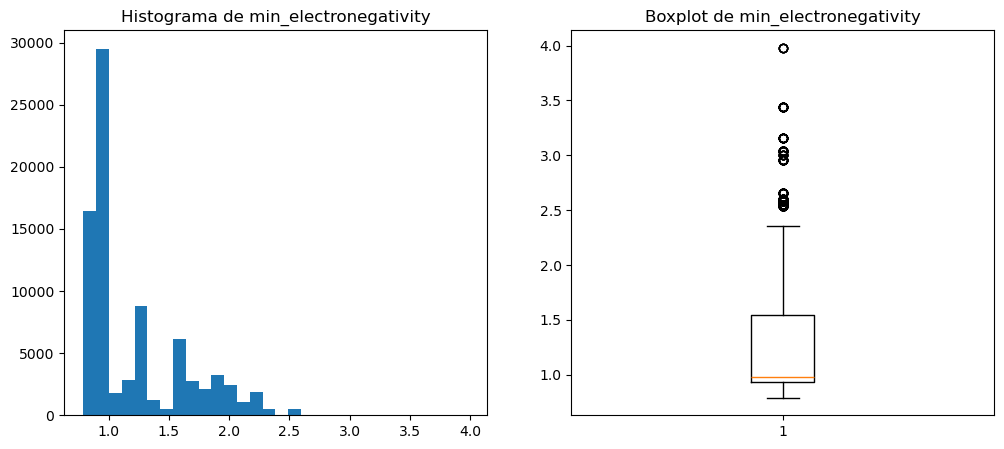

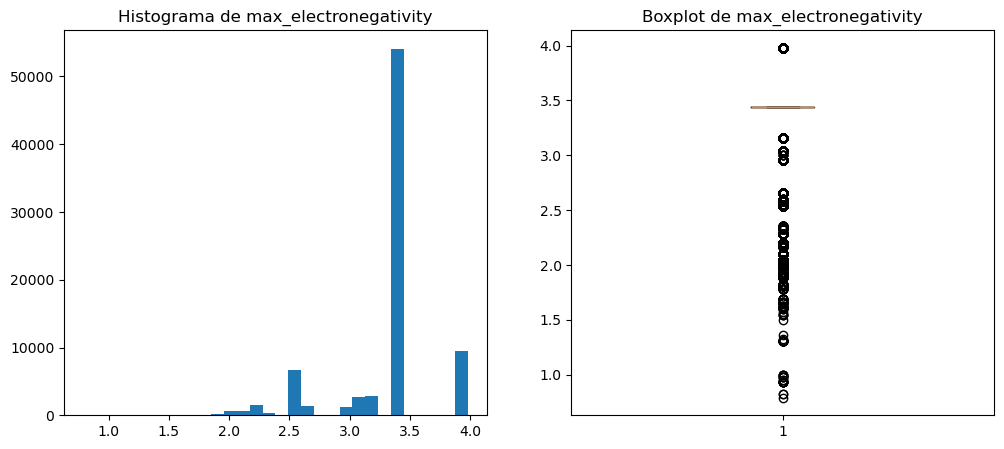

In [576]:
# histograma,boxplot de data[['electronegativity_range','avg_electronegativity','min_electronegativity','max_electronegativity']]
for col in ['electronegativity_range','avg_electronegativity','min_electronegativity','max_electronegativity']:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist(data[col].dropna(), bins=30)
    plt.title(f'Histograma de {col}')
    
    plt.subplot(1,2,2)
    plt.boxplot(data[col].dropna())
    plt.title(f'Boxplot de {col}')
    
    plt.show()

### Eliminamos min_electronegativity y max_electronegativity ya que son redundantes y no aportan informacion nueva

In [577]:
# eliminamos min_electronegativity y max_electronegativity ya que son redundantes y no aportan informacion nueva de numericas
numericas = numericas.drop(columns=['min_electronegativity','max_electronegativity'])

### muy rara puede ser que no nos sirva lo tendremos encuenta para luego

#### Tranforno min y max de la masa para ver si hay alguna relacion con avg

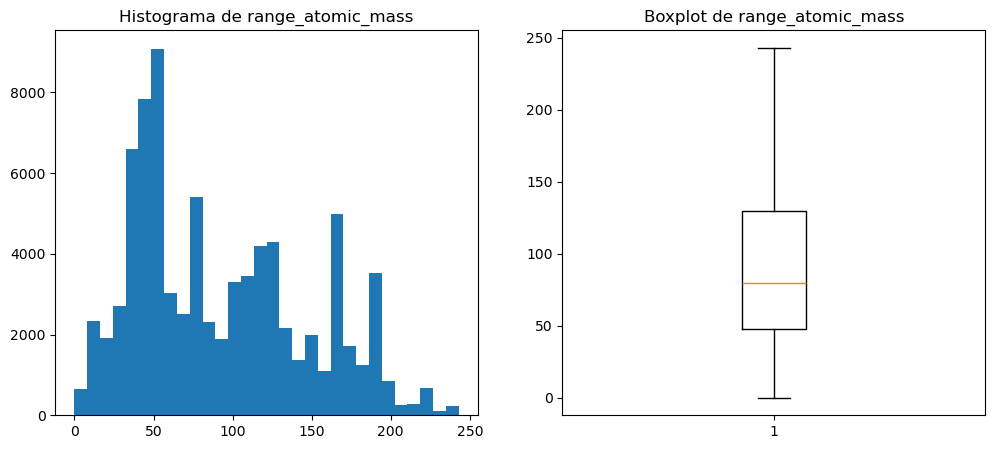

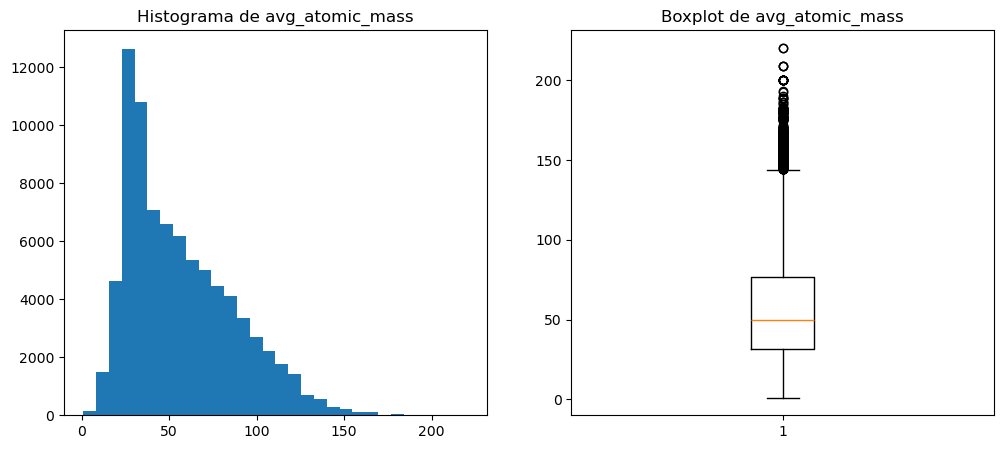

In [578]:
# crea una nueva columna en numericas donde restes max_atomic_mass              a min_atomic_mass
numericas['range_atomic_mass'] = numericas['max_atomic_mass'] - numericas['min_atomic_mass']
numericas[['range_atomic_mass','avg_atomic_mass']].describe()
# haz un histograma y boxplot de range_atomic_mass y avg_atomic_mass
for col in ['range_atomic_mass','avg_atomic_mass']:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist(numericas[col].dropna(), bins=30)
    plt.title(f'Histograma de {col}')
    
    plt.subplot(1,2,2)
    plt.boxplot(numericas[col].dropna())
    plt.title(f'Boxplot de {col}')
    
    plt.show()

In [579]:
numericas[['range_atomic_mass','avg_atomic_mass']].describe()

range_atomic_mass  avg_atomic_mass
count       81998.000000     81998.000000
mean           92.876564        56.596222
std            54.591792        30.658035
min             0.000000         1.007940
25%            47.997045        31.397822
50%            79.940600        49.863658
75%           129.461700        76.510053
max           242.992060       220.509230

In [580]:
# creame un lista para yo ir metiendo las variables que me parecen raras
raras = []
raras.append('volume_per_atom')

In [581]:
# si hay algun valor nulo en numericas lo rellenamos con la media
for col in numericas.columns:
    if numericas[col].isnull().sum() > 0:
        numericas[col] = numericas[col].fillna(numericas[col].mean())

numericas.isnull().sum()


band_gap                     0
formation_energy_per_atom    0
energy_above_hull            0
density                      0
nsites                       0
volume                       0
spacegroup_number            0
volume_per_atom              0
n_elements                   0
avg_atomic_mass              0
min_atomic_mass              0
max_atomic_mass              0
avg_electronegativity        0
electronegativity_range      0
avg_atomic_radius            0
range_atomic_mass            0
dtype: int64

# Analizamos las variables categoricas

In [582]:
categoricas.head()
categoricas.dtypes

material_id          object
formula              object
crystal_system       object
spacegroup_symbol    object
dtype: object

In [583]:
tabla_formula_semiconductor = (
    data.groupby('formula')['is_semiconductor']
    .mean()
    .mul(100)
    .reset_index(name='pct_is_semiconductor')
    .sort_values('pct_is_semiconductor', ascending=False)
)
tabla_formula_semiconductor

formula  pct_is_semiconductor
0                 Ac2O3                 100.0
34325      Na2UMo2H3O11                 100.0
34313       Na2U(MoO5)2                 100.0
34314        Na2U(WO5)2                 100.0
34315  Na2U2FeH8(C3O7)4                 100.0
...                 ...                   ...
28413          Lu(BO2)3                   0.0
28412          Lu(BH4)3                   0.0
47684           Sr3TiN3                   0.0
20664           KLi2BO3                   0.0
24057       Li2V3Cr2O12                   0.0

[54595 rows x 2 columns]

### material_id,spacegroup_symbol y formula no nos sirven para nada en nuestro analisis

In [584]:
# de las variables categoricas quitame material_id ,formula, spacegroup.symbol
categoricas = categoricas.drop(columns=['material_id', 'formula','spacegroup_symbol'])

Text(0.5, 1.0, 'Histograma de crystal_system')

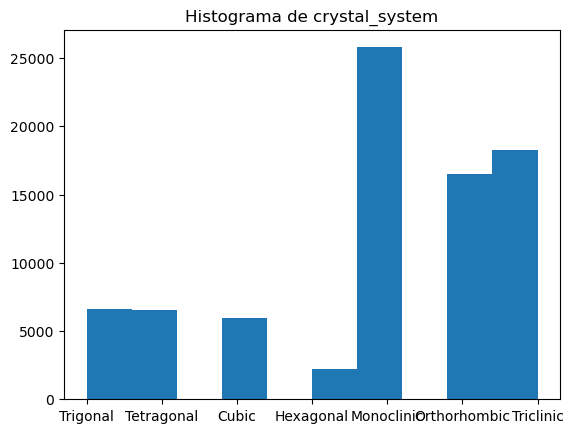

In [585]:
# histograma de crystal_system
plt.hist(categoricas['crystal_system'].dropna())
plt.title('Histograma de crystal_system')

In [586]:
tabla_crystal_system_semiconductor = (
    data.groupby('crystal_system')['is_semiconductor']
    .mean()
    .mul(100)
    .reset_index(name='pct_is_semiconductor')
    .sort_values('pct_is_semiconductor', ascending=False)
)
tabla_crystal_system_semiconductor

crystal_system  pct_is_semiconductor
5      Triclinic             85.839209
2     Monoclinic             81.036756
4     Tetragonal             80.722341
6       Trigonal             79.553734
3   Orthorhombic             79.489814
0          Cubic             79.349102
1      Hexagonal             76.274945

In [587]:
# buscamos nulos en categoricas
categoricas.isnull().sum()

crystal_system    0
dtype: int64

In [588]:
# transformamos crystal_system a numerica usando one hot encoder y lo sustituimos en categoricas
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categoricas_ohe = ohe.fit_transform(categoricas[['crystal_system']])
categoricas_ohe_df = pd.DataFrame(categoricas_ohe, columns=ohe.get_feature_names_out(['crystal_system']))
categoricas = pd.concat([categoricas.reset_index(drop=True).drop(columns=['crystal_system']), categoricas_ohe_df], axis=1)
categoricas

crystal_system_Cubic  crystal_system_Hexagonal  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       1.0                       0.0   
4                       1.0                       0.0   
...                     ...                       ...   
81993                   0.0                       0.0   
81994                   0.0                       0.0   
81995                   1.0                       0.0   
81996                   0.0                       0.0   
81997                   0.0                       0.0   

       crystal_system_Monoclinic  crystal_system_Orthorhombic  \
0                            0.0                          0.0   
1                            0.0                          0.0   
2                            0.0                          0.0   
3                            0.0                          0.0   
4                            0.0                          0.0   
...                          ...                          ...   
81993                        0.0                          1.0   
81994                        0.0                          1.0   
81995                        0.0                          0.0   
81996                        0.0                          0.0   
81997                        0.0                          1.0   

       crystal_system_Tetragonal  crystal_system_Triclinic  \
0                            0.0                       0.0   
1                            1.0                       0.0   
2                            0.0                       0.0   
3                            0.0                       0.0   
4                            0.0                       0.0   
...                          ...                       ...   
81993                        0.0                       0.0   
81994                        0.0                       0.0   
81995                        0.0                       0.0   
81996                        0.0                       0.0   
81997                        0.0                       0.0   

       crystal_system_Trigonal  
0                          1.0  
1                          0.0  
2                          1.0  
3                          0.0  
4                          0.0  
...                        ...  
81993                      0.0  
81994                      0.0  
81995                      0.0  
81996                      1.0  
81997                      0.0  

[81998 rows x 7 columns]

## Analizamos las variables boleanas

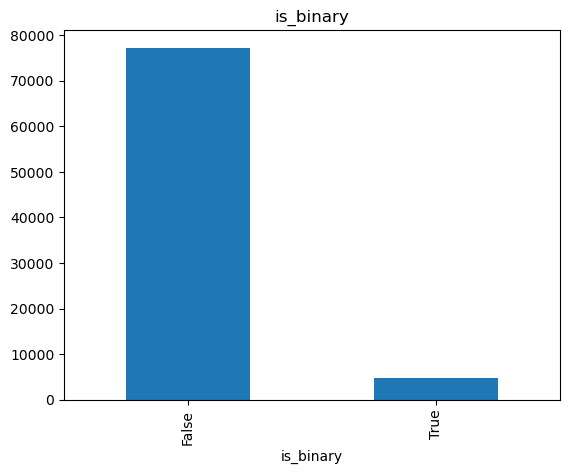

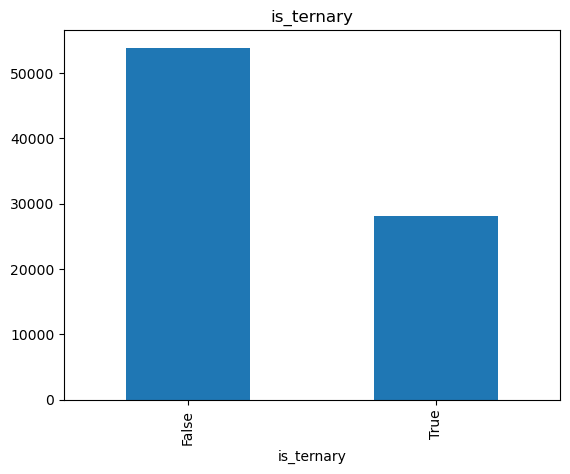

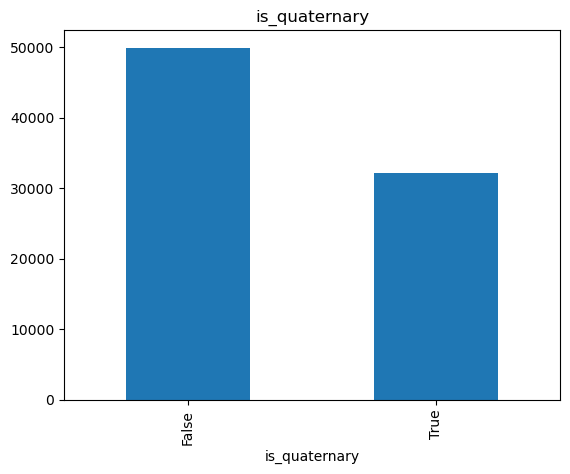

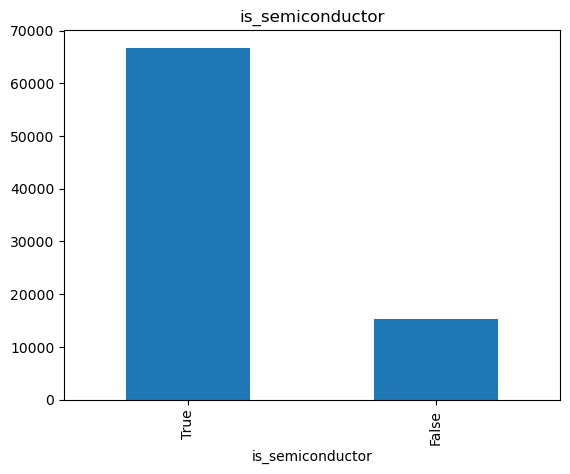

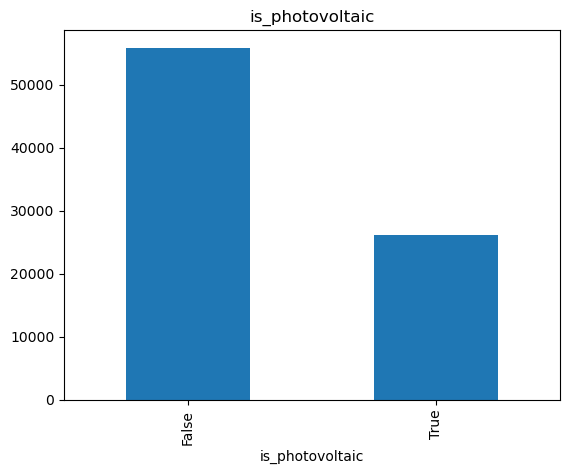

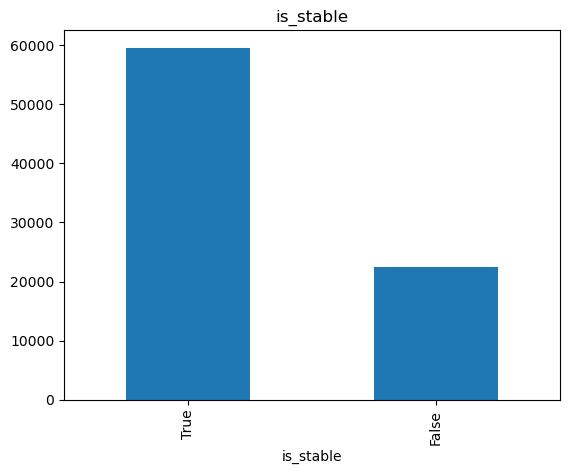

In [589]:
## Analizamos las variables boleanas con histogramas
for col in booleanas.columns:
    booleanas[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()
    

In [590]:
data[['is_binary','n_elements','is_ternary','is_quaternary']]

is_binary  n_elements  is_ternary  is_quaternary
0           True           2       False          False
1           True           2       False          False
2           True           2       False          False
3          False           3        True          False
4          False           3        True          False
...          ...         ...         ...            ...
81993      False           3        True          False
81994      False           3        True          False
81995      False           3        True          False
81996      False           3        True          False
81997      False           3        True          False

[81998 rows x 4 columns]

#### is_binary,is_ternary,is_,is_quaternary  estan dentro de n_elements, por lo que las eliminamos

In [591]:
# borra de data is_ternary,is_binary,is_quaternary
booleanas = booleanas.drop(columns=['is_ternary','is_binary','is_quaternary'])



In [592]:
booleanas.dtypes

is_semiconductor    bool
is_photovoltaic     bool
is_stable           bool
dtype: object

In [593]:
# miramos si hay nulos en booleanas
booleanas.isnull().sum()

is_semiconductor    0
is_photovoltaic     0
is_stable           0
dtype: int64

In [594]:
# separamos las variables is_semiconductor,is_photovoltaic,is_stable y band_gap en un dataframe aparte
y_data_is_semiconductor = booleanas['is_semiconductor']
y_data_is_photovoltaic = booleanas['is_photovoltaic']
y_data_is_stable = booleanas['is_stable']
y_data_band_gap = numericas['band_gap']
# une las variables booleanas y numericas y categoricas en un solo dataframe
X_data = pd.concat([numericas, categoricas], axis=1)
# quitaless las variables is_semiconductor,is_photovoltaic,is_stable y band_gap
X_data = X_data.drop(columns=['band_gap'])


In [595]:
X_data.dtypes

formation_energy_per_atom      float64
energy_above_hull              float64
density                        float64
nsites                           int64
volume                         float64
spacegroup_number                int64
volume_per_atom                float64
n_elements                       int64
avg_atomic_mass                float64
min_atomic_mass                float64
max_atomic_mass                float64
avg_electronegativity          float64
electronegativity_range        float64
avg_atomic_radius              float64
range_atomic_mass              float64
crystal_system_Cubic           float64
crystal_system_Hexagonal       float64
crystal_system_Monoclinic      float64
crystal_system_Orthorhombic    float64
crystal_system_Tetragonal      float64
crystal_system_Triclinic       float64
crystal_system_Trigonal        float64
dtype: object

### Division de los datos en train y test

In [596]:
y_data_is_semiconductor = y_data_is_semiconductor.astype(int)
y_data_is_semiconductor.value_counts()

is_semiconductor
1    66745
0    15253
Name: count, dtype: int64

In [597]:

y_data_is_semiconductor.value_counts(normalize=True) * 100



is_semiconductor
1    81.398327
0    18.601673
Name: proportion, dtype: float64

In [598]:
X_data_1=X_data

In [599]:
x_train40, x_test40, y_train40, y_test40 = train_test_split(X_data_1, y_data_is_semiconductor, test_size=0.5, random_state=42)

In [600]:
x_train, x_test, y_train, y_test = train_test_split(x_train40, y_train40, test_size=0.2, random_state=42)

In [601]:
y_train.value_counts(normalize=True) * 100

is_semiconductor
1    81.526876
0    18.473124
Name: proportion, dtype: float64

In [602]:
# Unir X_data con la variable objetivo en un solo DataFrame
df_semiconductor = pd.concat(
    [X_data, y_data_is_semiconductor.rename("is_semiconductor")],
    axis=1
)

# Vista rápida
print(df_semiconductor.shape)
df_semiconductor.head()

(81998, 23)


formation_energy_per_atom  energy_above_hull   density  nsites  \
0                  -3.737668           0.000000  9.109130       5   
1                  -2.493064           0.000000  6.535149      40   
2                  -2.440364           0.052700  5.562971      10   
3                  -0.996232           0.253251  7.997421       4   
4                  -3.690019           0.000000  8.728230       5   

        volume  spacegroup_number  volume_per_atom  n_elements  \
0    91.511224                164        18.302245           2   
1  1118.407852                122        27.960196           2   
2   328.464893                167        32.846489           2   
3   122.518406                225        30.629602           3   
4    57.451413                221        11.490283           3   

   avg_atomic_mass  min_atomic_mass  ...  avg_atomic_radius  \
0       121.499700          15.9994  ...           1.275000   
1       129.532500          32.0650  ...           1.475000   
2       129.532500          32.0650  ...           1.475000   
3       154.156067         107.8682  ...           1.650000   
4        89.993646          15.9994  ...           1.266667   

   range_atomic_mass  crystal_system_Cubic  crystal_system_Hexagonal  \
0           211.0006                   0.0                       0.0   
1           194.9350                   0.0                       0.0   
2           194.9350                   0.0                       0.0   
3           119.1318                   1.0                       0.0   
4           211.0006                   1.0                       0.0   

   crystal_system_Monoclinic  crystal_system_Orthorhombic  \
0                        0.0                          0.0   
1                        0.0                          0.0   
2                        0.0                          0.0   
3                        0.0                          0.0   
4                        0.0                          0.0   

   crystal_system_Tetragonal  crystal_system_Triclinic  \
0                        0.0                       0.0   
1                        1.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0                       0.0   

   crystal_system_Trigonal  is_semiconductor  
0                      1.0                 1  
1                      0.0                 1  
2                      1.0                 1  
3                      0.0                 0  
4                      0.0                 0  

[5 rows x 23 columns]

# modelo = xgb_best

In [603]:
# ========= CONFIG =========
USE_GPU      = True          # False si no tienes CUDA
RANDOM_STATE = 42
ALPHA_1      = 1.8           # refuerzo a la clase 1 -> ↓FN -> ↑precision_0
CALIBRATE    = False         # pon True si quieres calibrar con isotónica

# ========= IMPORTS =========
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)
from sklearn.calibration import CalibratedClassifierCV

# ========= 0) Split train/valid si no existen =========
x_tr, x_val, y_tr, y_val = train_test_split(
        x_train, y_train, test_size=0.20, stratify=y_train, random_state=RANDOM_STATE
    )

# ========= 1) Modelo (SIN CV) =========
params = dict(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.05,
    subsample=1.0,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=0.0,
    gamma=0.2,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="gpu_hist" if USE_GPU else "hist",
    predictor="gpu_predictor" if USE_GPU else "auto",
)
xgb_prec0 = XGBClassifier(**params)

# Pesos: balance + refuerzo a la CLASE 1 (↓FN -> ↑precision_0)
sw_tr = compute_sample_weight("balanced", y=y_tr).astype(float)
sw_tr[y_tr == 1] *= ALPHA_1

xgb_prec0.fit(x_tr, y_tr, sample_weight=sw_tr)

# (opcional) calibración para probabilidades más fiables
if CALIBRATE:
    cal = CalibratedClassifierCV(xgb_prec0, method="isotonic", cv="prefit")
    cal.fit(x_val, y_val)
    model_for_proba = cal
else:
    model_for_proba = xgb_prec0

# ========= 2) Probabilidades en VALIDACIÓN para probar umbrales =========
p_val = model_for_proba.predict_proba(x_val)[:, 1]  # P(y=1|x) en validación

# Función para barrer umbrales y ver métricas de ambas clases
def sweep_thresholds(y_true, p1, taus):
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
    rows = []
    for t in taus:
        y_hat = (p1 >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        rows.append({
            "tau": float(t),
            "TN": tn, "FP": fp, "FN": fn, "TP": tp,
            "precision_0": precision_score(y_true, y_hat, pos_label=0, zero_division=0),
            "recall_0":    recall_score(y_true,  y_hat, pos_label=0),
            "f1_0":        f1_score(y_true,     y_hat, pos_label=0),
            "precision_1": precision_score(y_true, y_hat, pos_label=1, zero_division=0),
            "recall_1":    recall_score(y_true,  y_hat, pos_label=1),
            "f1_1":        f1_score(y_true,      y_hat, pos_label=1),
        })
    return pd.DataFrame(rows).sort_values("tau").reset_index(drop=True)

taus = np.linspace(0.05, 0.95, 181)
tab_val = sweep_thresholds(y_val, p_val, taus)
print(tab_val.head())
print(tab_val.tail())

# Ejemplos de selección de τ (elige el que te interese):
tau_f1_0     = tab_val.loc[tab_val["f1_0"].idxmax(), "tau"]
tau_prec0_60 = tab_val[tab_val["precision_0"] >= 0.60].sort_values("recall_0", ascending=False).iloc[0]["tau"]

print(f"\nτ que maximiza F1_0 en validación: {tau_f1_0:.3f}")
print(f"τ que maximiza recall_0 con precision_0 ≥ 0.60: {tau_prec0_60:.3f}")

# ========= 3) Evaluación en TEST con corte 0.5 (referencia rápida) =========
y_pred_test = xgb_prec0.predict(x_test)  # corte estándar 0.5
print("\n== TEST con corte 0.5 ==")
print("CM [[TN, FP],[FN, TP]]:\n", confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test, digits=3))
print("precision_0:", precision_score(y_test, y_pred_test, pos_label=0, zero_division=0),
      "| recall_0:",   recall_score(y_test, y_pred_test, pos_label=0),
      "| f1_0:",       f1_score(y_test, y_pred_test, pos_label=0))

# (cuando elijas τ final en validación):
# p_test  = model_for_proba.predict_proba(x_test)[:, 1]
# y_test_tau = (p_test >= tau_f1_0).astype(int)  # por ejemplo
# ...calculas métricas en TEST con ese τ


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:19:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tr

     tau   TN   FP  FN    TP  precision_0  recall_0      f1_0  precision_1  \
0  0.050  269  943  16  5332     0.943860  0.221947  0.359385     0.849721   
1  0.055  281  931  18  5330     0.939799  0.231848  0.371939     0.851302   
2  0.060  293  919  21  5327     0.933121  0.241749  0.384010     0.852866   
3  0.065  299  913  22  5326     0.931464  0.246700  0.390085     0.853662   
4  0.070  313  899  24  5324     0.928783  0.258251  0.404132     0.855536   

   recall_1      f1_1  
0  0.997008  0.917491  
1  0.996634  0.918253  
2  0.996073  0.918924  
3  0.995886  0.919306  
4  0.995512  0.920232  
       tau    TN   FP    FN    TP  precision_0  recall_0      f1_0  \
176  0.930  1017  195  1794  3554     0.361793  0.839109  0.505593   
177  0.935  1023  189  1900  3448     0.349983  0.844059  0.494800   
178  0.940  1031  181  2011  3337     0.338922  0.850660  0.484720   
179  0.945  1042  170  2145  3203     0.326953  0.859736  0.473744   
180  0.950  1061  151  2308  3040    

max_atomic_mass                0.114844
min_atomic_mass                0.067512
range_atomic_mass              0.065104
formation_energy_per_atom      0.058061
electronegativity_range        0.052287
energy_above_hull              0.049408
density                        0.046156
n_elements                     0.044137
avg_atomic_mass                0.044047
avg_electronegativity          0.042387
nsites                         0.040655
volume_per_atom                0.039442
crystal_system_Hexagonal       0.038036
avg_atomic_radius              0.037735
spacegroup_number              0.037572
crystal_system_Tetragonal      0.036833
volume                         0.034418
crystal_system_Cubic           0.033566
crystal_system_Trigonal        0.032615
crystal_system_Monoclinic      0.030095
crystal_system_Triclinic       0.029116
crystal_system_Orthorhombic    0.025975
dtype: float32


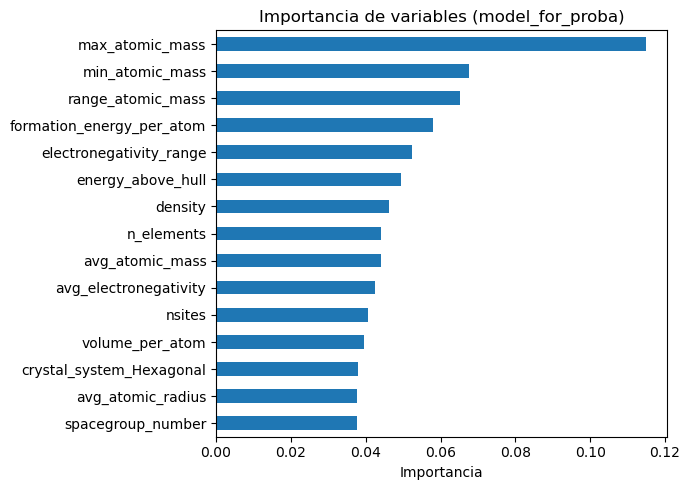

In [604]:
import pandas as pd

import matplotlib.pyplot as plt

# Obtener importancias de las features del modelo model_for_proba
importances = model_for_proba.feature_importances_
features = x_train.columns  # usa el mismo orden de columnas que el entrenamiento

# Crear un DataFrame ordenado
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
print(feat_imp)

# Gráfico de barras de las 15 más importantes
feat_imp.head(15).plot(kind='barh', figsize=(7,5))
plt.gca().invert_yaxis()
plt.title("Importancia de variables (model_for_proba)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

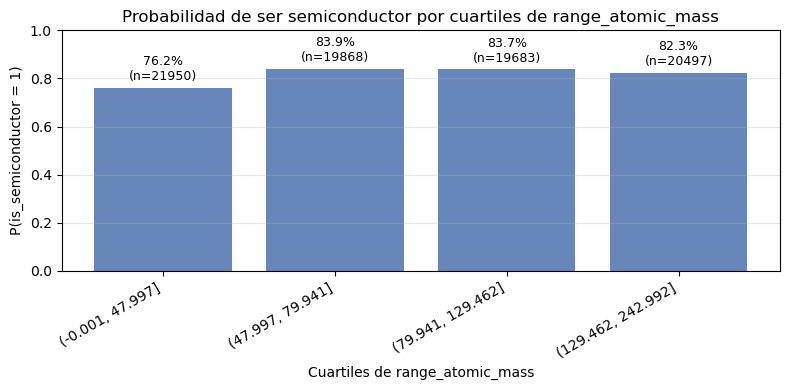

cuartil_range_atomic_mass  prob_is_semiconductor      n
0          (-0.001, 47.997]               0.762232  21950
1          (47.997, 79.941]               0.838987  19868
2         (79.941, 129.462]               0.837271  19683
3        (129.462, 242.992]               0.822803  20497

In [623]:
# Probabilidad de is_semiconductor por cuartiles de range_atomic_mass (barras)
# Usa df_semiconductor ya creado (X_data + is_semiconductor)

# 1) Subset y limpieza
df = df_semiconductor[["range_atomic_mass", "is_semiconductor"]].copy()
df["is_semiconductor"] = df["is_semiconductor"].astype(int)
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# 2) Cuartiles de range_atomic_mass
ram_q = pd.qcut(df["range_atomic_mass"], q=4, duplicates="drop")
probs = df.groupby(ram_q, observed=True)["is_semiconductor"].mean()
counts = df.groupby(ram_q, observed=True)["is_semiconductor"].size()

# 3) Gráfico de barras
plt.figure(figsize=(8,4))
x = np.arange(len(probs))
plt.bar(x, probs.values, color="#4C72B0", alpha=0.85)
plt.xticks(x, [str(c) for c in probs.index], rotation=30, ha="right")
plt.ylabel("P(is_semiconductor = 1)")
plt.xlabel("Cuartiles de range_atomic_mass")
plt.title("Probabilidad de ser semiconductor por cuartiles de range_atomic_mass")
plt.ylim(0, 1.0)
plt.grid(axis="y", alpha=0.3)

# Etiquetas arriba de cada barra: % y n
for i, (p, n) in enumerate(zip(probs.values, counts.values)):
    plt.text(i, p + 0.02, f"{p*100:.1f}%\n(n={n})", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# (Opcional) Mostrar tabla
pd.DataFrame({
    "cuartil_range_atomic_mass": [str(c) for c in probs.index],
    "prob_is_semiconductor": probs.values,
    "n": counts.values
})

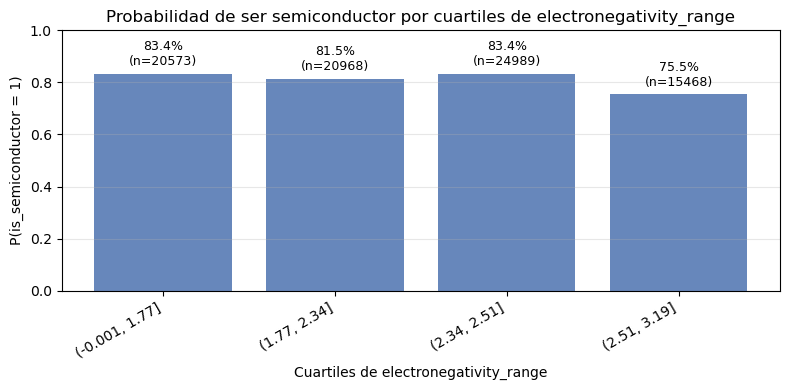

cuartil_electronegativity_range  prob_is_semiconductor      n
0                  (-0.001, 1.77]               0.833520  20573
1                    (1.77, 2.34]               0.814908  20968
2                    (2.34, 2.51]               0.833527  24989
3                    (2.51, 3.19]               0.755172  15468

In [627]:
# Probabilidad de is_semiconductor por cuartiles de range_atomic_mass (barras)
# Usa df_semiconductor ya creado (X_data + is_semiconductor)

# 1) Subset y limpieza
df = df_semiconductor[["electronegativity_range", "is_semiconductor"]].copy()
df["is_semiconductor"] = df["is_semiconductor"].astype(int)
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# 2) Cuartiles de electronegativity_range
ram_q = pd.qcut(df["electronegativity_range"], q=4, duplicates="drop")
probs = df.groupby(ram_q, observed=True)["is_semiconductor"].mean()
counts = df.groupby(ram_q, observed=True)["is_semiconductor"].size()

# 3) Gráfico de barras
plt.figure(figsize=(8,4))
x = np.arange(len(probs))
plt.bar(x, probs.values, color="#4C72B0", alpha=0.85)
plt.xticks(x, [str(c) for c in probs.index], rotation=30, ha="right")
plt.ylabel("P(is_semiconductor = 1)")
plt.xlabel("Cuartiles de electronegativity_range")
plt.title("Probabilidad de ser semiconductor por cuartiles de electronegativity_range")
plt.ylim(0, 1.0)
plt.grid(axis="y", alpha=0.3)

# Etiquetas arriba de cada barra: % y n
for i, (p, n) in enumerate(zip(probs.values, counts.values)):
    plt.text(i, p + 0.02, f"{p*100:.1f}%\n(n={n})", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# (Opcional) Mostrar tabla
pd.DataFrame({
    "cuartil_electronegativity_range": [str(c) for c in probs.index],
    "prob_is_semiconductor": probs.values,
    "n": counts.values
})

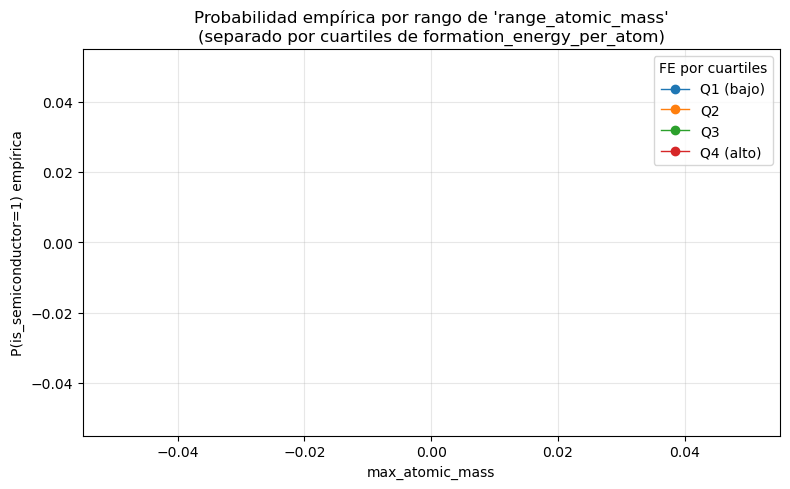

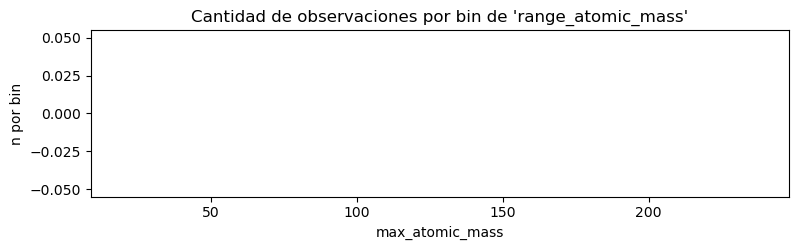

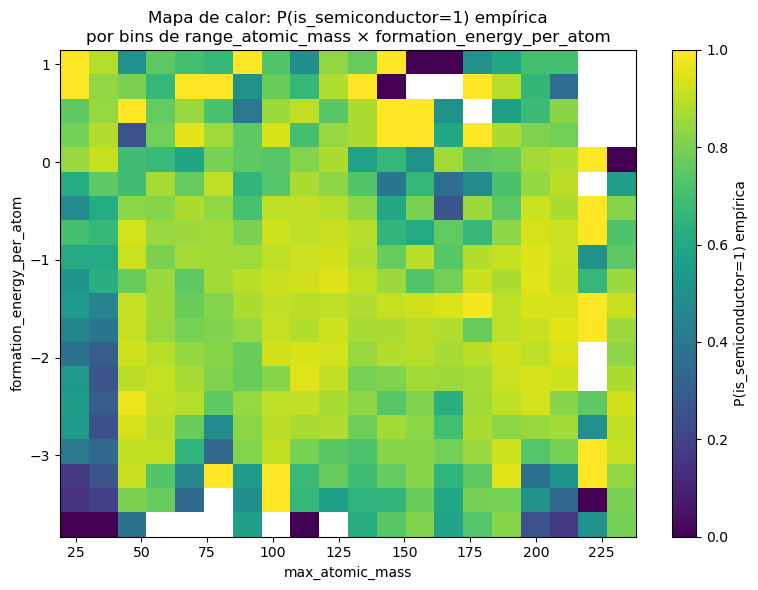

In [622]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====== Configura nombres de columnas ======
COL_X  = "max_atomic_mass"
COL_FE = "formation_energy_per_atom"
TARGET = "is_semiconductor"  # solo para el df combinado

# ====== Combinar datos ======
df = df_semiconductor[[COL_X, COL_FE]].copy()
df[TARGET] = pd.Series(df_semiconductor[TARGET]).astype(int)
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# ================================
# A) CURVAS CONDICIONALES (por cuartiles de FE)
# ================================
# Bins en X (usa percentiles para evitar outliers extremos)
nbins_x = 20
x_lo, x_hi = df[COL_X].quantile([0.01, 0.99]).values
bins_x = np.linspace(x_lo, x_hi, nbins_x + 1)
x_labels = 0.5 * (bins_x[:-1] + bins_x[1:])  # centros

# Cuartiles de formation_energy_per_atom
df["fe_q"] = pd.qcut(df[COL_FE], q=4, labels=["Q1 (bajo)", "Q2", "Q3", "Q4 (alto)"])

# Calcular proporciones por bin de X y por cuartil de FE
curvas = {}
for q in df["fe_q"].cat.categories:
    d = df[df["fe_q"] == q]
    # cortar por bins_x y calcular media de TARGET (proporción de y=1)
    g = (d
         .assign(xbin=pd.cut(d[COL_X], bins=bins_x, include_lowest=True))
         .groupby("xbin", observed=True)[TARGET]
         .mean())
    # Alinear con todos los bins (puede haber NaN si no hay datos en un bin)
    g = g.reindex(pd.IntervalIndex.from_breaks(bins_x), fill_value=np.nan)
    curvas[q] = g.values

plt.figure(figsize=(8,5))
for q, yvals in curvas.items():
    plt.plot(x_labels, yvals, marker='o', linewidth=1, label=str(q))
plt.xlabel(COL_X)
plt.ylabel(f"P({TARGET}=1) empírica")
plt.title("Probabilidad empírica por rango de 'range_atomic_mass'\n(separado por cuartiles de formation_energy_per_atom)")
plt.legend(title="FE por cuartiles")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# (Opcional) barras de cantidad por bin para saber si hay pocos datos en algún rango
counts_per_bin = (df.assign(xbin=pd.cut(df[COL_X], bins=bins_x, include_lowest=True))
                    .groupby("xbin", observed=True)[TARGET].size()
                    .reindex(pd.IntervalIndex.from_breaks(bins_x), fill_value=0)
                    .values)
plt.figure(figsize=(8,2.6))
plt.bar(x_labels, counts_per_bin, width=(bins_x[1]-bins_x[0])*0.85)
plt.xlabel(COL_X)
plt.ylabel("n por bin")
plt.title("Cantidad de observaciones por bin de 'range_atomic_mass'")
plt.tight_layout()
plt.show()

# ================================
# B) MAPA DE CALOR 2D (X = RAM, Y = FE)
# ================================
nbins_y = 20
y_lo, y_hi = df[COL_FE].quantile([0.01, 0.99]).values
bins_y = np.linspace(y_lo, y_hi, nbins_y + 1)

df["xbin"] = pd.cut(df[COL_X], bins=bins_x, include_lowest=True)
df["ybin"] = pd.cut(df[COL_FE], bins=bins_y, include_lowest=True)

# Matriz de probabilidades: mean(TARGET) por celda (xbin, ybin)
heat = (df.groupby(["ybin", "xbin"], observed=True)[TARGET]
          .mean()
          .unstack("xbin"))

# Ejes para pcolormesh (requiere bordes, no centros)
X_edges = bins_x
Y_edges = bins_y
Z = heat.values  # shape (nbins_y, nbins_x)

plt.figure(figsize=(8,6))
# pcolormesh espera (Y, X) en el orden de la matriz
pcm = plt.pcolormesh(X_edges, Y_edges, Z, shading='auto')
cbar = plt.colorbar(pcm); cbar.set_label(f"P({TARGET}=1) empírica")
plt.xlabel(COL_X); plt.ylabel(COL_FE)
plt.title("Mapa de calor: P(is_semiconductor=1) empírica\npor bins de range_atomic_mass × formation_energy_per_atom")
plt.tight_layout()
plt.show()


In [610]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Parámetros ajustables ===
col_x  = "range_atomic_mass"
col_fe = "formation_energy_per_atom"
min_count = 15          # mínimo de muestras por bin para dibujarlo
n_bins_x  = 18          # nº de bins en el eje X (range_atomic_mass)
drop_outliers = (0.01, 0.99)  # recorte de colas para evitar bins vacíos

# --- 1) Construye y limpia el dataframe ---
y = pd.Series(y_data_is_semiconductor).copy()

# Fuerza a 0/1 de forma robusta
def to01(s):
    if pd.api.types.is_bool_dtype(s):
        return s.astype(int)
    if pd.api.types.is_numeric_dtype(s):
        return (pd.to_numeric(s, errors="coerce").fillna(0) > 0).astype(int)
    # mapeo básico si viniera como texto
    return s.map({1:1,'1':1,True:1,'True':1,'true':1,'yes':1,'Y':1,'semiconductor':1}).fillna(0).astype(int)

y01 = to01(y)

df = pd.DataFrame({
    "x":  X_data[col_x],
    "fe": X_data[col_fe],
    "y":  y01
}).replace([np.inf, -np.inf], np.nan).dropna()

# (opcional) recorta outliers de X para evitar bins casi vacíos
x_low, x_high = df["x"].quantile(drop_outliers[0]), df["x"].quantile(drop_outliers[1])
df = df[(df["x"] >= x_low) & (df["x"] <= x_high)].copy()

# --- 2) Bins en X y cuartiles en FE ---
df["x_bin"]  = pd.cut(df["x"], bins=n_bins_x, include_lowest=True)
# Si hay muchos empates en FE, qcut puede col


# tabla umbrales


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
)

# --- Probabilidades en VALIDACIÓN ---
try:
    p_val = model_for_proba.predict_proba(x_val)[:, 1]
except NameError:
    # si no tienes 'model_for_proba', usa directamente el modelo entrenado
    p_val = xgb_prec0.predict_proba(x_val)[:, 1]

def sweep_thresholds(y_true, p1, taus):
    rows = []
    for t in taus:
        y_hat = (p1 >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        rows.append({
            "tau": float(t),
            "TN": tn, "FP": fp, "FN": fn, "TP": tp,
            "n_pred0": int((y_hat == 0).sum()),
            "n_pred1": int((y_hat == 1).sum()),
            "precision_0": precision_score(y_true, y_hat, pos_label=0, zero_division=0),
            "recall_0":    recall_score(y_true,  y_hat, pos_label=0),
            "f1_0":        f1_score(y_true,     y_hat, pos_label=0),
            "precision_1": precision_score(y_true, y_hat, pos_label=1, zero_division=0),
            "recall_1":    recall_score(y_true,  y_hat, pos_label=1),
            "f1_1":        f1_score(y_true,      y_hat, pos_label=1),
            "accuracy":    accuracy_score(y_true, y_hat),
        })
    return pd.DataFrame(rows).sort_values("tau").reset_index(drop=True)

# Barrido de τ
taus = np.linspace(0.05, 0.95, 181)
tab_val = sweep_thresholds(y_val, p_val, taus)
print("VAL (primeras filas):\n", tab_val.head(8))
print("VAL (últimas filas):\n", tab_val.tail(8))

# ======== Selección de τ en VALIDACIÓN ========
# 1) τ que maximiza F1 de la clase 0
tau_f1_0 = tab_val.loc[tab_val["f1_0"].idxmax(), "tau"]

# 2) τ que maximiza recall_0 cumpliendo precision_0 >= cota (ajusta la cota si quieres)
MIN_PREC0 = 0.60
cand = tab_val[tab_val["precision_0"] >= MIN_PREC0]
tau_rec0_cota = cand.loc[cand["recall_0"].idxmax(), "tau"] if not cand.empty else tau_f1_0

# 3) τ que maximiza Fβ de la clase 0 (β>1 prioriza recall, β<1 prioriza precision)
BETA = 2.0
fbeta0 = (1 + BETA**2) * tab_val["precision_0"] * tab_val["recall_0"] / (
         BETA**2 * tab_val["precision_0"] + tab_val["recall_0"] + 1e-12)
tau_fbeta0 = tab_val.loc[fbeta0.idxmax(), "tau"]

print(f"\nτ* F1_0 (val): {tau_f1_0:.3f}")
print(f"τ* max recall_0 con precision_0 ≥ {MIN_PREC0:.2f} (val): {tau_rec0_cota:.3f}")
print(f"τ* Fβ_0 (β={BETA:.1f}) (val): {tau_fbeta0:.3f}")

# ======== Evaluación en TEST para los τ elegidos ========
def eval_en_test(tau, modelo):
    p_test = modelo.predict_proba(x_test)[:, 1]
    y_hat  = (p_test >= tau).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    out = {
        "tau": tau, "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "precision_0": precision_score(y_test, y_hat, pos_label=0, zero_division=0),
        "recall_0":    recall_score(y_test,  y_hat, pos_label=0),
        "f1_0":        f1_score(y_test,     y_hat, pos_label=0),
        "precision_1": precision_score(y_test, y_hat, pos_label=1, zero_division=0),
        "recall_1":    recall_score(y_test,  y_hat, pos_label=1),
        "f1_1":        f1_score(y_test,      y_hat, pos_label=1),
        "accuracy":    accuracy_score(y_test, y_hat),
    }
    return out

# usa el calibrado si lo tienes; si no, el modelo directo
modelo_eval = model_for_proba if 'model_for_proba' in globals() else xgb_prec0

res_test = pd.DataFrame([
    eval_en_test(tau_f1_0,     modelo_eval),
    eval_en_test(tau_rec0_cota,modelo_eval),
    eval_en_test(tau_fbeta0,   modelo_eval),
])
print("\n== TEST para τ elegidos en VALIDACIÓN ==")
print(res_test)

# (Opcional) Tabla completa en TEST para TODOS los τ:
p_test_all = modelo_eval.predict_proba(x_test)[:, 1]
tab_test   = sweep_thresholds(y_test, p_test_all, taus)
# Ejemplo: ver los 5 mejores τ por F1_0 en TEST
print("\nTop-5 τ por F1_0 (TEST):")
print(tab_test.sort_values("f1_0", ascending=False).head(5))


VAL (primeras filas):
      tau   TN   FP  FN    TP  n_pred0  n_pred1  precision_0  recall_0  \
0  0.050  269  943  16  5332      285     6275     0.943860  0.221947   
1  0.055  281  931  18  5330      299     6261     0.939799  0.231848   
2  0.060  293  919  21  5327      314     6246     0.933121  0.241749   
3  0.065  299  913  22  5326      321     6239     0.931464  0.246700   
4  0.070  313  899  24  5324      337     6223     0.928783  0.258251   
5  0.075  323  889  26  5322      349     6211     0.925501  0.266502   
6  0.080  326  886  26  5322      352     6208     0.926136  0.268977   
7  0.085  337  875  29  5319      366     6194     0.920765  0.278053   

       f1_0  precision_1  recall_1      f1_1  accuracy  
0  0.359385     0.849721  0.997008  0.917491  0.853811  
1  0.371939     0.851302  0.996634  0.918253  0.855335  
2  0.384010     0.852866  0.996073  0.918924  0.856707  
3  0.390085     0.853662  0.995886  0.919306  0.857470  
4  0.404132     0.855536  0.995512


== TEST40 con τ=0.725 ==
CM [[TN, FP],[FN, TP]]:
 [[ 4961  2709]
 [ 3279 30050]]
              precision    recall  f1-score   support

           0      0.602     0.647     0.624      7670
           1      0.917     0.902     0.909     33329

    accuracy                          0.854     40999
   macro avg      0.760     0.774     0.767     40999
weighted avg      0.858     0.854     0.856     40999

precision_0: 0.6020631067961165 | recall_0: 0.6468057366362451 | f1_0: 0.6236329352608423 | accuracy: 0.8539476572599332


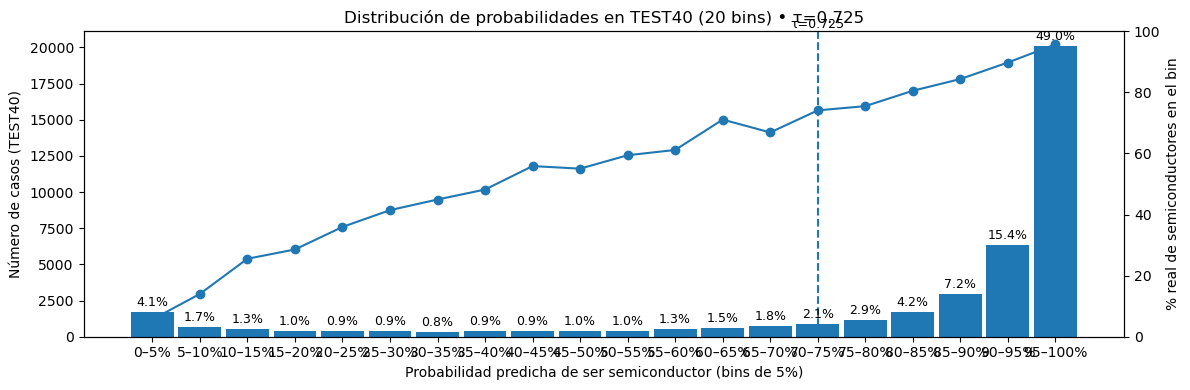

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# === Config ===
TAU = 0.725
model = xgb_prec0          # usa tu modelo final (cal, lgbm_best, xgb_best, brf_best, etc.)
X, y = x_test40, y_test40

# === Probabilidades (sin umbral) y predicción con τ ===
p = model.predict_proba(X)[:, 1]
y_pred_tau = (p >= TAU).astype(int)

# === Métricas en TEST40 con τ ===
cm = confusion_matrix(y, y_pred_tau)
tn, fp, fn, tp = cm.ravel()
print(f"\n== TEST40 con τ={TAU} ==")
print("CM [[TN, FP],[FN, TP]]:\n", cm)
print(classification_report(y, y_pred_tau, digits=3))
print(
    "precision_0:", precision_score(y, y_pred_tau, pos_label=0, zero_division=0),
    "| recall_0:",   recall_score(y, y_pred_tau, pos_label=0),
    "| f1_0:",       f1_score(y, y_pred_tau, pos_label=0),
    "| accuracy:",   accuracy_score(y, y_pred_tau)
)

# === Gráfico 20 bins (5%) en TEST40 + τ marcado ===
def grafico_prob_20bins_con_tau(p, y=None, tau=0.5, title="Distribución de probabilidades en TEST40 (20 bins)"):
    n_bins = 20
    edges = np.linspace(0, 1, n_bins + 1)              # [0, 0.05, ..., 1.0]
    labels = [f"{int(a*100)}–{int(b*100)}%" for a, b in zip(edges[:-1], edges[1:])]
    idx = np.clip(np.digitize(p, edges, right=False) - 1, 0, n_bins - 1)

    counts = np.bincount(idx, minlength=n_bins)
    pct_total = counts / len(p) * 100.0

    pct_pos_real = None
    if y is not None:
        pct_pos_real = [100*np.mean(y[idx==b]) if np.any(idx==b) else np.nan for b in range(n_bins)]

    fig, ax = plt.subplots(figsize=(12, 4))
    x = np.arange(n_bins)
    bars = ax.bar(x, counts, width=0.9)

    # Etiquetas: % del total
    if len(counts) > 0:
        bump = max(counts) * 0.01
    else:
        bump = 0.1
    for i, c in enumerate(counts):
        ax.text(i, c + bump, f"{pct_total[i]:.1f}%", ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel("Probabilidad predicha de ser semiconductor (bins de 5%)")
    ax.set_ylabel("Número de casos (TEST40)")
    ax.set_title(title)

    # % real de semiconductores (eje derecho)
    if pct_pos_real is not None:
        ax2 = ax.twinx()
        ax2.plot(x, pct_pos_real, marker="o")
        ax2.set_ylim(0, 100)
        ax2.set_ylabel("% real de semiconductores en el bin")

    # Línea vertical en τ (mapa continuo → eje de bins)
    # Mapeo: x_tau = tau * n_bins - 0.5  (0→-0.5, 1→19.5)
    x_tau = tau * n_bins - 0.5
    ax.axvline(x_tau, linestyle="--")
    ax.text(min(max(x_tau, 0), n_bins-1), max(counts)*1.05 if len(counts)>0 else 1.0,
            f"τ={tau:.3f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

grafico_prob_20bins_con_tau(p, y=y, tau=TAU,
                            title=f"Distribución de probabilidades en TEST40 (20 bins) • τ={TAU}")


ROC-AUC: 0.861 | PR-AUC (clase 1): 0.955 | PR-AUC (clase 0): 0.698 | KS: -0.000
Brier score: 0.0960
ECE@20: 0.0342


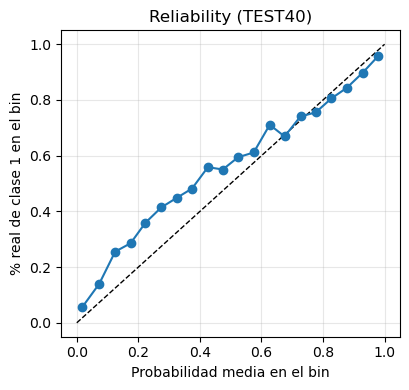


== TEST40 con τ=0.725 ==
CM [[TN, FP],[FN, TP]]:
 [[ 4961  2709]
 [ 3279 30050]]
              precision    recall  f1-score   support

           0      0.602     0.647     0.624      7670
           1      0.917     0.902     0.909     33329

    accuracy                          0.854     40999
   macro avg      0.760     0.774     0.767     40999
weighted avg      0.858     0.854     0.856     40999

Clase 0 -> precision_0: 0.6020631067961165 | recall_0: 0.6468057366362451 | f1_0: 0.6236329352608423
Clase 1 -> precision_1: 0.9173051680454226 | recall_1: 0.9016172102373309 | f1_1: 0.9093935358915386

== Decile table (TEST40) ==
    decile     n   pos     avg_p  pct_total   rate_pos    cum_pos%
0       0  4100   751  0.101834  10.000244  18.317073    2.253293
1       1  4100  2499  0.545628  10.000244  60.951220    9.751268
2       2  4100  3231  0.805891  10.000244  78.804878   19.445528
3       3  4100  3547  0.895447  10.000244  86.512195   30.087911
4       4  4100  3698  0.9350

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    brier_score_loss, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)

# ==== Datos y modelo ====
TAU   = 0.725
model = xgb_prec0                    # cambia si usas otro
p1    = model.predict_proba(x_test40)[:, 1]   # P(y=1|x) en TEST40
y     = y_test40.astype(int)

# ==============================
# 1) DISCRIMINACIÓN (ranking)
# ==============================
roc_auc = roc_auc_score(y, p1)

# PR-AUC clase 1 (baseline = prevalencia de 1)
ap_1    = average_precision_score(y, p1)

# PR-AUC clase 0 (tratamos 0 como “el positivo”)
y0      = 1 - y
p0      = 1 - p1
ap_0    = average_precision_score(y0, p0)

# KS (máxima separación de CDFs entre clases)
pos = p1[y==1]; neg = p1[y==0]
ks = np.max(np.sort(pos).searchsorted(np.sort(neg), side='right')/len(pos) -
            np.arange(1, len(neg)+1)/len(neg))

print(f"ROC-AUC: {roc_auc:.3f} | PR-AUC (clase 1): {ap_1:.3f} | PR-AUC (clase 0): {ap_0:.3f} | KS: {ks:.3f}")

# ==============================
# 2) CALIBRACIÓN
# ==============================
# Brier (menor es mejor; entre 0 y 0.25 aprox en muchos problemas binarios)
brier = brier_score_loss(y, p1)
print(f"Brier score: {brier:.4f}")

# Reliability curve + Expected Calibration Error (ECE@20)
bins = np.linspace(0, 1, 21)
idx  = np.clip(np.digitize(p1, bins) - 1, 0, 19)
bin_conf = np.array([p1[idx==b].mean() if np.any(idx==b) else np.nan for b in range(20)])
bin_acc  = np.array([y[idx==b].mean()  if np.any(idx==b) else np.nan for b in range(20)])
bin_cnt  = np.array([np.sum(idx==b) for b in range(20)])
w        = bin_cnt / bin_cnt.sum()
ece      = np.nansum(w * np.abs(bin_conf - bin_acc))
print(f"ECE@20: {ece:.4f}")

# Plot reliability
plt.figure(figsize=(4.2,4))
plt.plot([0,1],[0,1],'k--',lw=1)
plt.plot(bin_conf, bin_acc, marker='o')
plt.xlabel('Probabilidad media en el bin')
plt.ylabel('% real de clase 1 en el bin')
plt.title('Reliability (TEST40)')
plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

# ==============================
# 3) RENDIMIENTO AL UMBRAL τ
# ==============================
y_hat = (p1 >= TAU).astype(int)
cm = confusion_matrix(y, y_hat)
tn, fp, fn, tp = cm.ravel()
print("\n== TEST40 con τ=%.3f ==" % TAU)
print("CM [[TN, FP],[FN, TP]]:\n", cm)
print(classification_report(y, y_hat, digits=3))

print(
    "Clase 0 ->",
    "precision_0:", precision_score(y, y_hat, pos_label=0, zero_division=0),
    "| recall_0:",   recall_score(y, y_hat,  pos_label=0),
    "| f1_0:",       f1_score(y, y_hat,      pos_label=0)
)
print(
    "Clase 1 ->",
    "precision_1:", precision_score(y, y_hat, pos_label=1, zero_division=0),
    "| recall_1:",   recall_score(y, y_hat,  pos_label=1),
    "| f1_1:",       f1_score(y, y_hat,      pos_label=1)
)

# ==============================
# 4) DECILE TABLE (ganancias)
# ==============================
df = pd.DataFrame({'y': y, 'p1': p1}).sort_values('p1', ascending=False)
df['decile'] = pd.qcut(df['p1'], 10, labels=False, duplicates='drop')  # 0=top proba
dec = (df.groupby('decile')
         .agg(n=('y','size'), pos=('y','sum'), avg_p=('p1','mean'))
         .reset_index().sort_values('decile'))
dec['pct_total'] = dec['n'] / len(df) * 100
dec['rate_pos']  = dec['pos'] / dec['n'] * 100
dec['cum_pos%']  = dec['pos'].cumsum() / dec['pos'].sum() * 100
print("\n== Decile table (TEST40) ==\n", dec)


ROC-AUC: 0.857 | PR-AUC (clase 1): 0.954 | PR-AUC (clase 0): 0.687
Brier: 0.0974 | ECE@20: 0.0307 | KS: 0.561 en τ≈0.8294


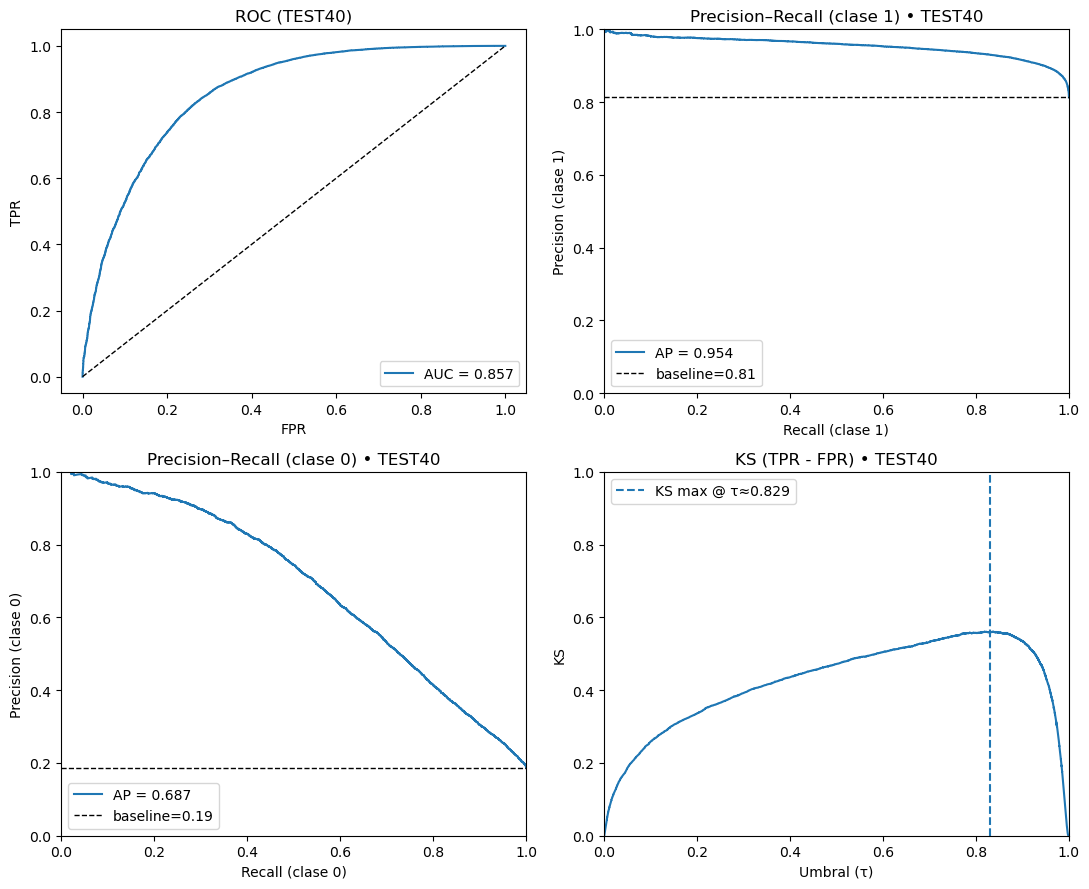

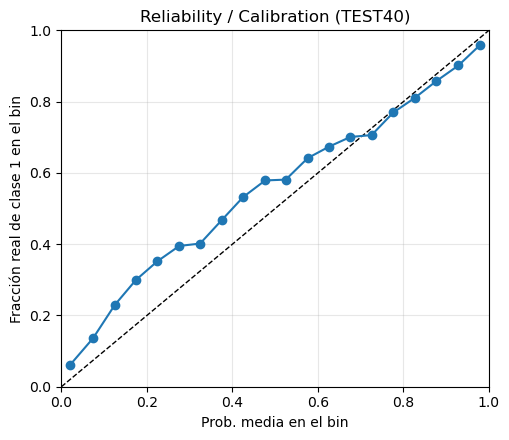

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

# === Modelo y datos ===
model = xgb_prec0           # <-- cambia si usas otro
X, y = x_test40, y_test40.astype(int)
p1 = model.predict_proba(X)[:, 1]     # P(y=1|x)

# ============ ROC ============
fpr, tpr, thr_roc = roc_curve(y, p1)
auc = roc_auc_score(y, p1)

# ============ PR (clase 1) ============
prec1, rec1, thr_pr1 = precision_recall_curve(y, p1)
ap1 = average_precision_score(y, p1)
base1 = y.mean()  # línea base (prevalencia de 1)

# ============ PR (clase 0) ============
y0, p0 = 1 - y, 1 - p1
prec0, rec0, thr_pr0 = precision_recall_curve(y0, p0)
ap0 = average_precision_score(y0, p0)
base0 = y0.mean()  # prevalencia de 0

# ============ KS ============
# KS = max(TPR - FPR) a lo largo de los umbrales de ROC
ks_vals = tpr - fpr
ks = float(np.max(ks_vals))
ks_idx = int(np.argmax(ks_vals))
# Nota: roc_curve devuelve thresholds en orden descendente
ks_tau = float(thr_roc[ks_idx])  # umbral que logra el KS máximo

# ============ Calibration ============
prob_true, prob_pred = calibration_curve(y, p1, n_bins=20, strategy="uniform")
brier = brier_score_loss(y, p1)

# ECE@20 (Expected Calibration Error) manual
bins = np.linspace(0, 1, 21)
idx  = np.clip(np.digitize(p1, bins) - 1, 0, 19)
bin_conf = np.array([p1[idx==b].mean() if np.any(idx==b) else np.nan for b in range(20)])
bin_acc  = np.array([y[idx==b].mean()  if np.any(idx==b) else np.nan for b in range(20)])
bin_cnt  = np.array([np.sum(idx==b) for b in range(20)])
w        = bin_cnt / np.maximum(bin_cnt.sum(), 1)
ece      = float(np.nansum(w * np.abs(bin_conf - bin_acc)))

print(f"ROC-AUC: {auc:.3f} | PR-AUC (clase 1): {ap1:.3f} | PR-AUC (clase 0): {ap0:.3f}")
print(f"Brier: {brier:.4f} | ECE@20: {ece:.4f} | KS: {ks:.3f} en τ≈{ks_tau:.4f}")

# ============ PLOTS ============
fig, axs = plt.subplots(2, 2, figsize=(11, 9))

# ROC
axs[0, 0].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axs[0, 0].plot([0, 1], [0, 1], "k--", lw=1)
axs[0, 0].set_title("ROC (TEST40)")
axs[0, 0].set_xlabel("FPR")
axs[0, 0].set_ylabel("TPR")
axs[0, 0].legend(loc="lower right")

# PR clase 1
axs[0, 1].plot(rec1, prec1, label=f"AP = {ap1:.3f}")
axs[0, 1].hlines(base1, 0, 1, colors="k", linestyles="--", lw=1, label=f"baseline={base1:.2f}")
axs[0, 1].set_xlim(0, 1); axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_title("Precision–Recall (clase 1) • TEST40")
axs[0, 1].set_xlabel("Recall (clase 1)")
axs[0, 1].set_ylabel("Precision (clase 1)")
axs[0, 1].legend(loc="lower left")

# PR clase 0
axs[1, 0].plot(rec0, prec0, label=f"AP = {ap0:.3f}")
axs[1, 0].hlines(base0, 0, 1, colors="k", linestyles="--", lw=1, label=f"baseline={base0:.2f}")
axs[1, 0].set_xlim(0, 1); axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_title("Precision–Recall (clase 0) • TEST40")
axs[1, 0].set_xlabel("Recall (clase 0)")
axs[1, 0].set_ylabel("Precision (clase 0)")
axs[1, 0].legend(loc="lower left")

# KS (TPR-FPR) vs τ
# Ojo: thresholds de ROC pueden incluir inf; filtramos los finitos
thr_plot = thr_roc[np.isfinite(thr_roc)]
ks_plot  = ks_vals[np.isfinite(thr_roc)]
axs[1, 1].plot(thr_plot, ks_plot)
axs[1, 1].axvline(ks_tau, ls="--", label=f"KS max @ τ≈{ks_tau:.3f}")
axs[1, 1].set_xlim(0, 1); axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_title("KS (TPR - FPR) • TEST40")
axs[1, 1].set_xlabel("Umbral (τ)")
axs[1, 1].set_ylabel("KS")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Reliability separado (más limpio)
plt.figure(figsize=(5.2, 4.5))
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.plot(prob_pred, prob_true, marker="o")
plt.xlim(0, 1); plt.ylim(0, 1)
plt.title("Reliability / Calibration (TEST40)")
plt.xlabel("Prob. media en el bin")
plt.ylabel("Fracción real de clase 1 en el bin")
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()


== MATRIZ DE CONFUSIÓN (τ=0.725) ==
[[ 4961  2709]
 [ 3279 30050]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.602     0.647     0.624      7670
           1      0.917     0.902     0.909     33329

    accuracy                          0.854     40999
   macro avg      0.760     0.774     0.767     40999
weighted avg      0.858     0.854     0.856     40999



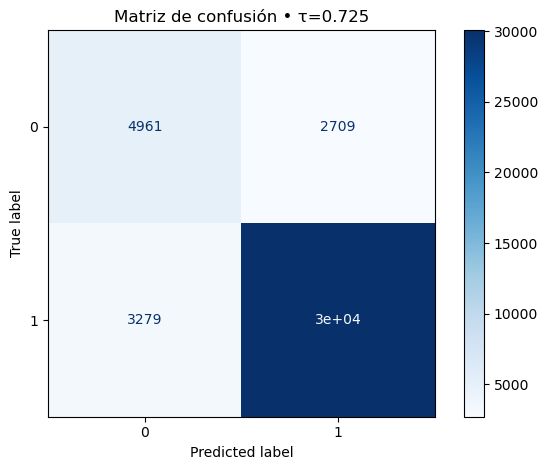

In [691]:
# Matriz de confusión para is_semiconductor con τ=0.725 usando xgb_prec0 en TEST40
TAU = 0.725
model = xgb_prec0

# Datos de test (is_semiconductor)
X, y = x_test40, y_test40.astype(int)

# Probabilidades y predicción al umbral
p1 = model.predict_proba(X)[:, 1]
y_hat = (p1 >= TAU).astype(int)

# Métricas y matriz de confusión
cm = confusion_matrix(y, y_hat)
print(f"== MATRIZ DE CONFUSIÓN (τ={TAU}) ==")
print(cm)
print("\nReporte de clasificación:")
print(classification_report(y, y_hat, digits=3))

# (Opcional) visualizar la matriz de confusión
try:
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de confusión • τ={TAU}")
    plt.tight_layout()
    plt.show()
except Exception:
    pass

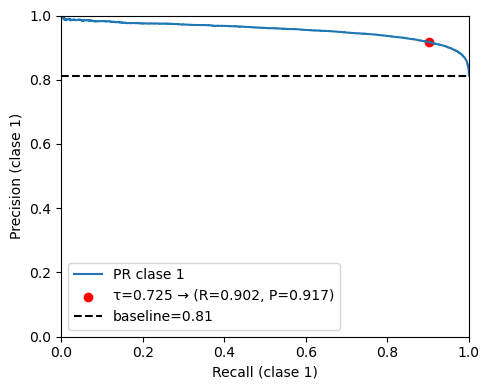

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

p1 = xgb_prec0.predict_proba(x_test40)[:,1]
prec, rec, thr = precision_recall_curve(y_test40, p1)

TAU = 0.725
y_hat = (p1 >= TAU).astype(int)
from sklearn.metrics import precision_score, recall_score
prec_tau = precision_score(y_test40, y_hat, pos_label=1)
rec_tau  = recall_score(y_test40, y_hat,  pos_label=1)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, label="PR clase 1")
plt.scatter([rec_tau], [prec_tau], c="r", label=f"τ={TAU} → (R={rec_tau:.3f}, P={prec_tau:.3f})")
plt.hlines(y_test40.mean(), 0, 1, linestyles="--", color="k", label=f"baseline={y_test40.mean():.2f}")
plt.xlim(0,1); plt.ylim(0,1); plt.xlabel("Recall (clase 1)"); plt.ylabel("Precision (clase 1)")
plt.legend(); plt.tight_layout(); plt.show()


max_atomic_mass                0.114844
min_atomic_mass                0.067512
range_atomic_mass              0.065104
formation_energy_per_atom      0.058061
electronegativity_range        0.052287
energy_above_hull              0.049408
density                        0.046156
n_elements                     0.044137
avg_atomic_mass                0.044047
avg_electronegativity          0.042387
nsites                         0.040655
volume_per_atom                0.039442
crystal_system_Hexagonal       0.038036
avg_atomic_radius              0.037735
spacegroup_number              0.037572
crystal_system_Tetragonal      0.036833
volume                         0.034418
crystal_system_Cubic           0.033566
crystal_system_Trigonal        0.032615
crystal_system_Monoclinic      0.030095
crystal_system_Triclinic       0.029116
crystal_system_Orthorhombic    0.025975
dtype: float32


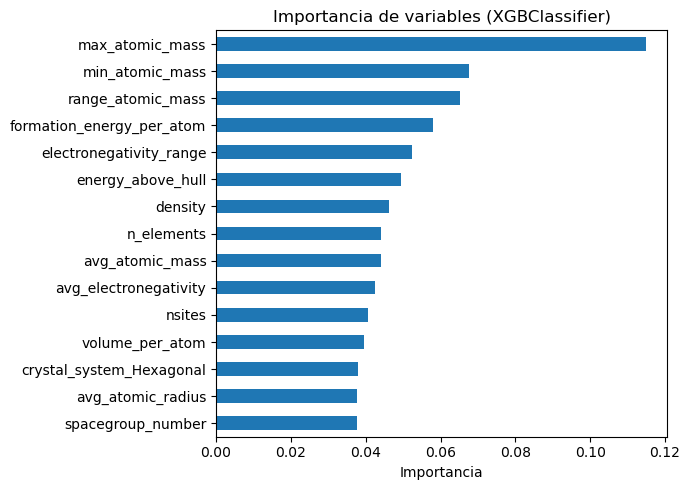

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

# Obtener importancias de las features
importances = xgb_prec0.feature_importances_
features = x_test.columns  # o xgb_prec0.get_booster().feature_names si las columnas no coinciden

# Crear un DataFrame ordenado
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
print(feat_imp)

# Gráfico de barras de las 15 más importantes
feat_imp.head(15).plot(kind='barh', figsize=(7,5))
plt.gca().invert_yaxis()
plt.title("Importancia de variables (XGBClassifier)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

Porcentaje de valores True/False en y_data_is_photovoltaic:
is_photovoltaic
False    68.110198
True     31.889802
Name: proportion, dtype: float64


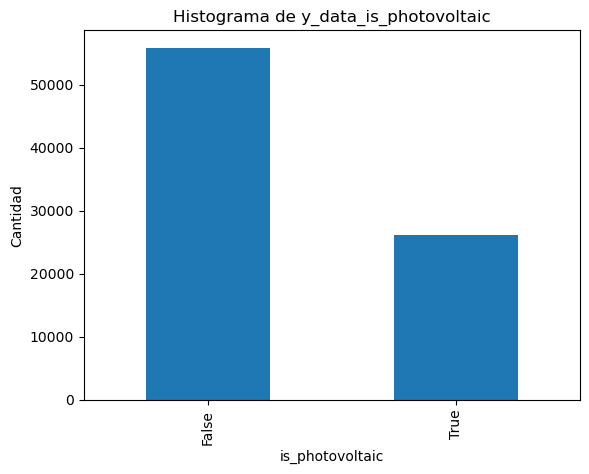

Número de valores nulos en y_data_is_photovoltaic: 0


In [ ]:
# Porcentaje de True/False en y_data_is_photovoltaic
porcentaje = y_data_is_photovoltaic.value_counts(normalize=True) * 100
print("Porcentaje de valores True/False en y_data_is_photovoltaic:")
print(porcentaje)

# Histograma (barras) de y_data_is_photovoltaic
y_data_is_photovoltaic.value_counts().plot(kind='bar')
plt.title("Histograma de y_data_is_photovoltaic")
plt.xlabel("is_photovoltaic")
plt.ylabel("Cantidad")
plt.show()

# Comprobar si hay nulos
nulos = y_data_is_photovoltaic.isnull().sum()
print(f"Número de valores nulos en y_data_is_photovoltaic: {nulos}")

In [ ]:
x_train40_PH, x_test40_PH, y_train40_PH, y_test40_PH = train_test_split(
    X_data.drop(columns=['max_atomic_mass','min_atomic_mass']), y_data_is_photovoltaic, test_size=0.5,  random_state=42)

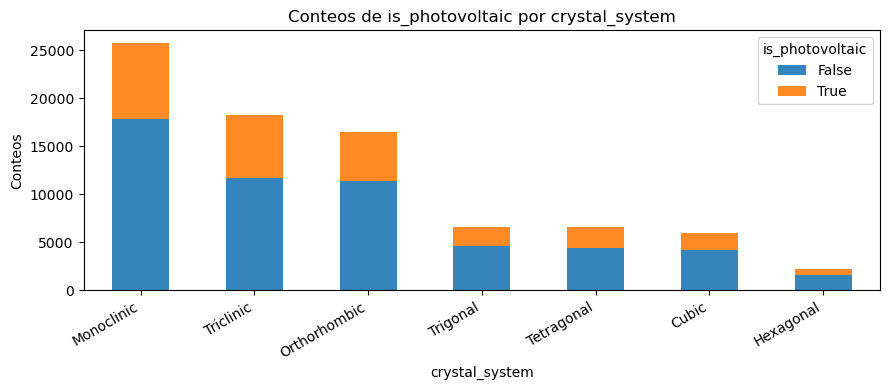

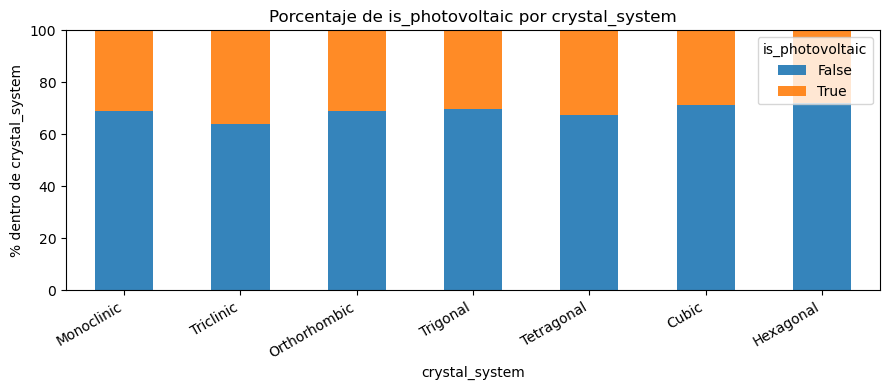

In [667]:
# Histograma (barras apiladas) de crystal_system vs is_photovoltaic usando 'data'

# 1) Tabla de conteos
df_plot = data[["crystal_system", "is_photovoltaic"]].dropna()
ctab = pd.crosstab(df_plot["crystal_system"], df_plot["is_photovoltaic"])

# ordenar por total descendente
order = ctab.sum(axis=1).sort_values(ascending=False).index
ctab = ctab.loc[order]

# 2) Conteos
ax = ctab.plot(kind="bar", stacked=True, figsize=(9, 4), alpha=0.9)
ax.set_xlabel("crystal_system")
ax.set_ylabel("Conteos")
ax.set_title("Conteos de is_photovoltaic por crystal_system")
ax.legend(title="is_photovoltaic")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# 3) Porcentajes por sistema cristalino
pct = ctab.div(ctab.sum(axis=1), axis=0) * 100.0
ax = pct.plot(kind="bar", stacked=True, figsize=(9, 4), alpha=0.9)
ax.set_xlabel("crystal_system")
ax.set_ylabel("% dentro de crystal_system")
ax.set_title("Porcentaje de is_photovoltaic por crystal_system")
ax.legend(title="is_photovoltaic", loc="upper right")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

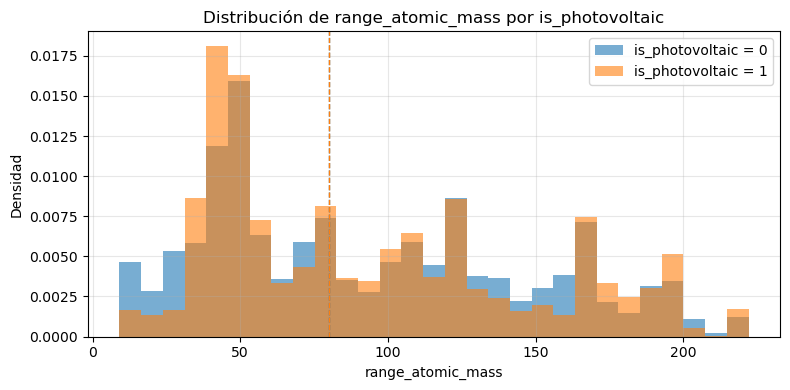

In [669]:
# Histograma de range_atomic_mass por clase de is_photovoltaic

# 1) Preparar datos alineados y limpios
df_hist = pd.DataFrame({
    "range_atomic_mass": X_data["range_atomic_mass"],
    "is_photovoltaic": y_data_is_photovoltaic.astype(bool)
}).replace([np.inf, -np.inf], np.nan).dropna()

# 2) Definir bins comunes (recortando outliers al 1% y 99%)
q1, q99 = df_hist["range_atomic_mass"].quantile([0.01, 0.99])
bins = np.linspace(q1, q99, 30)

# 3) Histograma superpuesto (densidad)
plt.figure(figsize=(8, 4))
plt.hist(
    df_hist.loc[~df_hist["is_photovoltaic"], "range_atomic_mass"],
    bins=bins, density=True, alpha=0.6, label="is_photovoltaic = 0"
)
plt.hist(
    df_hist.loc[df_hist["is_photovoltaic"], "range_atomic_mass"],
    bins=bins, density=True, alpha=0.6, label="is_photovoltaic = 1"
)

# Medianas por clase (líneas verticales)
m0 = df_hist.loc[~df_hist["is_photovoltaic"], "range_atomic_mass"].median()
m1 = df_hist.loc[df_hist["is_photovoltaic"], "range_atomic_mass"].median()
plt.axvline(m0, color="C0", linestyle="--", linewidth=1)
plt.axvline(m1, color="C1", linestyle="--", linewidth=1)

plt.xlabel("range_atomic_mass")
plt.ylabel("Densidad")
plt.title("Distribución de range_atomic_mass por is_photovoltaic")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

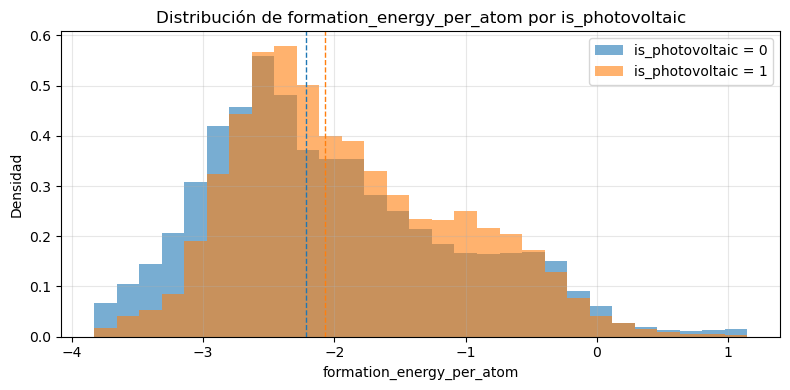

In [670]:
# Histograma de range_atomic_mass por clase de is_photovoltaic

# 1) Preparar datos alineados y limpios
df_hist = pd.DataFrame({
    "formation_energy_per_atom": X_data["formation_energy_per_atom"],
    "is_photovoltaic": y_data_is_photovoltaic.astype(bool)
}).replace([np.inf, -np.inf], np.nan).dropna()

# 2) Definir bins comunes (recortando outliers al 1% y 99%)
q1, q99 = df_hist["formation_energy_per_atom"].quantile([0.01, 0.99])
bins = np.linspace(q1, q99, 30)

# 3) Histograma superpuesto (densidad)
plt.figure(figsize=(8, 4))
plt.hist(
    df_hist.loc[~df_hist["is_photovoltaic"], "formation_energy_per_atom"],
    bins=bins, density=True, alpha=0.6, label="is_photovoltaic = 0"
)
plt.hist(
    df_hist.loc[df_hist["is_photovoltaic"], "formation_energy_per_atom"],
    bins=bins, density=True, alpha=0.6, label="is_photovoltaic = 1"
)

# Medianas por clase (líneas verticales)
m0 = df_hist.loc[~df_hist["is_photovoltaic"], "formation_energy_per_atom"].median()
m1 = df_hist.loc[df_hist["is_photovoltaic"], "formation_energy_per_atom"].median()
plt.axvline(m0, color="C0", linestyle="--", linewidth=1)
plt.axvline(m1, color="C1", linestyle="--", linewidth=1)

plt.xlabel("formation_energy_per_atom")
plt.ylabel("Densidad")
plt.title("Distribución de formation_energy_per_atom por is_photovoltaic")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Porcentaje de valores True/False en y_train40_PH:
is_photovoltaic
False    68.262641
True     31.737359
Name: proportion, dtype: float64


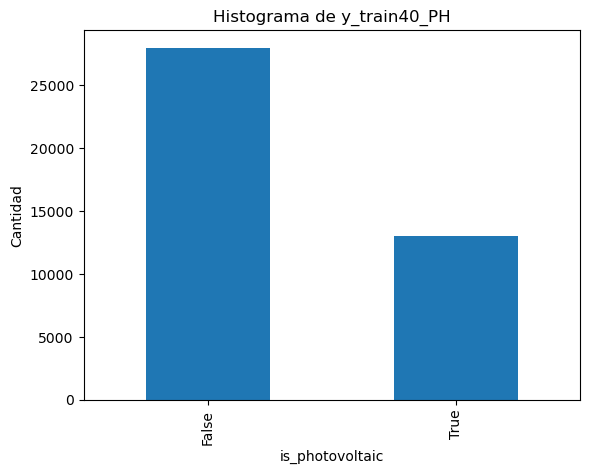

Número de valores nulos en y_train40_PH: 0


In [ ]:
# Porcentaje de True/False en y_data_is_photovoltaic
porcentaje = y_train40_PH.value_counts(normalize=True) * 100
print("Porcentaje de valores True/False en y_train40_PH:")
print(porcentaje)

# Histograma (barras) de y_train40_PH
y_train40_PH.value_counts().plot(kind='bar')
plt.title("Histograma de y_train40_PH")
plt.xlabel("is_photovoltaic")
plt.ylabel("Cantidad")
plt.show()

# Comprobar si hay nulos
nulos = y_train40_PH.isnull().sum()
print(f"Número de valores nulos en y_train40_PH: {nulos}")

In [629]:
x_train_PH, x_test_PH, y_train_PH, y_test_PH = train_test_split(x_train40_PH, y_train40_PH, 
                                                                test_size=0.2,  random_state=42)

In [630]:
# ================== CONFIG ==================
RANDOM_STATE = 42
USE_GPU  = True                # False si no tienes CUDA
N_ITER   = 30                  # nº de combinaciones aleatorias de hiperparámetros

# ---- Pesos "a mano" por clase ----
W0 = 1                       # peso clase 0
W1 = 3                       # peso clase 1 (↑ -> suele subir F1_1/recall_1)
USE_BALANCED_BASE = True       # parte de weights balanceados y multiplica por W0/W1

# ================== IMPORTS ==================
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

# ================== 0) Split interno de validación ==================
# Si ya tienes X_tr_PH/x_val_PH creados, comenta este bloque y usa los tuyos.
X_tr_PH, X_val_PH, y_tr_PH, y_val_PH = train_test_split(
    x_train_PH, y_train_PH, test_size=0.20, stratify=y_train_PH, random_state=RANDOM_STATE
)

# ================== 1) Pesos por muestra ==================
if USE_BALANCED_BASE:
    sw_tr = compute_sample_weight("balanced", y_tr_PH).astype(float)
    sw_tr[y_tr_PH == 0] *= W0
    sw_tr[y_tr_PH == 1] *= W1
else:
    sw_tr = np.where(y_tr_PH == 1, W1, W0).astype(float)

print(f"Peso medio efectivo -> clase0: {sw_tr[y_tr_PH==0].mean():.3f} | clase1: {sw_tr[y_tr_PH==1].mean():.3f}")

# ================== 2) Búsqueda MANUAL (sin CV) max F1_1 en validación ==================
rng = np.random.default_rng(RANDOM_STATE)

def sample_params(rng):
    return {
        "n_estimators":     int(rng.integers(300, 1201)),
        "max_depth":        int(rng.integers(3, 15)),
        "learning_rate":    float(rng.uniform(0.01, 0.20)),
        "subsample":        float(rng.uniform(0.6, 1.0)),
        "colsample_bytree": float(rng.uniform(0.6, 1.0)),
        "min_child_weight": int(rng.integers(1, 12)),
        "gamma":            float(np.exp(rng.uniform(np.log(1e-8), np.log(1.0)))),
        "reg_alpha":        float(np.exp(rng.uniform(np.log(1e-8), np.log(1e-1)))),
        "reg_lambda":       float(np.exp(rng.uniform(np.log(1e-2), np.log(30.0)))),
    }

tree_method = "gpu_hist" if USE_GPU else "hist"
predictor   = "gpu_predictor" if USE_GPU else "auto"

best_f1_val, best_params, best_model = -1.0, None, None

for i in range(N_ITER):
    params = sample_params(rng)
    model = XGBClassifier(
        **params,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        tree_method=tree_method,
        predictor=predictor,
    )
    model.fit(X_tr_PH, y_tr_PH, sample_weight=sw_tr)

    # F1 de la clase 1 en VALIDACIÓN (umbral 0.5)
    y_val_pred = model.predict(X_val_PH)
    f1_1 = f1_score(y_val_PH, y_val_pred, pos_label=1)

    if f1_1 > best_f1_val:
        best_f1_val, best_params, best_model = f1_1, params, model

print("\n== Mejores hiperparámetros (holdout, max F1 clase 1) ==")
print(best_params)
print(f"Mejor F1_1 en VALIDACIÓN: {best_f1_val:.4f}")

# ================== 3) Evaluación con el mejor modelo ==================
# -- VALIDACIÓN (referencia sin umbrales; corte 0.5)
y_val_pred = best_model.predict(X_val_PH)
print("\n== VALIDACIÓN PH (corte 0.5) ==")
print("CM [[TN, FP],[FN, TP]]:\n", confusion_matrix(y_val_PH, y_val_pred))
print(classification_report(y_val_PH, y_val_pred, digits=3))

# -- TEST (conjunto externo), también a 0.5
y_test_pred = best_model.predict(x_test_PH)
print("\n== TEST PH (corte 0.5) ==")
print("CM [[TN, FP],[FN, TP]]:\n", confusion_matrix(y_test_PH, y_test_pred))
print(classification_report(y_test_PH, y_test_pred, digits=3))

# ================== 4) Probabilidades para umbrales (para tu siguiente paso) ==================
p_val_PH  = best_model.predict_proba(X_val_PH)[:, 1]
p_test_PH = best_model.predict_proba(x_test_PH)[:, 1]

# (quedan en memoria: X_val_PH, y_val_PH, p_val_PH) -> perfectos para barrer τ después.


Peso medio efectivo -> clase0: 0.733 | clase1: 4.718


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tr


== Mejores hiperparámetros (holdout, max F1 clase 1) ==
{'n_estimators': 1113, 'max_depth': 12, 'learning_rate': 0.04358682875845403, 'subsample': 0.9426457136369502, 'colsample_bytree': 0.903407811934084, 'min_child_weight': 7, 'gamma': 0.005697753382373075, 'reg_alpha': 1.0584035270261982e-05, 'reg_lambda': 1.5178501688615549}
Mejor F1_1 en VALIDACIÓN: 0.6464

== VALIDACIÓN PH (corte 0.5) ==
CM [[TN, FP],[FN, TP]]:
 [[3270 1204]
 [ 515 1571]]
              precision    recall  f1-score   support

       False      0.864     0.731     0.792      4474
        True      0.566     0.753     0.646      2086

    accuracy                          0.738      6560
   macro avg      0.715     0.742     0.719      6560
weighted avg      0.769     0.738     0.746      6560


== TEST PH (corte 0.5) ==
CM [[TN, FP],[FN, TP]]:
 [[4071 1546]
 [ 670 1913]]
              precision    recall  f1-score   support

       False      0.859     0.725     0.786      5617
        True      0.553     0.741  

crystal_system_Trigonal        0.069687
range_atomic_mass              0.068872
crystal_system_Tetragonal      0.068763
formation_energy_per_atom      0.060364
density                        0.057109
n_elements                     0.054810
electronegativity_range        0.052898
avg_atomic_radius              0.049346
energy_above_hull              0.048850
volume_per_atom                0.048729
avg_atomic_mass                0.048129
nsites                         0.047998
avg_electronegativity          0.047935
crystal_system_Orthorhombic    0.046723
spacegroup_number              0.045968
crystal_system_Hexagonal       0.045484
volume                         0.042713
crystal_system_Monoclinic      0.034803
crystal_system_Cubic           0.031641
crystal_system_Triclinic       0.029178
dtype: float32


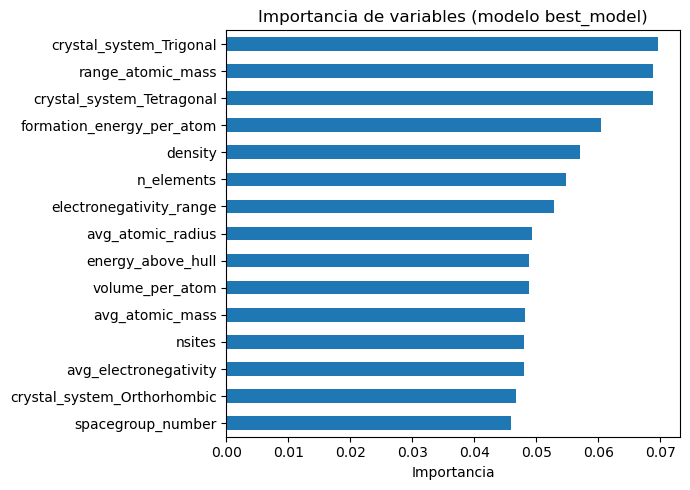

In [693]:


# Obtener importancias de las features de
importances = best_model.feature_importances_
features = x_test_PH.columns
# Crear un DataFrame
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
print(feat_imp)

# Gráfico de barras de las 15 más importantes
feat_imp.head(15).plot(kind='barh', figsize=(7, 5))
plt.gca().invert_yaxis()
plt.title("Importancia de variables (modelo best_model)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

In [632]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, accuracy_score,
    classification_report
)

# ===== parámetros de las cotas =====
MIN_F1_0 = 0.80
MIN_F1_1 = 0.60

# ===== Probabilidades (recalcula si no existen) =====
try:
    p_val_PH
except NameError:
    p_val_PH  = best_model.predict_proba(X_val_PH)[:, 1].astype(float)
try:
    p_test_PH
except NameError:
    p_test_PH = best_model.predict_proba(x_test_PH)[:, 1].astype(float)

y_val = y_val_PH.astype(int)
y_test = y_test_PH.astype(int)

def thresholds_table(y_true, p1):
    """Tabla con TODOS los umbrales efectivos y métricas por τ."""
    u = np.sort(np.unique(p1))
    taus = np.r_[0.0, (u[:-1] + u[1:]) / 2.0, 1.0]  # extremos + puntos medios
    rows = []
    for t in taus:
        y_hat = (p1 >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        rows.append({
            "tau": float(t),
            "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp),
            "precision_0": precision_score(y_true, y_hat, pos_label=0, zero_division=0),
            "recall_0":    recall_score(y_true,  y_hat, pos_label=0),
            "f1_0":        f1_score(y_true,     y_hat, pos_label=0, zero_division=0),
            "precision_1": precision_score(y_true, y_hat, pos_label=1, zero_division=0),
            "recall_1":    recall_score(y_true,  y_hat, pos_label=1),
            "f1_1":        f1_score(y_true,      y_hat, pos_label=1, zero_division=0),
            "accuracy":    accuracy_score(y_true, y_hat),
        })
    return pd.DataFrame(rows).sort_values("tau").reset_index(drop=True)

# ===== 1) Tabla completa en VALIDACIÓN =====
tab_val = thresholds_table(y_val, p_val_PH)

# Candidatos que cumplen las dos cotas
feasible = tab_val.query("f1_0 >= @MIN_F1_0 and f1_1 >= @MIN_F1_1").copy()
print(f"Umbrales factibles en VALIDACIÓN (F1_0≥{MIN_F1_0}, F1_1≥{MIN_F1_1}): {len(feasible)}")

if len(feasible) > 0:
    # Ordena: primero F1_0, luego F1_1, luego accuracy (por si hay empates)
    feasible = feasible.sort_values(["f1_0", "f1_1", "accuracy"], ascending=False)
    print("\nTOP-10 factibles (VALIDACIÓN):")
    print(feasible.head(10))

    # τ elegido: max F1_0 (tie-break F1_1, luego accuracy)
    tau_star = float(feasible.iloc[0]["tau"])
    print(f"\nτ* elegido (por VALIDACIÓN): {tau_star:.6f}  "
          f"| F1_0={feasible.iloc[0]['f1_0']:.3f}  F1_1={feasible.iloc[0]['f1_1']:.3f}")
else:
    # No hay τ que cumpla ambas cotas: elige el "más cercano" (mínima suma de déficits)
    tab_val["deficit"] = np.maximum(0, MIN_F1_0 - tab_val["f1_0"]) + np.maximum(0, MIN_F1_1 - tab_val["f1_1"])
    tau_star = float(tab_val.loc[tab_val["deficit"].idxmin(), "tau"])
    row = tab_val.loc[tab_val["deficit"].idxmin()]
    print("\n[AVISO] No hay τ que cumpla ambas cotas.")
    print("Elijo el τ con menor déficit total respecto a las cotas:")
    print(f"τ*≈{tau_star:.6f} | F1_0={row['f1_0']:.3f} (cota {MIN_F1_0}) | F1_1={row['f1_1']:.3f} (cota {MIN_F1_1})")

# ===== 2) Evaluación en VALIDACIÓN y en TEST con τ* =====
def eval_with_tau(y_true, p1, name, tau):
    y_hat = (p1 >= tau).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    print(f"\n== {name} con τ={tau:.6f} ==")
    print(f"CM [[TN, FP],[FN, TP]] = [[{tn} {fp}],[{fn} {tp}]]")
    print(classification_report(y_true, y_hat, digits=3))
    print("F1_0:", f1_score(y_true, y_hat, pos_label=0, zero_division=0),
          "| F1_1:", f1_score(y_true, y_hat, pos_label=1, zero_division=0))

eval_with_tau(y_val,  p_val_PH,  "VALIDACIÓN", tau_star)
eval_with_tau(y_test, p_test_PH, "TEST",       tau_star)

# ===== 3) (Opcional) guardar CSV de factibles y tabla completa =====
feasible.to_csv("umbrales_VAL_factibles.csv", index=False) if len(feasible)>0 else None
tab_val.to_csv("umbrales_VAL_completo.csv", index=False)
print("\nGuardados: umbrales_VAL_completo.csv", "| umbrales_VAL_factibles.csv" if len(feasible)>0 else "")


Umbrales factibles en VALIDACIÓN (F1_0≥0.8, F1_1≥0.6): 1014

TOP-10 factibles (VALIDACIÓN):
           tau    TN   FP   FN    TP  precision_0  recall_0      f1_0  \
4921  0.756672  3957  517  967  1119     0.803615  0.884443  0.842094   
4926  0.758417  3959  515  970  1116     0.803206  0.884890  0.842072   
4924  0.758133  3958  516  969  1117     0.803329  0.884667  0.842038   
4917  0.756109  3955  519  965  1121     0.803862  0.883996  0.842027   
4922  0.757193  3957  517  968  1118     0.803452  0.884443  0.842004   
4927  0.758548  3959  515  971  1115     0.803043  0.884890  0.841982   
4920  0.756619  3956  518  967  1119     0.803575  0.884220  0.841971   
4925  0.758227  3958  516  970  1116     0.803166  0.884667  0.841949   
4918  0.756370  3955  519  966  1120     0.803698  0.883996  0.841937   
4923  0.757913  3957  517  969  1117     0.803289  0.884443  0.841915   

      precision_1  recall_1      f1_1  accuracy  
4921     0.683985  0.536433  0.601290  0.773780  
4926

In [633]:
import os, pandas as pd

# (opcional) comprueba dónde estás y qué archivos hay
print("cwd:", os.getcwd())
print("CSV en la carpeta:", [f for f in os.listdir() if f.endswith(".csv")])

# lee los CSV de umbrales
tab_val  = pd.read_csv("umbrales_VAL_completo.csv")
tab_test = pd.read_csv("umbrales_VAL_factibles.csv")  # si lo generaste

# echa un vistazo
print("\nVALIDACIÓN:")
display(tab_val.head(10))

cwd: c:\Users\sevas\Desktop\CIENCIA DE DATOS\uni\maching learning
CSV en la carpeta: ['tabla_umbral_validacion.csv', 'umbrales_precision_recall0_val.csv', 'umbrales_TEST_best_model.csv', 'umbrales_VAL_best_model.csv', 'umbrales_VAL_completo.csv', 'umbrales_VAL_factibles.csv']

VALIDACIÓN:


tau  TN    FP  FN    TP  precision_0  recall_0      f1_0  precision_1  \
0  0.000000   0  4474   0  2086          0.0  0.000000  0.000000     0.317988   
1  0.000110   1  4473   0  2086          1.0  0.000224  0.000447     0.318036   
2  0.000156   2  4472   0  2086          1.0  0.000447  0.000894     0.318085   
3  0.000161   3  4471   0  2086          1.0  0.000671  0.001340     0.318133   
4  0.000176   4  4470   0  2086          1.0  0.000894  0.001787     0.318182   
5  0.000193   5  4469   0  2086          1.0  0.001118  0.002233     0.318230   
6  0.000222   6  4468   0  2086          1.0  0.001341  0.002679     0.318279   
7  0.000253   7  4467   0  2086          1.0  0.001565  0.003124     0.318327   
8  0.000260   8  4466   0  2086          1.0  0.001788  0.003570     0.318376   
9  0.000274   9  4465   0  2086          1.0  0.002012  0.004015     0.318425   

   recall_1      f1_1  accuracy  
0       1.0  0.482535  0.317988  
1       1.0  0.482591  0.318140  
2       1.0  0.482647  0.318293  
3       1.0  0.482703  0.318445  
4       1.0  0.482759  0.318598  
5       1.0  0.482814  0.318750  
6       1.0  0.482870  0.318902  
7       1.0  0.482926  0.319055  
8       1.0  0.482982  0.319207  
9       1.0  0.483038  0.319360

In [662]:
filtered = tab_val[(tab_val["f1_0"] > 0.82
                    ) & (tab_val["precision_1"] > 0.61)]
print(filtered)

           tau    TN   FP    FN    TP  precision_0  recall_0      f1_0  \
4257  0.613153  3581  893   679  1407     0.840610  0.800402  0.820014   
4266  0.615003  3585  889   684  1402     0.839775  0.801296  0.820085   
4268  0.615545  3586  888   685  1401     0.839616  0.801520  0.820126   
4269  0.615900  3587  887   685  1401     0.839654  0.801743  0.820261   
4270  0.616214  3588  886   685  1401     0.839691  0.801967  0.820396   
...        ...   ...  ...   ...   ...          ...       ...       ...   
6403  0.981938  4464   10  1945   141     0.696521  0.997765  0.820362   
6404  0.982048  4464   10  1946   140     0.696412  0.997765  0.820287   
6405  0.982176  4464   10  1947   139     0.696303  0.997765  0.820211   
6406  0.982256  4464   10  1948   138     0.696195  0.997765  0.820136   
6407  0.982289  4464   10  1949   137     0.696086  0.997765  0.820061   

      precision_1  recall_1      f1_1  accuracy  
4257     0.611739  0.674497  0.641587  0.760366  
4266     0.

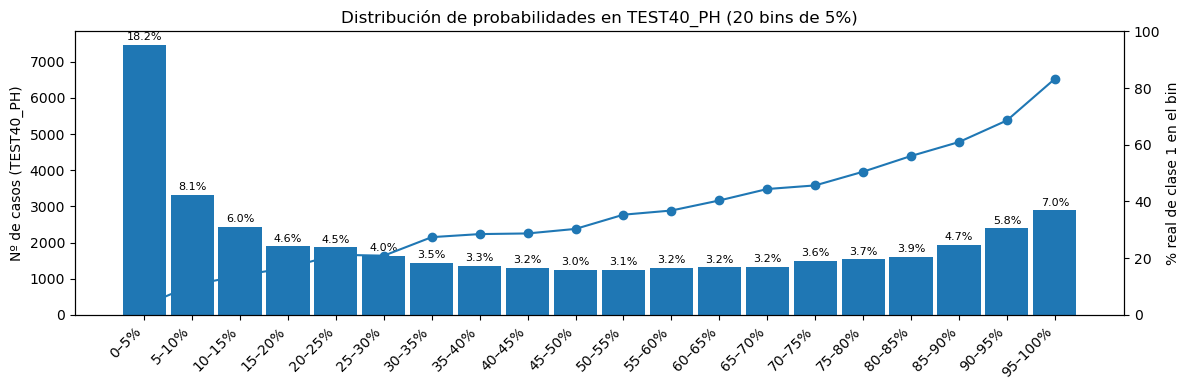

      bin  total  pct_total  avg_proba  positivos  pct_pos_real
0    0–5%   7468  18.215078   0.018741        246      3.294055
1   5–10%   3323   8.105076   0.073525        348     10.472465
2  10–15%   2441   5.953804   0.124320        339     13.887751
3  15–20%   1895   4.622064   0.173760        315     16.622691
4  20–25%   1863   4.544013   0.224996        395     21.202362
5  25–30%   1634   3.985463   0.274314        341     20.869033
6  30–35%   1441   3.514720   0.325118        395     27.411520
7  35–40%   1348   3.287885   0.374702        384     28.486647
8  40–45%   1306   3.185444   0.424720        375     28.713629
9  45–50%   1237   3.017147   0.474557        375     30.315279

ROC-AUC: 0.813 | PR-AUC (clase 1): 0.674 | PR-AUC (clase 0): 0.901
Brier: 0.1831 | ECE@20: 0.1171 | KS: 0.467 en τ≈0.5122


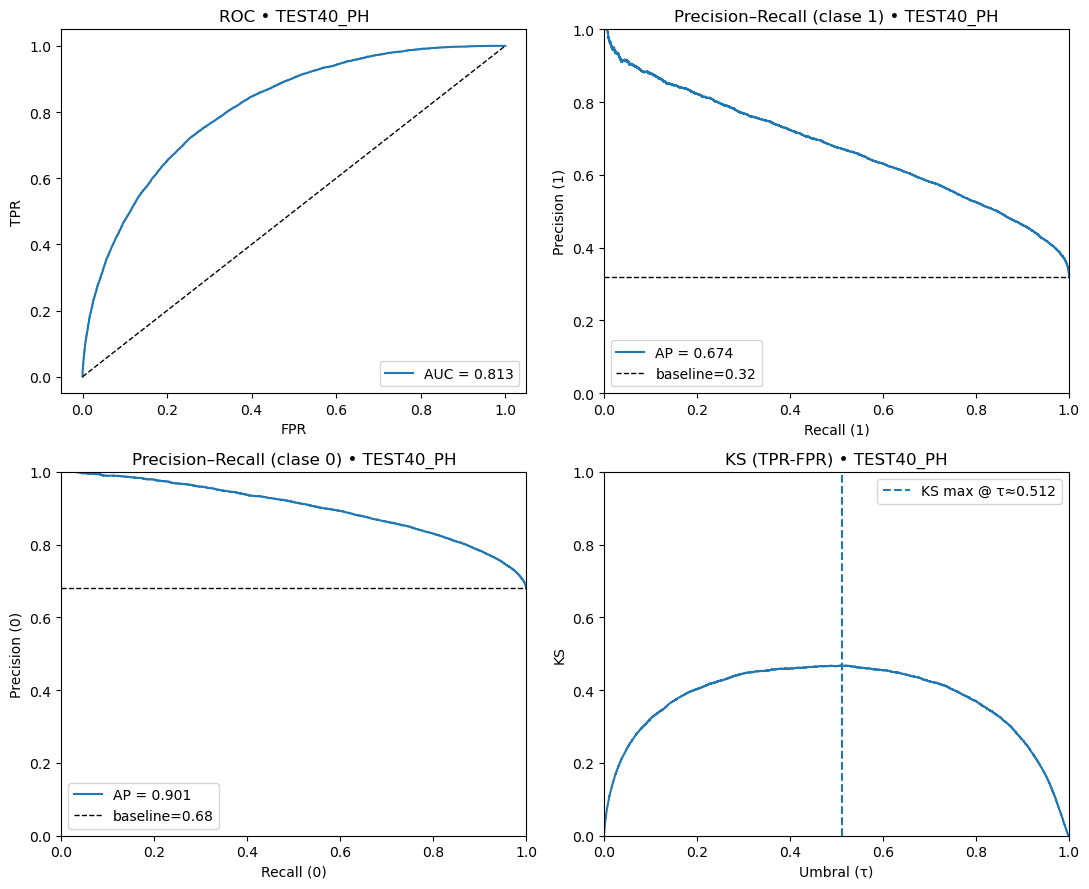

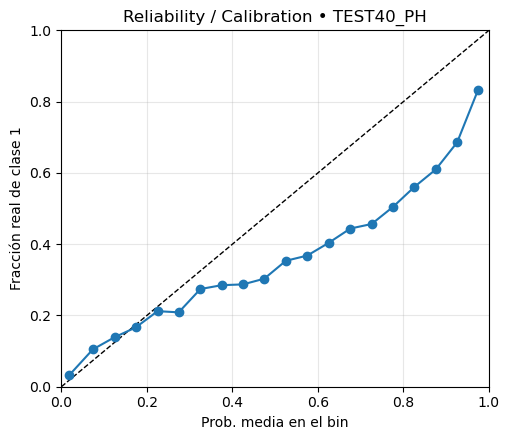

In [692]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    brier_score_loss, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.calibration import calibration_curve

# ====== 0) Modelo y datos no vistos ======
model = best_model              # <- ya creado por ti
X = x_test40_PH                 # datos nunca vistos
p1 = model.predict_proba(X)[:, 1]   # P(y=1|x) en TEST40_PH

# ====== 1) Distribución de probabilidades en 20 bins (5%) ======
def dist_table_and_plot(p, y_true=None, title="Distribución de probabilidades en TEST40_PH (20 bins)"):
    bins = np.linspace(0, 1, 21)                    # 20 bins
    idx  = np.clip(np.digitize(p, bins) - 1, 0, 19) # índice de bin 0..19

    total = np.array([(idx == i).sum() for i in range(20)])
    pct_total = 100 * total / max(1, len(p))
    avg_proba = np.array([p[idx == i].mean() if (idx == i).any() else np.nan for i in range(20)])
    labels = [f"{int(bins[i]*100)}–{int(bins[i+1]*100)}%" for i in range(20)]

    if y_true is not None:
        pos = np.array([y_true[idx == i].sum() if (idx == i).any() else 0 for i in range(20)])
        pct_pos_real = np.where(total > 0, 100 * pos / total, np.nan)
    else:
        pos = np.full(20, np.nan)
        pct_pos_real = np.full(20, np.nan)

    # Tabla
    tab = pd.DataFrame({
        "bin": labels,
        "total": total,
        "pct_total": pct_total,
        "avg_proba": avg_proba,
        "positivos": pos,
        "pct_pos_real": pct_pos_real
    })

    # Gráfico
    fig, ax = plt.subplots(figsize=(12, 4))
    x = np.arange(20)
    bars = ax.bar(x, total, width=0.9)
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("Nº de casos (TEST40_PH)")
    ax.set_title(title)

    bump = max(total)*0.01 if len(total) and max(total)>0 else 0.1
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()+bump, f"{pct_total[i]:.1f}%",
                ha="center", va="bottom", fontsize=8)

    if y_true is not None:
        ax2 = ax.twinx()
        ax2.plot(x, pct_pos_real, marker="o")
        ax2.set_ylim(0, 100)
        ax2.set_ylabel("% real de clase 1 en el bin")

    plt.tight_layout(); plt.show()
    return tab

# Si tienes y_test40_PH, pásala para ver el % real por bin
try:
    tab40 = dist_table_and_plot(p1, y_true=y_test40_PH,
                                title="Distribución de probabilidades en TEST40_PH (20 bins de 5%)")
except NameError:
    tab40 = dist_table_and_plot(p1, y_true=None,
                                title="Distribución de probabilidades en TEST40_PH (20 bins de 5%)")
print(tab40.head(10))
# tab40.to_csv("dist_TEST40_PH_20bins.csv", index=False)

# ====== 2) Curvas y métricas (solo si hay y_test40_PH) ======
try:
    y = y_test40_PH.astype(int)

    # --- ROC ---
    fpr, tpr, thr_roc = roc_curve(y, p1)
    auc = roc_auc_score(y, p1)

    # --- PR clase 1 ---
    prec1, rec1, thr_pr1 = precision_recall_curve(y, p1)
    ap1 = average_precision_score(y, p1)
    base1 = y.mean()

    # --- PR clase 0 ---
    y0, p0 = 1 - y, 1 - p1
    prec0, rec0, thr_pr0 = precision_recall_curve(y0, p0)
    ap0 = average_precision_score(y0, p0)
    base0 = y0.mean()

    # --- KS ---
    ks_vals = tpr - fpr
    ks = float(np.max(ks_vals))
    ks_idx = int(np.argmax(ks_vals))
    ks_tau = float(thr_roc[ks_idx]) if np.isfinite(thr_roc[ks_idx]) else np.nan

    # --- Calibration ---
    prob_true, prob_pred = calibration_curve(y, p1, n_bins=20, strategy="uniform")
    brier = brier_score_loss(y, p1)

    # ECE@20
    bins = np.linspace(0, 1, 21)
    idxb = np.clip(np.digitize(p1, bins) - 1, 0, 19)
    bin_conf = np.array([p1[idxb==b].mean() if np.any(idxb==b) else np.nan for b in range(20)])
    bin_acc  = np.array([y[idxb==b].mean()  if np.any(idxb==b) else np.nan for b in range(20)])
    bin_cnt  = np.array([np.sum(idxb==b) for b in range(20)])
    w        = bin_cnt / np.maximum(bin_cnt.sum(), 1)
    ece      = float(np.nansum(w * np.abs(bin_conf - bin_acc)))

    print(f"\nROC-AUC: {auc:.3f} | PR-AUC (clase 1): {ap1:.3f} | PR-AUC (clase 0): {ap0:.3f}")
    print(f"Brier: {brier:.4f} | ECE@20: {ece:.4f} | KS: {ks:.3f} en τ≈{ks_tau:.4f}")

    # --- PLOTS ---
    fig, axs = plt.subplots(2, 2, figsize=(11, 9))

    # ROC
    axs[0,0].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    axs[0,0].plot([0,1],[0,1],"k--",lw=1)
    axs[0,0].set_title("ROC • TEST40_PH"); axs[0,0].set_xlabel("FPR"); axs[0,0].set_ylabel("TPR")
    axs[0,0].legend(loc="lower right")

    # PR clase 1
    axs[0,1].plot(rec1, prec1, label=f"AP = {ap1:.3f}")
    axs[0,1].hlines(base1, 0, 1, colors="k", linestyles="--", lw=1, label=f"baseline={base1:.2f}")
    axs[0,1].set_xlim(0,1); axs[0,1].set_ylim(0,1)
    axs[0,1].set_title("Precision–Recall (clase 1) • TEST40_PH")
    axs[0,1].set_xlabel("Recall (1)"); axs[0,1].set_ylabel("Precision (1)")
    axs[0,1].legend(loc="lower left")

    # PR clase 0
    axs[1,0].plot(rec0, prec0, label=f"AP = {ap0:.3f}")
    axs[1,0].hlines(base0, 0, 1, colors="k", linestyles="--", lw=1, label=f"baseline={base0:.2f}")
    axs[1,0].set_xlim(0,1); axs[1,0].set_ylim(0,1)
    axs[1,0].set_title("Precision–Recall (clase 0) • TEST40_PH")
    axs[1,0].set_xlabel("Recall (0)"); axs[1,0].set_ylabel("Precision (0)")
    axs[1,0].legend(loc="lower left")

    # KS vs τ
    mask = np.isfinite(thr_roc)
    axs[1,1].plot(thr_roc[mask], ks_vals[mask])
    axs[1,1].axvline(ks_tau, ls="--", label=f"KS max @ τ≈{ks_tau:.3f}")
    axs[1,1].set_xlim(0,1); axs[1,1].set_ylim(0,1)
    axs[1,1].set_title("KS (TPR-FPR) • TEST40_PH"); axs[1,1].set_xlabel("Umbral (τ)"); axs[1,1].set_ylabel("KS")
    axs[1,1].legend()

    plt.tight_layout(); plt.show()

    # Reliability separado
    plt.figure(figsize=(5.2,4.5))
    plt.plot([0,1],[0,1],"k--",lw=1)
    plt.plot(prob_pred, prob_true, marker="o")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.title("Reliability / Calibration • TEST40_PH")
    plt.xlabel("Prob. media en el bin"); plt.ylabel("Fracción real de clase 1")
    plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

except NameError:
    print("\n(No se encontró y_test40_PH: se pinta solo la distribución de probabilidades.)")


In [ ]:
0.616214

In [663]:
# Evaluación de best_model en x_test40_PH con umbral 0.616214
TAU = 0.616214
model = best_model  # clasificador ya entrenado para is_photovoltaic

# Probabilidades y predicción al umbral
p1 = model.predict_proba(x_test40_PH)[:, 1].astype(float)
y_true = y_test40_PH.astype(int)
y_pred_tau = (p1 >= TAU).astype(int)

# Métricas
cm = confusion_matrix(y_true, y_pred_tau)
tn, fp, fn, tp = cm.ravel()
print(f"== TEST40_PH con τ={TAU} ==")
print("CM [[TN, FP],[FN, TP]]:\n", cm)
print(classification_report(y_true, y_pred_tau, digits=3))
print(
    "accuracy:",   accuracy_score(y_true, y_pred_tau),
    "| precision_0:", precision_score(y_true, y_pred_tau, pos_label=0, zero_division=0),
    "| recall_0:",   recall_score(y_true,  y_pred_tau, pos_label=0),
    "| f1_0:",       f1_score(y_true,     y_pred_tau, pos_label=0),
    "| precision_1:", precision_score(y_true, y_pred_tau, pos_label=1, zero_division=0),
    "| recall_1:",    recall_score(y_true,  y_pred_tau, pos_label=1),
    "| f1_1:",        f1_score(y_true,      y_pred_tau, pos_label=1)
)

== TEST40_PH con τ=0.616214 ==
CM [[TN, FP],[FN, TP]]:
 [[22330  5532]
 [ 4598  8539]]
              precision    recall  f1-score   support

           0      0.829     0.801     0.815     27862
           1      0.607     0.650     0.628     13137

    accuracy                          0.753     40999
   macro avg      0.718     0.726     0.721     40999
weighted avg      0.758     0.753     0.755     40999

accuracy: 0.7529208029464133 | precision_0: 0.829248366013072 | recall_0: 0.8014500035891178 | f1_0: 0.8151122467603578 | precision_1: 0.606850970080307 | recall_1: 0.6499961939560022 | f1_1: 0.6276830344016466


== MATRIZ DE CONFUSIÓN (τ=0.616214) ==
[[4455 1162]
 [ 857 1726]]


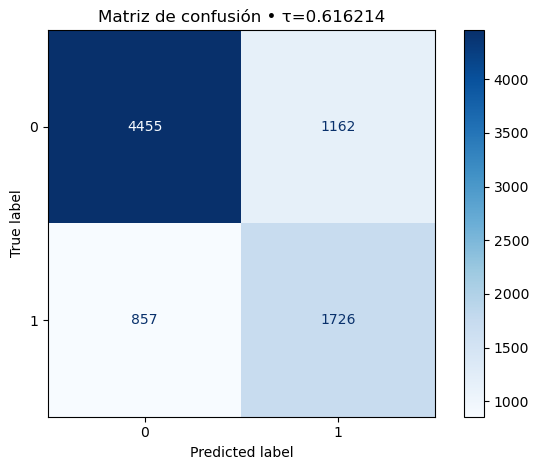

In [695]:
# Matriz de confusión con TAU=0.616214 usando best_model en TEST40_PH
TAU = 0.616214
model = best_model

# Datos
X = x_test_PH
y = y_test_PH.astype(int)

# Predicciones con umbral
p1 = model.predict_proba(X)[:, 1]
y_hat = (p1 >= TAU).astype(int)

# Matriz de confusión
cm = confusion_matrix(y, y_hat)
print(f"== MATRIZ DE CONFUSIÓN (τ={TAU}) ==")
print(cm)

# Visualización
try:
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de confusión • τ={TAU}")
    plt.tight_layout()
    plt.show()
except Exception:
    pass

# busqueda de presicion

In [ ]:
# ================== CONFIG ==================
RANDOM_STATE = 42
USE_GPU      = True          # False si no tienes CUDA
N_ITER       = 30            # nº de combinaciones aleatorias
VAL_SIZE     = 0.20          # tamaño del holdout interno

# Pesos "a mano": W0 alto penaliza FP -> suele ↑ precision_1 (con ↓ recall_1)
W0 = 1     # peso clase 0
W1 = 1.5       # peso clase 1
USE_BALANCED_BASE = True   # parte de pesos balanceados y luego multiplica por W0/W1

# ================== IMPORTS ==================
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report, confusion_matrix, f1_score, recall_score, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

# ================== DATOS: detecta _PH si existen, si no usa los genéricos ==================
def pick_data():
    # preferimos *_PH si existen
    g = globals()
    if all(k in g for k in ["x_train_PH","y_train_PH"]):
        Xtr_all, ytr_all = g["x_train_PH"], g["y_train_PH"]
        Xte, yte = g.get("x_test_PH", None), g.get("y_test_PH", None)
    else:
        Xtr_all, ytr_all = g["x_train"], g["y_train"]
        Xte, yte = g.get("x_test", None), g.get("y_test", None)
    return Xtr_all, ytr_all.astype(int), Xte, (None if yte is None else yte.astype(int))

Xall, yall, Xtest, ytest = pick_data()

# Holdout de validación (para seleccionar hiperparámetros por precision_1)
X_tr, X_val, y_tr, y_val = train_test_split(
    Xall, yall, test_size=VAL_SIZE, stratify=yall, random_state=RANDOM_STATE
)

# ================== PESOS por muestra ==================
if USE_BALANCED_BASE:
    sw_tr = compute_sample_weight("balanced", y_tr).astype(float)
else:
    sw_tr = np.ones_like(y_tr, dtype=float)
sw_tr[y_tr == 0] *= W0
sw_tr[y_tr == 1] *= W1

print(f"Peso medio efectivo -> clase0={sw_tr[y_tr==0].mean():.3f} | clase1={sw_tr[y_tr==1].mean():.3f}")

# ================== BÚSQUEDA MANUAL (SIN CV) max precision_1 ==================
rng = np.random.default_rng(RANDOM_STATE)

def sample_params():
    return {
        "n_estimators":     int(rng.integers(300, 1201)),
        "max_depth":        int(rng.integers(3, 15)),
        "learning_rate":    float(rng.uniform(0.01, 0.20)),
        "subsample":        float(rng.uniform(0.6, 1.0)),
        "colsample_bytree": float(rng.uniform(0.6, 1.0)),
        "min_child_weight": int(rng.integers(1, 12)),
        "gamma":            float(np.exp(rng.uniform(np.log(1e-8), np.log(1.0)))),
        "reg_alpha":        float(np.exp(rng.uniform(np.log(1e-8), np.log(1e-1)))),
        "reg_lambda":       float(np.exp(rng.uniform(np.log(1e-2), np.log(30.0)))),
    }

tree_method = "gpu_hist" if USE_GPU else "hist"
predictor   = "gpu_predictor" if USE_GPU else "auto"

best_prec_val, best_params, best_model = -1.0, None, None

for i in range(1, N_ITER+1):
    params = sample_params()
    model = XGBClassifier(
        **params,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        tree_method=tree_method,
        predictor=predictor
    )
    model.fit(X_tr, y_tr, sample_weight=sw_tr)

    # Precisión de la clase 1 en VALIDACIÓN (umbral 0.5)
    y_val_pred = model.predict(X_val)
    prec1 = precision_score(y_val, y_val_pred, pos_label=1, zero_division=0)

    if prec1 > best_prec_val:
        best_prec_val, best_params, best_model = prec1, params, model

    if i % 5 == 0 or i == 1:
        print(f"[{i}/{N_ITER}] precision_1(val)={prec1:.4f} | best={best_prec_val:.4f}")

print("\n== Mejores hiperparámetros (holdout, max precision_1) ==")
print(best_params)
print(f"Mejor precision_1 en VALIDACIÓN: {best_prec_val:.4f}")

# ================== EVALUACIÓN (sin umbrales; corte 0.5) ==================
print("\n== VALIDACIÓN (corte 0.5) ==")
y_val_pred = best_model.predict(X_val)
print("CM [[TN, FP],[FN, TP]]:\n", confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=3))

if Xtest is not None and ytest is not None:
    print("\n== TEST (corte 0.5) ==")
    y_test_pred = best_model.predict(Xtes   t)
    print("CM [[TN, FP],[FN, TP]]:\n", confusion_matrix(ytest, y_test_pred))
    print(classification_report(ytest, y_test_pred, digits=3))

# ================== PROBABILIDADES (para umbrales más tarde) ==================
p_val  = best_model.predict_proba(X_val)[:, 1]
p_test = None if Xtest is None else best_model.predict_proba(Xtest)[:, 1]


Peso medio efectivo -> clase0=0.732 | clase1=2.365


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tr

[1/30] precision_1(val)=0.5834 | best=0.5834


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:22] WARNING: C:\buildkite-agen

[5/30] precision_1(val)=0.6550 | best=0.6550


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:39] WARNING: C:\buildkite-agen

[10/30] precision_1(val)=0.6508 | best=0.6550


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:01] WARNING: C:\buildkite-agen

[15/30] precision_1(val)=0.6186 | best=0.6550


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:21] WARNING: C:\buildkite-agen

[20/30] precision_1(val)=0.4688 | best=0.6550


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:33] WARNING: C:\buildkite-agen

[25/30] precision_1(val)=0.6668 | best=0.6668


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:04] WARNING: C:\buildkite-agen

[30/30] precision_1(val)=0.5970 | best=0.6668

== Mejores hiperparámetros (holdout, max precision_1) ==
{'n_estimators': 1061, 'max_depth': 13, 'learning_rate': 0.179754861542594, 'subsample': 0.8075433441545796, 'colsample_bytree': 0.7263716207323172, 'min_child_weight': 1, 'gamma': 0.0019646722243942287, 'reg_alpha': 4.12671144177886e-06, 'reg_lambda': 0.021304534990083356}
Mejor precision_1 en VALIDACIÓN: 0.6668

== VALIDACIÓN (corte 0.5) ==
CM [[TN, FP],[FN, TP]]:
 [[6137 1030]
 [1268 2061]]
              precision    recall  f1-score   support

           0      0.829     0.856     0.842      7167
           1      0.667     0.619     0.642      3329

    accuracy                          0.781     10496
   macro avg      0.748     0.738     0.742     10496
weighted avg      0.777     0.781     0.779     10496


== TEST (corte 0.5) ==
CM [[TN, FP],[FN, TP]]:
 [[7583 1344]
 [1578 2615]]
              precision    recall  f1-score   support

           0      0.828     0.849     0.8

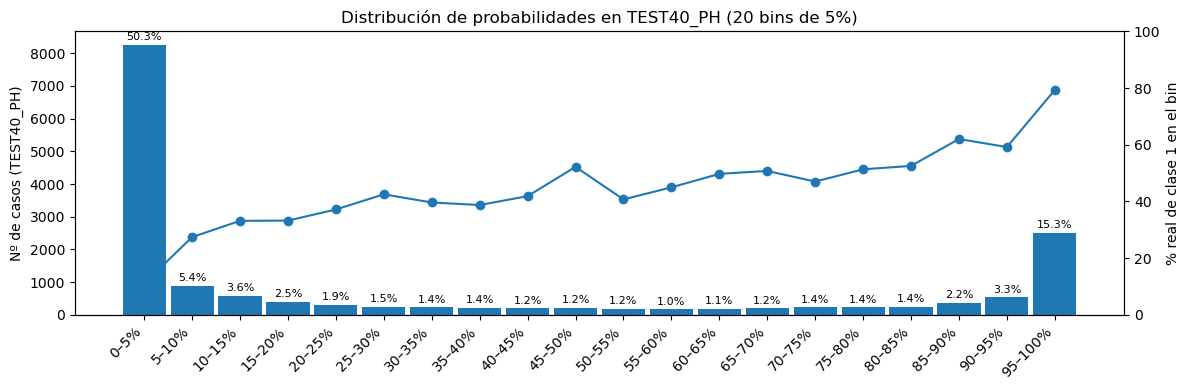

      bin  total  pct_total  avg_proba  positivos  pct_pos_real
0    0–5%   8254  50.329268   0.007410        917     11.109765
1   5–10%    886   5.402439   0.072318        243     27.426637
2  10–15%    591   3.603659   0.123117        196     33.164129
3  15–20%    406   2.475610   0.173870        135     33.251232
4  20–25%    304   1.853659   0.224357        113     37.171053
5  25–30%    247   1.506098   0.273141        105     42.510121
6  30–35%    227   1.384146   0.324946         90     39.647577
7  35–40%    222   1.353659   0.374934         86     38.738739
8  40–45%    203   1.237805   0.425923         85     41.871921
9  45–50%    205   1.250000   0.474411        107     52.195122

ROC-AUC: 0.832 | PR-AUC (clase 1): 0.710 | PR-AUC (clase 0): 0.907
Brier: 0.1794 | ECE@20: 0.1456 | KS: 0.505 en τ≈0.0926


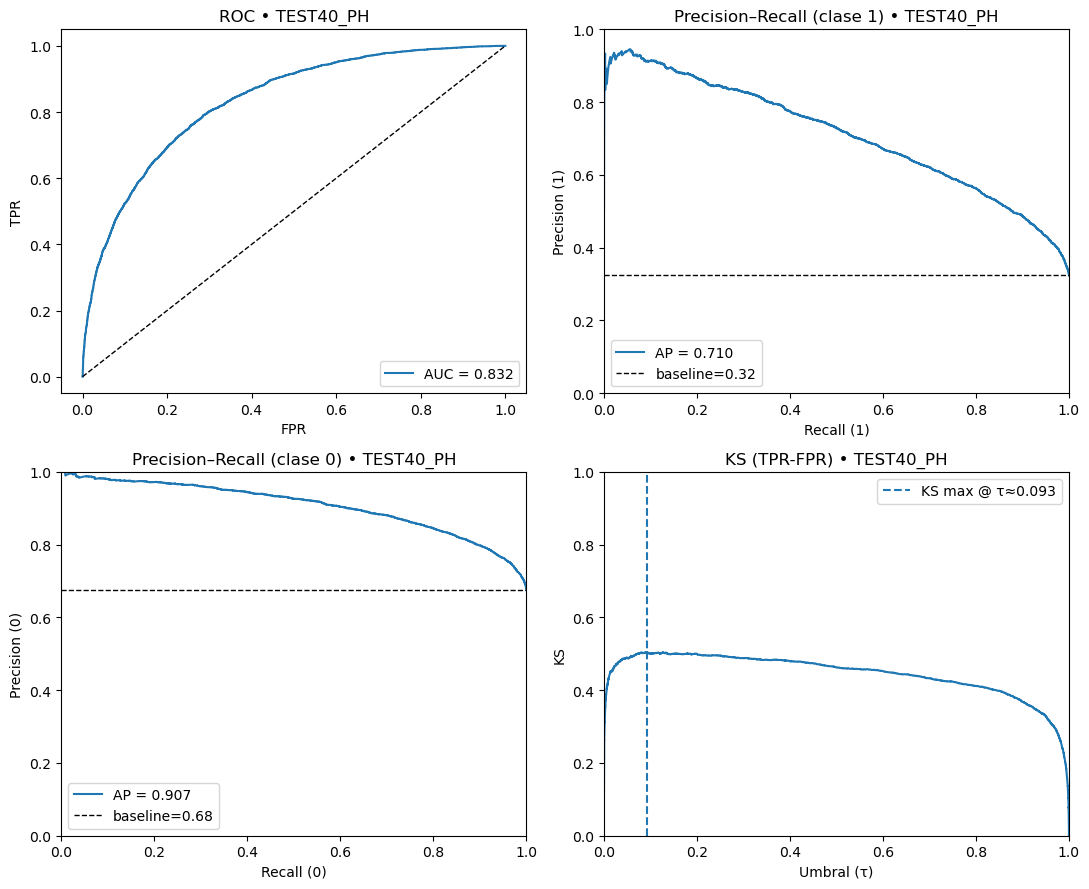

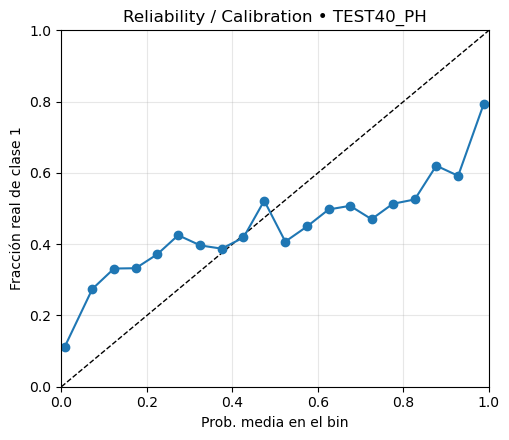

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    brier_score_loss, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.calibration import calibration_curve

# ====== 0) Modelo y datos no vistos ======
model = best_model              # <- ya creado por ti
X = x_test40_PH                 # datos nunca vistos
p1 = model.predict_proba(X)[:, 1]   # P(y=1|x) en TEST40_PH

# ====== 1) Distribución de probabilidades en 20 bins (5%) ======
def dist_table_and_plot(p, y_true=None, title="Distribución de probabilidades en TEST40_PH (20 bins)"):
    bins = np.linspace(0, 1, 21)                    # 20 bins
    idx  = np.clip(np.digitize(p, bins) - 1, 0, 19) # índice de bin 0..19

    total = np.array([(idx == i).sum() for i in range(20)])
    pct_total = 100 * total / max(1, len(p))
    avg_proba = np.array([p[idx == i].mean() if (idx == i).any() else np.nan for i in range(20)])
    labels = [f"{int(bins[i]*100)}–{int(bins[i+1]*100)}%" for i in range(20)]

    if y_true is not None:
        pos = np.array([y_true[idx == i].sum() if (idx == i).any() else 0 for i in range(20)])
        pct_pos_real = np.where(total > 0, 100 * pos / total, np.nan)
    else:
        pos = np.full(20, np.nan)
        pct_pos_real = np.full(20, np.nan)

    # Tabla
    tab = pd.DataFrame({
        "bin": labels,
        "total": total,
        "pct_total": pct_total,
        "avg_proba": avg_proba,
        "positivos": pos,
        "pct_pos_real": pct_pos_real
    })

    # Gráfico
    fig, ax = plt.subplots(figsize=(12, 4))
    x = np.arange(20)
    bars = ax.bar(x, total, width=0.9)
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("Nº de casos (TEST40_PH)")
    ax.set_title(title)

    bump = max(total)*0.01 if len(total) and max(total)>0 else 0.1
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()+bump, f"{pct_total[i]:.1f}%",
                ha="center", va="bottom", fontsize=8)

    if y_true is not None:
        ax2 = ax.twinx()
        ax2.plot(x, pct_pos_real, marker="o")
        ax2.set_ylim(0, 100)
        ax2.set_ylabel("% real de clase 1 en el bin")

    plt.tight_layout(); plt.show()
    return tab

# Si tienes y_test40_PH, pásala para ver el % real por bin
try:
    tab40 = dist_table_and_plot(p1, y_true=y_test40_PH,
                                title="Distribución de probabilidades en TEST40_PH (20 bins de 5%)")
except NameError:
    tab40 = dist_table_and_plot(p1, y_true=None,
                                title="Distribución de probabilidades en TEST40_PH (20 bins de 5%)")
print(tab40.head(10))
# tab40.to_csv("dist_TEST40_PH_20bins.csv", index=False)

# ====== 2) Curvas y métricas (solo si hay y_test40_PH) ======
try:
    y = y_test40_PH.astype(int)

    # --- ROC ---
    fpr, tpr, thr_roc = roc_curve(y, p1)
    auc = roc_auc_score(y, p1)

    # --- PR clase 1 ---
    prec1, rec1, thr_pr1 = precision_recall_curve(y, p1)
    ap1 = average_precision_score(y, p1)
    base1 = y.mean()

    # --- PR clase 0 ---
    y0, p0 = 1 - y, 1 - p1
    prec0, rec0, thr_pr0 = precision_recall_curve(y0, p0)
    ap0 = average_precision_score(y0, p0)
    base0 = y0.mean()

    # --- KS ---
    ks_vals = tpr - fpr
    ks = float(np.max(ks_vals))
    ks_idx = int(np.argmax(ks_vals))
    ks_tau = float(thr_roc[ks_idx]) if np.isfinite(thr_roc[ks_idx]) else np.nan

    # --- Calibration ---
    prob_true, prob_pred = calibration_curve(y, p1, n_bins=20, strategy="uniform")
    brier = brier_score_loss(y, p1)

    # ECE@20
    bins = np.linspace(0, 1, 21)
    idxb = np.clip(np.digitize(p1, bins) - 1, 0, 19)
    bin_conf = np.array([p1[idxb==b].mean() if np.any(idxb==b) else np.nan for b in range(20)])
    bin_acc  = np.array([y[idxb==b].mean()  if np.any(idxb==b) else np.nan for b in range(20)])
    bin_cnt  = np.array([np.sum(idxb==b) for b in range(20)])
    w        = bin_cnt / np.maximum(bin_cnt.sum(), 1)
    ece      = float(np.nansum(w * np.abs(bin_conf - bin_acc)))

    print(f"\nROC-AUC: {auc:.3f} | PR-AUC (clase 1): {ap1:.3f} | PR-AUC (clase 0): {ap0:.3f}")
    print(f"Brier: {brier:.4f} | ECE@20: {ece:.4f} | KS: {ks:.3f} en τ≈{ks_tau:.4f}")

    # --- PLOTS ---
    fig, axs = plt.subplots(2, 2, figsize=(11, 9))

    # ROC
    axs[0,0].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    axs[0,0].plot([0,1],[0,1],"k--",lw=1)
    axs[0,0].set_title("ROC • TEST40_PH"); axs[0,0].set_xlabel("FPR"); axs[0,0].set_ylabel("TPR")
    axs[0,0].legend(loc="lower right")

    # PR clase 1
    axs[0,1].plot(rec1, prec1, label=f"AP = {ap1:.3f}")
    axs[0,1].hlines(base1, 0, 1, colors="k", linestyles="--", lw=1, label=f"baseline={base1:.2f}")
    axs[0,1].set_xlim(0,1); axs[0,1].set_ylim(0,1)
    axs[0,1].set_title("Precision–Recall (clase 1) • TEST40_PH")
    axs[0,1].set_xlabel("Recall (1)"); axs[0,1].set_ylabel("Precision (1)")
    axs[0,1].legend(loc="lower left")

    # PR clase 0
    axs[1,0].plot(rec0, prec0, label=f"AP = {ap0:.3f}")
    axs[1,0].hlines(base0, 0, 1, colors="k", linestyles="--", lw=1, label=f"baseline={base0:.2f}")
    axs[1,0].set_xlim(0,1); axs[1,0].set_ylim(0,1)
    axs[1,0].set_title("Precision–Recall (clase 0) • TEST40_PH")
    axs[1,0].set_xlabel("Recall (0)"); axs[1,0].set_ylabel("Precision (0)")
    axs[1,0].legend(loc="lower left")

    # KS vs τ
    mask = np.isfinite(thr_roc)
    axs[1,1].plot(thr_roc[mask], ks_vals[mask])
    axs[1,1].axvline(ks_tau, ls="--", label=f"KS max @ τ≈{ks_tau:.3f}")
    axs[1,1].set_xlim(0,1); axs[1,1].set_ylim(0,1)
    axs[1,1].set_title("KS (TPR-FPR) • TEST40_PH"); axs[1,1].set_xlabel("Umbral (τ)"); axs[1,1].set_ylabel("KS")
    axs[1,1].legend()

    plt.tight_layout(); plt.show()

    # Reliability separado
    plt.figure(figsize=(5.2,4.5))
    plt.plot([0,1],[0,1],"k--",lw=1)
    plt.plot(prob_pred, prob_true, marker="o")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.title("Reliability / Calibration • TEST40_PH")
    plt.xlabel("Prob. media en el bin"); plt.ylabel("Fracción real de clase 1")
    plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

except NameError:
    print("\n(No se encontró y_test40_PH: se pinta solo la distribución de probabilidades.)")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, accuracy_score,
    classification_report
)

# ==== 0) EVALUACIÓN RÁPIDA (corrige el typo) ====
print("\n== VALIDACIÓN (corte 0.5) ==")
y_val_pred = best_model.predict(X_val)
print("CM [[TN, FP],[FN, TP]]:\n", confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=3))

if (Xtest is not None) and (ytest is not None):
    print("\n== TEST (corte 0.5) ==")
    y_test_pred = best_model.predict(Xtest)   # <-- corregido
    print("CM [[TN, FP],[FN, TP]]:\n", confusion_matrix(ytest, y_test_pred))
    print(classification_report(ytest, y_test_pred, digits=3))

# ==== 1) Probabilidades con best_model ====
p_val  = best_model.predict_proba(X_val)[:, 1].astype(float)
p_test = None if (Xtest is None) else best_model.predict_proba(Xtest)[:, 1].astype(float)

# ==== 2) Función para tabla completa de umbrales ====
def thresholds_table(y_true, p1, round_dec=8):
    """
    Devuelve tabla con TODOS los umbrales efectivos (0, puntos medios entre p únicas, 1)
    y métricas por τ.
    """
    u = np.sort(np.unique(p1))
    taus = np.r_[0.0, (u[:-1] + u[1:]) / 2.0, 1.0]  # no redondear

    rows = []
    for t in taus:
        y_hat = (p1 >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        rows.append({
            "tau": float(t),
            "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp),
            "n_pred0": int((y_hat == 0).sum()),
            "n_pred1": int((y_hat == 1).sum()),
            "precision_0": precision_score(y_true, y_hat, pos_label=0, zero_division=0),
            "recall_0":    recall_score(y_true,  y_hat, pos_label=0),
            "f1_0":        f1_score(y_true,     y_hat, pos_label=0),
            "precision_1": precision_score(y_true, y_hat, pos_label=1, zero_division=0),
            "recall_1":    recall_score(y_true,  y_hat, pos_label=1),
            "f1_1":        f1_score(y_true,      y_hat, pos_label=1),
            "accuracy":    accuracy_score(y_true, y_hat),
        })
    return pd.DataFrame(rows).sort_values("tau").reset_index(drop=True).round(round_dec)

# ==== 3) Tablas en VALIDACIÓN y TEST ====
tab_val  = thresholds_table(y_val,  p_val)
print(f"\nVAL: nº umbrales = {len(tab_val)}"); print(tab_val.head(8)); print("..."); print(tab_val.tail(8))
tab_val.to_csv("umbrales_VAL_best_model.csv", index=False)
print("Guardado: umbrales_VAL_best_model.csv")

if (p_test is not None):
    tab_test = thresholds_table(ytest, p_test)
    print(f"\nTEST: nº umbrales = {len(tab_test)}"); print(tab_test.head(8)); print("..."); print(tab_test.tail(8))
    tab_test.to_csv("umbrales_TEST_best_model.csv", index=False)
    print("Guardado: umbrales_TEST_best_model.csv")

# ==== 4) (Opcional) ejemplos de elección de τ en VALIDACIÓN ====
# tau_max_prec1 = float(tab_val.loc[tab_val["precision_1"].idxmax(), "tau"])
# tau_max_f11   = float(tab_val.loc[tab_val["f1_1"].idxmax(),       "tau"])
# tau_rec0_cota = float(tab_val.query("precision_0 >= 0.60").sort_values("recall_0", ascending=False).iloc[0]["tau"])



== VALIDACIÓN (corte 0.5) ==
CM [[TN, FP],[FN, TP]]:
 [[5486 1681]
 [ 821 2508]]
              precision    recall  f1-score   support

           0      0.870     0.765     0.814      7167
           1      0.599     0.753     0.667      3329

    accuracy                          0.762     10496
   macro avg      0.734     0.759     0.741     10496
weighted avg      0.784     0.762     0.768     10496


== TEST (corte 0.5) ==
CM [[TN, FP],[FN, TP]]:
 [[6836 2091]
 [1090 3103]]
              precision    recall  f1-score   support

           0      0.862     0.766     0.811      8927
           1      0.597     0.740     0.661      4193

    accuracy                          0.758     13120
   macro avg      0.730     0.753     0.736     13120
weighted avg      0.778     0.758     0.763     13120


VAL: nº umbrales = 10480
        tau  TN    FP  FN    TP  n_pred0  n_pred1  precision_0  recall_0  \
0  0.000000   0  7167   0  3329        0    10496          0.0  0.000000   
1  0.00009

In [ ]:
import os, pandas as pd

# (opcional) comprueba dónde estás y qué archivos hay
print("cwd:", os.getcwd())
print("CSV en la carpeta:", [f for f in os.listdir() if f.endswith(".csv")])

# lee los CSV de umbrales
tab_val  = pd.read_csv("umbrales_VAL_best_model.csv")
tab_test = pd.read_csv("umbrales_TEST_best_model.csv")  # si lo generaste

# echa un vistazo
print("\nTEST:")
display(tab_test.head(10))


cwd: c:\Users\sevas\Desktop\CIENCIA DE DATOS\uni\maching learning
CSV en la carpeta: ['tabla_umbral_validacion.csv', 'umbrales_precision_recall0_val.csv', 'umbrales_TEST_best_model.csv', 'umbrales_VAL_best_model.csv']

VAL:


tau  TN    FP  FN    TP  n_pred0  n_pred1  precision_0  recall_0  \
0  0.000000   0  7167   0  3329        0    10496          0.0  0.000000   
1  0.000097   1  7166   0  3329        1    10495          1.0  0.000140   
2  0.000118   2  7165   0  3329        2    10494          1.0  0.000279   
3  0.000150   3  7164   0  3329        3    10493          1.0  0.000419   
4  0.000167   4  7163   0  3329        4    10492          1.0  0.000558   
5  0.000174   5  7162   0  3329        5    10491          1.0  0.000698   
6  0.000183   6  7161   0  3329        6    10490          1.0  0.000837   
7  0.000188   7  7160   0  3329        7    10489          1.0  0.000977   
8  0.000203   8  7159   0  3329        8    10488          1.0  0.001116   
9  0.000217   9  7158   0  3329        9    10487          1.0  0.001256   

       f1_0  precision_1  recall_1      f1_1  accuracy  
0  0.000000     0.317168       1.0  0.481591  0.317168  
1  0.000279     0.317199       1.0  0.481626  0.317264  
2  0.000558     0.317229       1.0  0.481661  0.317359  
3  0.000837     0.317259       1.0  0.481696  0.317454  
4  0.001116     0.317289       1.0  0.481731  0.317550  
5  0.001394     0.317320       1.0  0.481766  0.317645  
6  0.001673     0.317350       1.0  0.481800  0.317740  
7  0.001951     0.317380       1.0  0.481835  0.317835  
8  0.002230     0.317410       1.0  0.481870  0.317931  
9  0.002508     0.317441       1.0  0.481905  0.318026


TEST:


tau  TN    FP  FN    TP  n_pred0  n_pred1  precision_0  recall_0  \
0  0.000000   0  8927   0  4193        0    13120          0.0  0.000000   
1  0.000103   1  8926   0  4193        1    13119          1.0  0.000112   
2  0.000109   2  8925   0  4193        2    13118          1.0  0.000224   
3  0.000119   3  8924   0  4193        3    13117          1.0  0.000336   
4  0.000134   4  8923   0  4193        4    13116          1.0  0.000448   
5  0.000171   5  8922   0  4193        5    13115          1.0  0.000560   
6  0.000203   6  8921   0  4193        6    13114          1.0  0.000672   
7  0.000207   7  8920   0  4193        7    13113          1.0  0.000784   
8  0.000210   8  8919   0  4193        8    13112          1.0  0.000896   
9  0.000212   9  8918   0  4193        9    13111          1.0  0.001008   

       f1_0  precision_1  recall_1      f1_1  accuracy  
0  0.000000     0.319588       1.0  0.484376  0.319588  
1  0.000224     0.319613       1.0  0.484404  0.319665  
2  0.000448     0.319637       1.0  0.484432  0.319741  
3  0.000672     0.319662       1.0  0.484460  0.319817  
4  0.000896     0.319686       1.0  0.484488  0.319893  
5  0.001120     0.319710       1.0  0.484516  0.319970  
6  0.001343     0.319735       1.0  0.484544  0.320046  
7  0.001567     0.319759       1.0  0.484572  0.320122  
8  0.001791     0.319783       1.0  0.484600  0.320198  
9  0.002014     0.319808       1.0  0.484628  0.320274

In [ ]:
# Filtrar filas de tab_test donde f1_0 > 0.8 y f1_1 > 0.7
filtered = tab_test[(tab_test["f1_0"] > 0.8) & (tab_test["f1_1"] > 0.662)]
print(filtered)

           tau    TN    FP    FN    TP  n_pred0  n_pred1  precision_0  \
7834  0.490214  6784  2143  1058  3135     7842     5278     0.865085   
7835  0.490366  6785  2142  1058  3135     7843     5277     0.865103   
8164  0.529224  7005  1922  1167  3026     8172     4948     0.857195   

      recall_0      f1_0  precision_1  recall_1      f1_1  accuracy  
7834  0.759942  0.809112     0.593975  0.747675  0.662021  0.756021  
7835  0.760054  0.809183     0.594088  0.747675  0.662091  0.756098  
8164  0.784698  0.819346     0.611560  0.721679  0.662072  0.764558  


C:\Users\sevas\AppData\Local\Temp\ipykernel_12884\4211364408.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bin_tau = int(np.clip(np.digitize([tau], edges)-1, 0, bins-1))


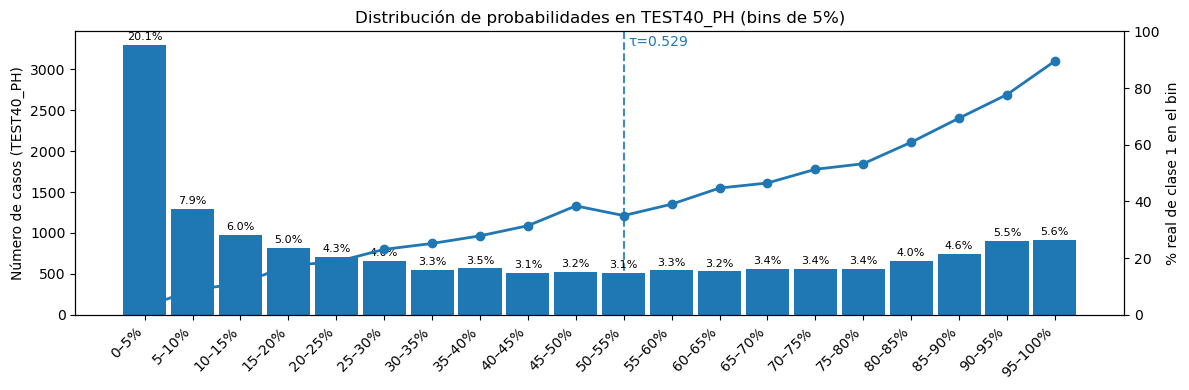

== Métricas en TEST40_PH con τ=0.529 ==
CM [[TN, FP],[FN, TP]] = [[8714 2375], [1499 3812]]
              precision    recall  f1-score   support

       False      0.853     0.786     0.818     11089
        True      0.616     0.718     0.663      5311

    accuracy                          0.764     16400
   macro avg      0.735     0.752     0.741     16400
weighted avg      0.776     0.764     0.768     16400

precision_0: 0.853226280231078 | recall_0: 0.7858237893407881 | f1_0: 0.8181391418646137
precision_1: 0.6161305964118312 | recall_1: 0.717755601581623 | f1_1: 0.6630718385806227


C:\Users\sevas\AppData\Local\Temp\ipykernel_12884\4211364408.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bin_tau = int(np.clip(np.digitize([tau], edges)-1, 0, bins-1))


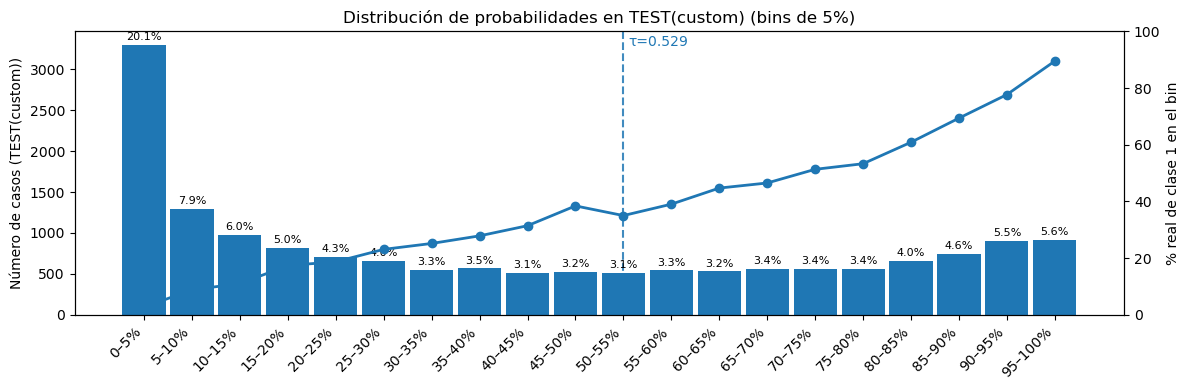

== Métricas en TEST(custom) con τ=0.529 ==
CM [[TN, FP],[FN, TP]] = [[8714 2375], [1499 3812]]
              precision    recall  f1-score   support

       False      0.853     0.786     0.818     11089
        True      0.616     0.718     0.663      5311

    accuracy                          0.764     16400
   macro avg      0.735     0.752     0.741     16400
weighted avg      0.776     0.764     0.768     16400

precision_0: 0.853226280231078 | recall_0: 0.7858237893407881 | f1_0: 0.8181391418646137
precision_1: 0.6161305964118312 | recall_1: 0.717755601581623 | f1_1: 0.6630718385806227


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# --- elige automáticamente el split de test disponible ---
def _pick_test_split():
    g = globals()
    # prioridad: *40_PH -> *40 -> _PH -> genérico
    if all(k in g for k in ["x_test40_PH","y_test40_PH"]): return g["x_test40_PH"], g["y_test40_PH"], "TEST40_PH"
    if all(k in g for k in ["x_test40","y_test40"]):       return g["x_test40"],   g["y_test40"],   "TEST40"
    if all(k in g for k in ["x_test_PH","y_test_PH"]):     return g["x_test_PH"],  g["y_test_PH"],  "TEST_PH"
    if all(k in g for k in ["x_test","y_test"]):           return g["x_test"],     g["y_test"],     "TEST"
    # si no hay y_test, devuelve solo X y split
    if "x_test40_PH" in g: return g["x_test40_PH"], None, "TEST40_PH"
    if "x_test40"    in g: return g["x_test40"],    None, "TEST40"
    if "x_test_PH"   in g: return g["x_test_PH"],   None, "TEST_PH"
    if "x_test"      in g: return g["x_test"],      None, "TEST"
    raise RuntimeError("No encuentro datos de test en el entorno.")

def plot_prob_bins_with_tau(tau, model=None, X=None, y=None, bins=20, title=None):
    """
    Dibuja distribución de probabilidades (bins) y marca la tau elegida.
    Si y no es None, reporta métricas al aplicar ese umbral.
    """
    if model is None:
        model = best_model  # usa tu modelo ya entrenado

    # carga X,y si no se pasan
    if X is None:
        X, y_auto, split_name = _pick_test_split()
        if y is None:
            y = y_auto
    else:
        split_name = "TEST(custom)"

    p = model.predict_proba(X)[:, 1].astype(float)

    # bins
    edges = np.linspace(0, 1, bins+1)
    idx = np.clip(np.digitize(p, edges) - 1, 0, bins-1)
    total = np.array([(idx == i).sum() for i in range(bins)])
    pct_total = 100 * total / max(1, len(p))
    avg_p = np.array([p[idx == i].mean() if (idx == i).any() else np.nan for i in range(bins)])
    labels = [f"{int(edges[i]*100)}–{int(edges[i+1]*100)}%" for i in range(bins)]

    # % real de clase 1 por bin si tenemos y
    if y is not None:
        pos = np.array([y[idx == i].sum() if (idx == i).any() else 0 for i in range(bins)])
        rate_pos = np.where(total>0, 100*pos/total, np.nan)
    else:
        rate_pos = None

    # gráfico
    fig, ax = plt.subplots(figsize=(12, 4))
    x = np.arange(bins)
    bars = ax.bar(x, total, width=0.9)
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel(f"Número de casos ({split_name})")
    ax.set_title(title or f"Distribución de probabilidades en {split_name} (bins de {100//bins}%)")

    # % del total encima de cada barra
    bump = max(total)*0.01 if total.max()>0 else 0.1
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()+bump, f"{pct_total[i]:.1f}%",
                ha="center", va="bottom", fontsize=8)

    # línea de tau
    bin_tau = int(np.clip(np.digitize([tau], edges)-1, 0, bins-1))
    ax.axvline(bin_tau, ls="--", c="tab:blue", alpha=0.85)
    ax.text(bin_tau+0.1, ax.get_ylim()[1]*0.95, f"τ={tau:.3f}", color="tab:blue")

    # eje derecho: % real de clase 1 en el bin (si hay y)
    if rate_pos is not None:
        ax2 = ax.twinx()
        ax2.plot(x, rate_pos, marker="o", linewidth=2)
        ax2.set_ylim(0, 100)
        ax2.set_ylabel("% real de clase 1 en el bin")

    plt.tight_layout(); plt.show()

    # métricas al umbral elegido (si hay y)
    if y is not None:
        y_hat = (p >= tau).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
        print(f"== Métricas en {split_name} con τ={tau:.3f} ==")
        print(f"CM [[TN, FP],[FN, TP]] = [[{tn} {fp}], [{fn} {tp}]]")
        print(classification_report(y, y_hat, digits=3))
        print("precision_0:", precision_score(y, y_hat, pos_label=0, zero_division=0),
              "| recall_0:",  recall_score(y,  y_hat, pos_label=0),
              "| f1_0:",      f1_score(y,     y_hat, pos_label=0))
        print("precision_1:", precision_score(y, y_hat, pos_label=1, zero_division=0),
              "| recall_1:",  recall_score(y,  y_hat, pos_label=1),
              "| f1_1:",      f1_score(y,     y_hat, pos_label=1))

# ======= Ejemplos de uso =======
# 1) Usando auto-detección de TEST y el best_model:
plot_prob_bins_with_tau(0.529224)

# 2) Pasando explícitamente tus datos:
plot_prob_bins_with_tau(0.529224, model=best_model, X=x_test40_PH, y=y_test40_PH)



== Métricas en TEST40_PH con τ=0.529 ==
CM [[TN, FP],[FN, TP]] = [[8712 2377], [1499 3812]]
              precision    recall  f1-score   support

           0      0.853     0.786     0.818     11089
           1      0.616     0.718     0.663      5311

    accuracy                          0.764     16400
   macro avg      0.735     0.752     0.740     16400
weighted avg      0.776     0.764     0.768     16400



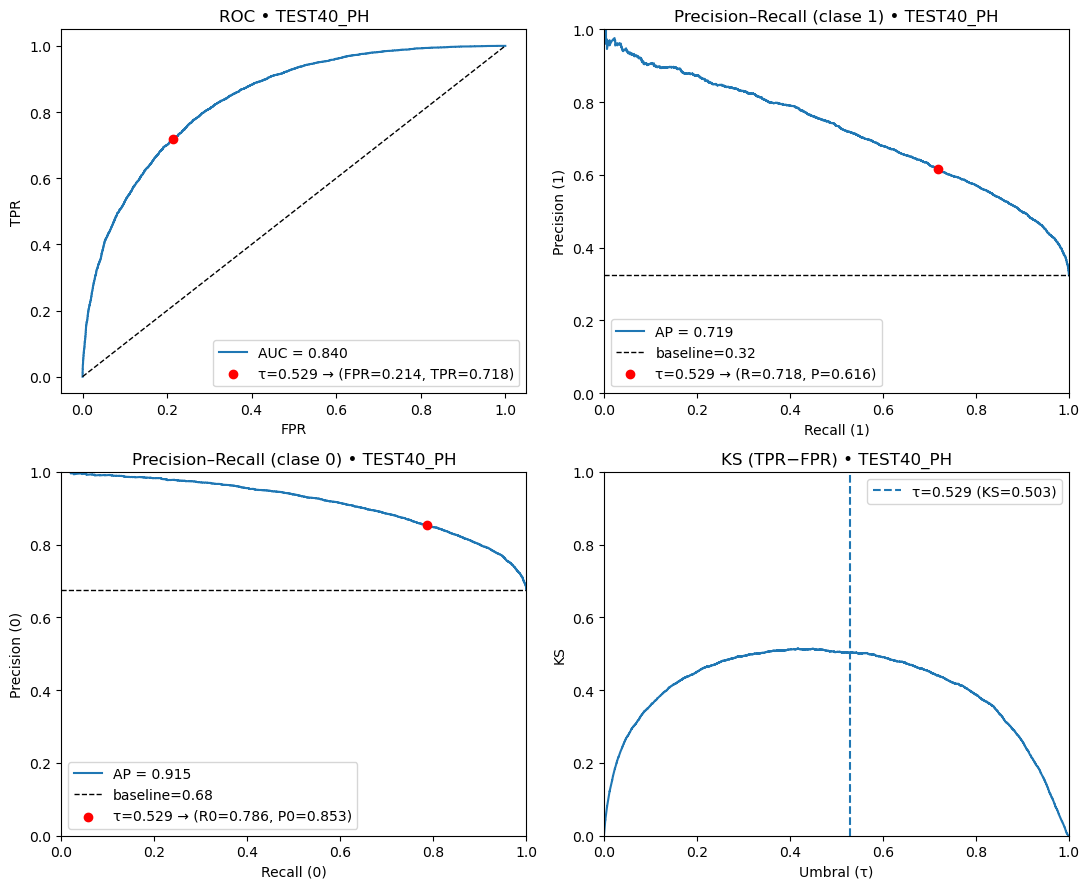

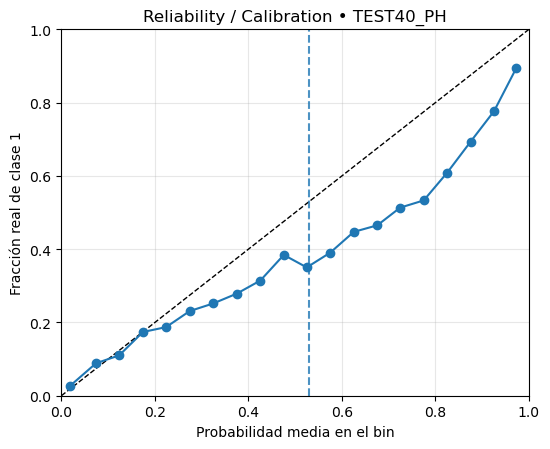


== Métricas en TEST(custom) con τ=0.529 ==
CM [[TN, FP],[FN, TP]] = [[8712 2377], [1499 3812]]
              precision    recall  f1-score   support

           0      0.853     0.786     0.818     11089
           1      0.616     0.718     0.663      5311

    accuracy                          0.764     16400
   macro avg      0.735     0.752     0.740     16400
weighted avg      0.776     0.764     0.768     16400



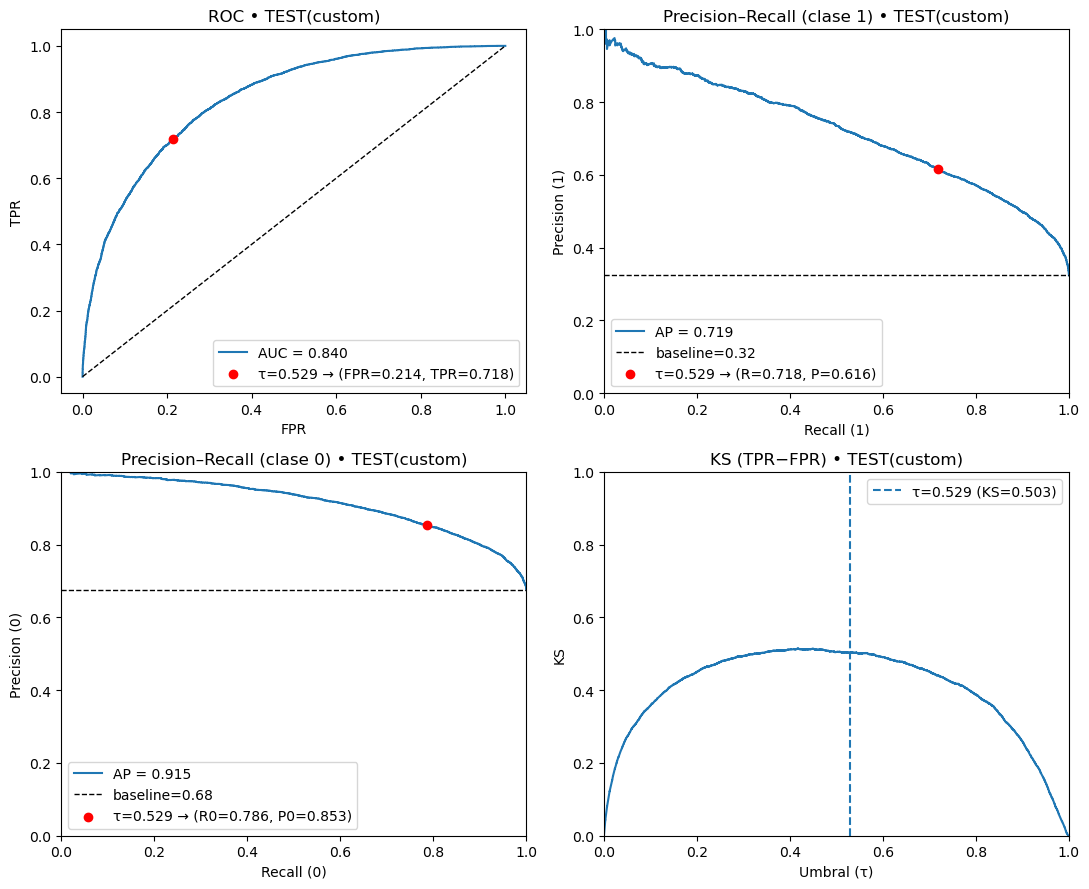

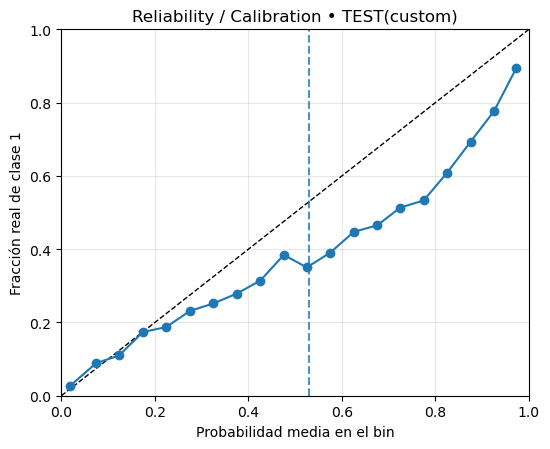

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, precision_score, recall_score, f1_score
)
from sklearn.calibration import calibration_curve

def _pick_test_split_any():
    g = globals()
    # prioridad: *40_PH -> *40 -> _PH -> genérico
    if all(k in g for k in ["x_test40_PH","y_test40_PH"]): return g["x_test40_PH"], g["y_test40_PH"], "TEST40_PH"
    if all(k in g for k in ["x_test40","y_test40"]):       return g["x_test40"],   g["y_test40"],   "TEST40"
    if all(k in g for k in ["x_test_PH","y_test_PH"]):     return g["x_test_PH"],  g["y_test_PH"],  "TEST_PH"
    if all(k in g for k in ["x_test","y_test"]):           return g["x_test"],     g["y_test"],     "TEST"
    raise RuntimeError("No encuentro X_test/y_test en el entorno.")

def plot_all_curves_with_tau(tau, model=None, X=None, y=None, title_suffix=""):
    # 1) datos y probabilidades
    if model is None:
        model = best_model
    if X is None or y is None:
        X, y, split = _pick_test_split_any()
    else:
        split = "TEST(custom)"
    y = y.astype(int)
    p = model.predict_proba(X)[:, 1].astype(float)

    # predicción a τ
    yhat = (p >= tau).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    tpr_tau = tp / (tp + fn) if (tp + fn) else 0.0  # recall_1
    fpr_tau = fp / (fp + tn) if (fp + tn) else 0.0
    prec1_tau = precision_score(y, yhat, pos_label=1, zero_division=0)
    rec1_tau  = recall_score(y,  yhat, pos_label=1)
    prec0_tau = precision_score(y, yhat, pos_label=0, zero_division=0)
    rec0_tau  = recall_score(y,  yhat, pos_label=0)

    print(f"\n== Métricas en {split} con τ={tau:.3f} ==")
    print(f"CM [[TN, FP],[FN, TP]] = [[{tn} {fp}], [{fn} {tp}]]")
    print(classification_report(y, yhat, digits=3))

    # 2) ROC
    fpr, tpr, thr = roc_curve(y, p)
    auc = roc_auc_score(y, p)

    # 3) PR clase 1
    prec1, rec1, _ = precision_recall_curve(y, p)
    ap1 = average_precision_score(y, p)
    base1 = y.mean()

    # 4) PR clase 0 (invirtiendo)
    y0, p0 = 1 - y, 1 - p
    prec0, rec0, _ = precision_recall_curve(y0, p0)
    ap0 = average_precision_score(y0, p0)
    base0 = y0.mean()

    # 5) KS(τ) = TPR - FPR a través de la rejilla de thresholds de ROC
    # (nota: los thresholds de roc_curve están ordenados en prob. descendente)
    ks_vals = tpr - fpr
    # KS en tu τ:
    ks_tau = tpr_tau - fpr_tau

    # 6) Calibration/ Reliability
    prob_true, prob_pred = calibration_curve(y, p, n_bins=20, strategy="uniform")

    # === FIGURA 2x2 ===
    fig, axs = plt.subplots(2, 2, figsize=(11, 9))

    # ROC
    axs[0,0].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    axs[0,0].plot([0,1],[0,1],'k--',lw=1)
    axs[0,0].scatter([fpr_tau],[tpr_tau], c="red", zorder=3,
                     label=f"τ={tau:.3f} → (FPR={fpr_tau:.3f}, TPR={tpr_tau:.3f})")
    axs[0,0].set_title(f"ROC • {split}{title_suffix}")
    axs[0,0].set_xlabel("FPR"); axs[0,0].set_ylabel("TPR")
    axs[0,0].legend(loc="lower right")

    # PR clase 1
    axs[0,1].plot(rec1, prec1, label=f"AP = {ap1:.3f}")
    axs[0,1].hlines(base1, 0, 1, colors='k', linestyles='--', lw=1, label=f"baseline={base1:.2f}")
    axs[0,1].scatter([rec1_tau],[prec1_tau], c="red", zorder=3,
                     label=f"τ={tau:.3f} → (R={rec1_tau:.3f}, P={prec1_tau:.3f})")
    axs[0,1].set_xlim(0,1); axs[0,1].set_ylim(0,1)
    axs[0,1].set_title(f"Precision–Recall (clase 1) • {split}")
    axs[0,1].set_xlabel("Recall (1)"); axs[0,1].set_ylabel("Precision (1)")
    axs[0,1].legend(loc="lower left")

    # PR clase 0
    axs[1,0].plot(rec0, prec0, label=f"AP = {ap0:.3f}")
    axs[1,0].hlines(base0, 0, 1, colors='k', linestyles='--', lw=1, label=f"baseline={base0:.2f}")
    axs[1,0].scatter([rec0_tau],[prec0_tau], c="red", zorder=3,
                     label=f"τ={tau:.3f} → (R0={rec0_tau:.3f}, P0={prec0_tau:.3f})")
    axs[1,0].set_xlim(0,1); axs[1,0].set_ylim(0,1)
    axs[1,0].set_title(f"Precision–Recall (clase 0) • {split}")
    axs[1,0].set_xlabel("Recall (0)"); axs[1,0].set_ylabel("Precision (0)")
    axs[1,0].legend(loc="lower left")

    # KS vs thresholds (aprox: pintamos KS frente al vector de thresholds de ROC)
    # Los thresholds de ROC pueden tener valores >1 o <0 extremos; filtramos a [0,1]
    mask_thr = np.isfinite(thr) & (thr>=0) & (thr<=1)
    axs[1,1].plot(thr[mask_thr], ks_vals[mask_thr])
    axs[1,1].axvline(tau, ls="--", c="tab:blue", label=f"τ={tau:.3f} (KS={ks_tau:.3f})")
    axs[1,1].set_xlim(0,1); axs[1,1].set_ylim(0,1)
    axs[1,1].set_title(f"KS (TPR−FPR) • {split}")
    axs[1,1].set_xlabel("Umbral (τ)"); axs[1,1].set_ylabel("KS")
    axs[1,1].legend()

    plt.tight_layout(); plt.show()

    # === Reliability ===
    plt.figure(figsize=(5.6,4.6))
    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.axvline(tau, ls='--', c='tab:blue', alpha=.8)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.title(f"Reliability / Calibration • {split}")
    plt.xlabel("Probabilidad media en el bin"); plt.ylabel("Fracción real de clase 1")
    plt.grid(alpha=.3); plt.tight_layout(); plt.show()

# === Ejemplos ===
plot_all_curves_with_tau(0.529)                              # autodetecta TEST y usa best_model
plot_all_curves_with_tau(0.529, model=best_model, X=x_test40_PH, y=y_test40_PH)


# is_stable

In [671]:
# y_data_is_stable porcentaje de 0 y 1
y_data_is_stable.value_counts(normalize=True)

is_stable
True     0.726384
False    0.273616
Name: proportion, dtype: float64

In [672]:
y_data_is_stable.isnull().sum()

0

In [673]:
x_trainIS40,x_testIS40, y_trainIS40,y_testIS40 = train_test_split(
    X_data.drop(columns=["energy_above_hull"]), y_data_is_stable, test_size=0.5, random_state=RANDOM_STATE
)

In [674]:
y_trainIS40.value_counts(normalize=True)

is_stable
True     0.721457
False    0.278543
Name: proportion, dtype: float64

In [675]:
x_trainIS,x_testIS, y_trainIS,y_testIS = train_test_split(
    x_trainIS40, y_trainIS40, test_size=0.8, random_state=RANDOM_STATE
)

In [676]:
y_testIS.value_counts(normalize=True)

is_stable
True     0.723018
False    0.276982
Name: proportion, dtype: float64

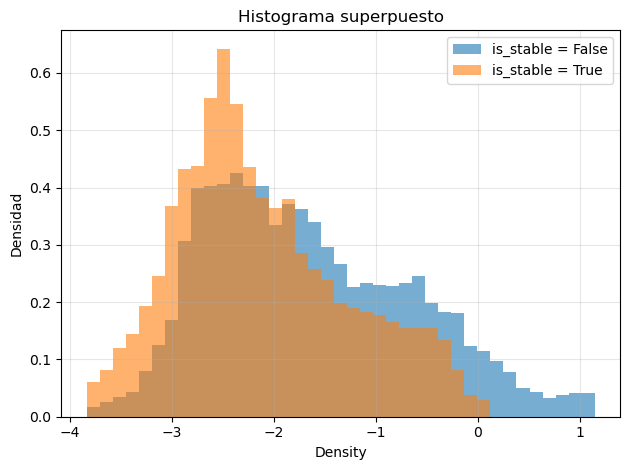

In [682]:
# Distribución de formation_energy_per_atom por clase de is_stable

# 1) Preparar datos
df_plot = pd.DataFrame({
    "Density": X_data["formation_energy_per_atom"],
    "is_stable": y_data_is_stable.astype(bool)
}).replace([np.inf, -np.inf], np.nan).dropna()

vals_false = df_plot.loc[~df_plot["is_stable"], "Density"].values
vals_true  = df_plot.loc[df_plot["is_stable"],  "Density"].values
q1, q99 = df_plot["Density"].quantile([0.01, 0.99])
bins = np.linspace(q1, q99, 40)
plt.hist(vals_false, bins=bins, density=True, alpha=0.6, label="is_stable = False")
plt.hist(vals_true,  bins=bins, density=True, alpha=0.6, label="is_stable = True")
plt.title("Histograma superpuesto")
plt.xlabel("Density")
plt.ylabel("Densidad")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ====== Benchmark rápido de modelos (ranking por F1_0) ======
import time
import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, accuracy_score
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Flags de modelos opcionales
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    from catboost import CatBoostClassifier
    HAS_CAT = True
except Exception:
    HAS_CAT = False

try:
    from imblearn.ensemble import BalancedRandomForestClassifier
    HAS_BRF = True
except Exception:
    HAS_BRF = False

# ===== Config =====
RANDOM_STATE = 42
USE_GPU = True  # pon False si no quieres intentar GPU

# ===== Pesos balanceados =====
sw = compute_sample_weight("balanced", y_trainIS).astype(float)

# ===== Helpers =====
def get_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        z = model.decision_function(X); return 1/(1+np.exp(-z))
    return model.predict(X).astype(float)

def eval_metrics(y_true, y_pred, p1):
    return dict(
        precision_0=precision_score(y_true, y_pred, pos_label=0, zero_division=0),
        recall_0   =recall_score(y_true,  y_pred, pos_label=0),
        f1_0       =f1_score(y_true,     y_pred, pos_label=0, zero_division=0),
        precision_1=precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        recall_1   =recall_score(y_true,  y_pred, pos_label=1),
        f1_1       =f1_score(y_true,     y_pred, pos_label=1, zero_division=0),
        accuracy   =accuracy_score(y_true, y_pred),
        roc_auc    =roc_auc_score(y_true, p1),
        ap_1       =average_precision_score(y_true, p1),
        ap_0       =average_precision_score(1 - y_true, 1 - p1),
    )

results = []

# ===== 1) Logistic Regression =====
logit = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(class_weight="balanced", max_iter=2000,
                       solver="saga", n_jobs=-1, random_state=RANDOM_STATE)
)
t0=time.time(); logit.fit(x_trainIS, y_trainIS); tr=time.time()-t0
p1=get_proba(logit, x_testIS); yhat=(p1>=0.5).astype(int)
res=eval_metrics(y_testIS, yhat, p1); res.update(model="LogisticRegression", train_sec=tr)
results.append(res)

# ===== 2) Random Forest =====
rf = RandomForestClassifier(n_estimators=300, class_weight="balanced",
                            n_jobs=-1, random_state=RANDOM_STATE)
t0=time.time(); rf.fit(x_trainIS, y_trainIS); tr=time.time()-t0
p1=get_proba(rf, x_testIS); yhat=(p1>=0.5).astype(int)
res=eval_metrics(y_testIS, yhat, p1); res.update(model="RandomForest", train_sec=tr)
results.append(res)

# ===== 3) Gradient Boosting (sklearn) =====
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
t0=time.time(); gb.fit(x_trainIS, y_trainIS, sample_weight=sw); tr=time.time()-t0
p1=get_proba(gb, x_testIS); yhat=(p1>=0.5).astype(int)
res=eval_metrics(y_testIS, yhat, p1); res.update(model="GradientBoosting", train_sec=tr)
results.append(res)

# ===== 4) Balanced Random Forest =====
if HAS_BRF:
    brf = BalancedRandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
    t0=time.time(); brf.fit(x_trainIS, y_trainIS); tr=time.time()-t0
    p1=get_proba(brf, x_testIS); yhat=(p1>=0.5).astype(int)
    res=eval_metrics(y_testIS, yhat, p1); res.update(model="BalancedRandomForest", train_sec=tr)
    results.append(res)

# ===== 5) XGBoost =====
if HAS_XGB:
    xgb = XGBClassifier(
        objective="binary:logistic", eval_metric="logloss", n_estimators=400,
        tree_method=("gpu_hist" if USE_GPU else "hist"),
        predictor=("gpu_predictor" if USE_GPU else "auto"),
        n_jobs=-1, random_state=RANDOM_STATE
    )
    t0=time.time(); xgb.fit(x_trainIS, y_trainIS, sample_weight=sw); tr=time.time()-t0
    p1=get_proba(xgb, x_testIS); yhat=(p1>=0.5).astype(int)
    res=eval_metrics(y_testIS, yhat, p1); res.update(model="XGBoost", train_sec=tr)
    results.append(res)

# ===== 6) LightGBM =====
if HAS_LGBM:
    try:
        lgbm = LGBMClassifier(
            objective="binary", n_estimators=400, class_weight="balanced",
            random_state=RANDOM_STATE, device_type=("gpu" if USE_GPU else "cpu")
        )
    except TypeError:
        # versiones antiguas no aceptan device_type
        lgbm = LGBMClassifier(
            objective="binary", n_estimators=400, class_weight="balanced",
            random_state=RANDOM_STATE
        )
    t0=time.time(); lgbm.fit(x_trainIS, y_trainIS); tr=time.time()-t0
    p1=get_proba(lgbm, x_testIS); yhat=(p1>=0.5).astype(int)
    res=eval_metrics(y_testIS, yhat, p1); res.update(model="LightGBM", train_sec=tr)
    results.append(res)

# ===== 7) CatBoost (corregido: loss_function="Logloss") =====
if HAS_CAT:
    # class_weights ~ inverso de frecuencia
    w0 = len(y_trainIS) / (2.0 * (y_trainIS == 0).sum())
    w1 = len(y_trainIS) / (2.0 * (y_trainIS == 1).sum())
    try:
        cat = CatBoostClassifier(
            iterations=400, depth=6, learning_rate=0.1,
            loss_function="Logloss",                     # <- corregido
            class_weights=[w0, w1],
            random_state=RANDOM_STATE, verbose=False,
            task_type=("GPU" if USE_GPU else "CPU")
        )
    except Exception:
        # Fallback por compatibilidad
        cat = CatBoostClassifier(
            iterations=400, depth=6, learning_rate=0.1,
            loss_function="CrossEntropy",
            class_weights=[w0, w1],
            random_state=RANDOM_STATE, verbose=False,
            task_type=("GPU" if USE_GPU else "CPU")
        )
    t0=time.time(); cat.fit(x_trainIS, y_trainIS); tr=time.time()-t0
    p1=get_proba(cat, x_testIS); yhat=(p1>=0.5).astype(int)
    res=eval_metrics(y_testIS, yhat, p1); res.update(model="CatBoost", train_sec=tr)
    results.append(res)

# ===== Ranking por F1_0 (empate por ROC-AUC) =====
df = pd.DataFrame(results)
df_sorted = df.sort_values(["f1_0", "roc_auc"], ascending=False).reset_index(drop=True)
print("\n== Ranking por F1_0 (empate por ROC-AUC) ==")
print(df_sorted[[
    "model","roc_auc","ap_1","ap_0","accuracy",
    "precision_0","recall_0","f1_0","precision_1","recall_1","f1_1","train_sec"
]])


c:\Users\sevas\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\sevas\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` paramet

[LightGBM] [Info] Number of positive: 5864, number of negative: 2335
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2657
[LightGBM] [Info] Number of data points in the train set: 8199, number of used features: 21
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 15 dense feature groups (0.13 MB) transferred to GPU in 0.000967 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

== Ranking por F1_0 (empate por ROC-AUC) ==
                  model   roc_auc      ap_1      ap_0  accuracy  precision_0  \
0              LightGBM  0.887832  0.941986  0.809524  0.848933     0.729955   
1               XGBoost  0.889216  0.943181  0.807319  0.

min_atomic_mass                0.135989
crystal_system_Trigonal        0.083996
crystal_system_Hexagonal       0.080185
n_elements                     0.074969
formation_energy_per_atom      0.070668
nsites                         0.056439
electronegativity_range        0.050400
crystal_system_Triclinic       0.049397
avg_electronegativity          0.045306
spacegroup_number              0.039781
avg_atomic_radius              0.039135
density                        0.035336
avg_atomic_mass                0.033864
volume                         0.032702
volume_per_atom                0.032269
range_atomic_mass              0.029702
max_atomic_mass                0.027405
crystal_system_Orthorhombic    0.026836
crystal_system_Tetragonal      0.020205
crystal_system_Monoclinic      0.019649
crystal_system_Cubic           0.015769
dtype: float32


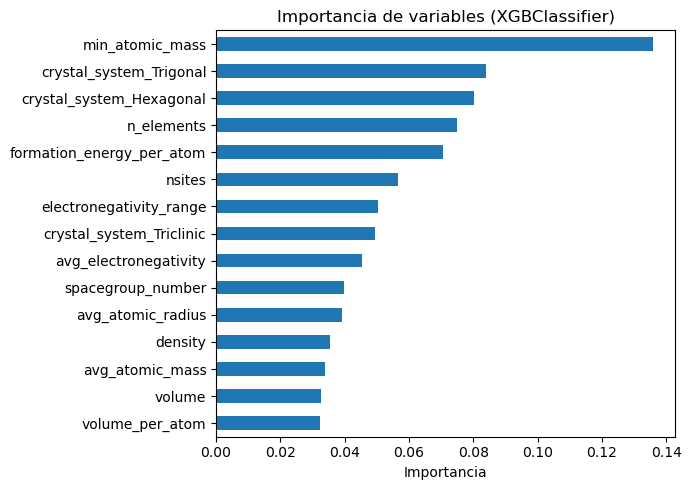

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

# Obtener importancias de las features del modelo xgb
importances = xgb.feature_importances_
features = x_trainIS.columns  # usa el mismo orden de columnas que el entrenamiento

# Crear un DataFrame ordenado
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
print(feat_imp)

# Gráfico de barras de las 15 más importantes
feat_imp.head(15).plot(kind='barh', figsize=(7,5))
plt.gca().invert_yaxis()
plt.title("Importancia de variables (XGBClassifier)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

In [696]:
# ================== CONFIG ==================
RANDOM_STATE = 42
USE_GPU      = True          # pon False si no tienes GPU/CUDA
VAL_SIZE     = 0.20          # tamaño del holdout interno
N_ITER       = 40            # nº de combinaciones aleatorias (sube/baja según tiempo)

# refuerzo opcional por clase (multiplica a los pesos balanceados)
W0_EXTRA = 1.0               # >1 refuerza clase 0 (suele subir f1_0)
W1_EXTRA = 1.0               # >1 refuerza clase 1

# ================== IMPORTS ==================
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

# ================== SPLIT INTERNO (holdout) ==================
X_tr, X_val, y_tr, y_val = train_test_split(
    x_trainIS, y_trainIS, test_size=VAL_SIZE, stratify=y_trainIS, random_state=RANDOM_STATE
)

# ================== PESOS POR MUESTRA ==================
# base balanceada + refuerzos opcionales
sw_tr = compute_sample_weight("balanced", y_tr).astype(float)
sw_tr[y_tr == 0] *= W0_EXTRA
sw_tr[y_tr == 1] *= W1_EXTRA

print(f"Peso medio efectivo -> clase0={sw_tr[y_tr==0].mean():.3f} | clase1={sw_tr[y_tr==1].mean():.3f}")

# ================== ESPACIO DE BÚSQUEDA (aleatorio) ==================
rng = np.random.default_rng(RANDOM_STATE)

def sample_params():
    return dict(
        n_estimators     = int(rng.integers(300, 1501)),
        learning_rate    = float(np.exp(rng.uniform(np.log(0.01), np.log(0.20)))),  # 0.01–0.20
        num_leaves       = int(rng.integers(16, 256)),
        max_depth        = int(rng.integers( -1,  17)),   # -1 = sin límite
        min_child_samples= int(rng.integers(10,  200)),
        subsample        = float(rng.uniform(0.6, 1.0)),  # bagging fraction
        colsample_bytree = float(rng.uniform(0.6, 1.0)),  # feature fraction
        reg_alpha        = float(np.exp(rng.uniform(np.log(1e-8), np.log(1e-1)))),
        reg_lambda       = float(np.exp(rng.uniform(np.log(1e-3), np.log(30.0)))),
        min_split_gain   = float(np.exp(rng.uniform(np.log(1e-8), np.log(1.0)))),
    )

# ================== RANDOM SEARCH (sin CV) → métrica f1_0 en VALIDACIÓN ==================
best_f10_val, best_params, best_model = -1.0, None, None

for i in range(1, N_ITER + 1):
    params = sample_params()

    # Compatibilidad con versiones (device_type puede no existir)
    common_kwargs = dict(
        objective="binary",
        class_weight="balanced",           # base: balancea por frecuencia
        random_state=RANDOM_STATE
    )
    if USE_GPU:
        try:
            model = LGBMClassifier(**params, **common_kwargs, device_type="gpu")
        except TypeError:
            model = LGBMClassifier(**params, **common_kwargs)  # sin device_type
    else:
        model = LGBMClassifier(**params, **common_kwargs)

    model.fit(X_tr, y_tr, sample_weight=sw_tr)

    # Predicción binaria (umbral 0.5) y F1 de la CLASE 0
    y_val_pred = model.predict(X_val)  # usa p>=0.5 internamente
    f10 = f1_score(y_val, y_val_pred, pos_label=0, zero_division=0)

    if f10 > best_f10_val:
        best_f10_val, best_params, best_model = f10, params, model

    if i % 5 == 0 or i == 1:
        print(f"[{i}/{N_ITER}] f1_0(val)={f10:.4f} | best={best_f10_val:.4f}")

print("\n== Mejores hiperparámetros (holdout, max f1_0) ==")
print(best_params)
print(f"Mejor f1_0 en VALIDACIÓN: {best_f10_val:.4f}")

# ================== EVALUACIÓN EN TEST (corte 0.5) ==================
y_test_pred = best_model.predict(x_testIS)
print("\n== TEST (corte 0.5) ==")
print("CM [[TN, FP],[FN, TP]]:\n", confusion_matrix(y_testIS, y_test_pred))
print(classification_report(y_testIS, y_test_pred, digits=3))

# ================== Probabilidades para umbrales (para tu siguiente paso) ==================
p_val_IS  = best_model.predict_proba(X_val)[:, 1]
p_test_IS = best_model.predict_proba(x_testIS)[:, 1]

# (quedan en memoria X_val, y_val, p_val_IS) → perfectos para barrer τ y fijar tu umbral.


Peso medio efectivo -> clase0=1.756 | clase1=0.699
[1/40] f1_0(val)=0.6313 | best=0.6313
[5/40] f1_0(val)=0.7119 | best=0.7119
[10/40] f1_0(val)=0.7215 | best=0.7279
[15/40] f1_0(val)=0.7208 | best=0.7279
[20/40] f1_0(val)=0.6718 | best=0.7279
[25/40] f1_0(val)=0.7087 | best=0.7279
[30/40] f1_0(val)=0.5686 | best=0.7279
[35/40] f1_0(val)=0.6965 | best=0.7279
[40/40] f1_0(val)=0.6803 | best=0.7279

== Mejores hiperparámetros (holdout, max f1_0) ==
{'n_estimators': 967, 'learning_rate': 0.05494767940940439, 'num_leaves': 126, 'max_depth': -1, 'min_child_samples': 36, 'subsample': 0.6458120294143893, 'colsample_bytree': 0.8673611847161886, 'reg_alpha': 1.984602083708936e-05, 'reg_lambda': 0.3393365079333757, 'min_split_gain': 0.013182289932686227}
Mejor f1_0 en VALIDACIÓN: 0.7279

== TEST (corte 0.5) ==
CM [[TN, FP],[FN, TP]]:
 [[ 6530  2555]
 [ 2570 21145]]
              precision    recall  f1-score   support

       False      0.718     0.719     0.718      9085
        True      0.892

Matriz de confusión [[TN, FP], [FN, TP]]:
 [[ 6530  2555]
 [ 2570 21145]]


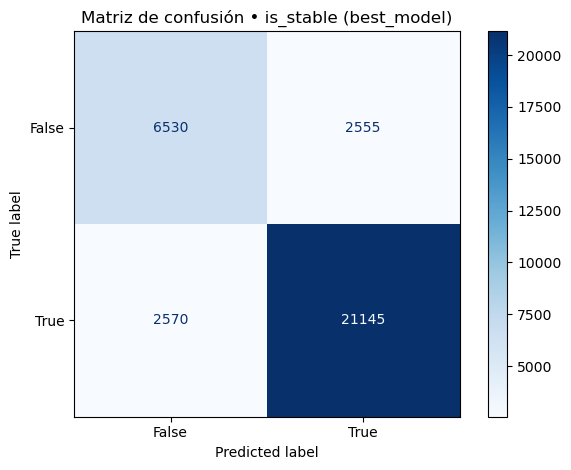

In [699]:
# Matriz de confusión de best_model en x_testIS vs y_testIS
y_pred_IS = best_model.predict(x_testIS)
cm_IS = confusion_matrix(y_testIS, y_pred_IS)

print("Matriz de confusión [[TN, FP], [FN, TP]]:\n", cm_IS)

# Visualización (si está disponible Matplotlib)
try:
    disp = ConfusionMatrixDisplay(cm_IS, display_labels=[False, True])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Matriz de confusión • is_stable (best_model)")
    plt.tight_layout()
    plt.show()
except Exception:
    pass

In [ ]:
# best_model  x_testIS y y_testIS matriz de confucion


formation_energy_per_atom      9163
volume_per_atom                6820
density                        6384
avg_electronegativity          6072
volume                         5210
avg_atomic_mass                4946
spacegroup_number              4608
avg_atomic_radius              4446
nsites                         3981
electronegativity_range        3905
range_atomic_mass              2798
max_atomic_mass                2273
min_atomic_mass                1263
n_elements                      987
crystal_system_Trigonal          92
crystal_system_Monoclinic        59
crystal_system_Cubic             29
crystal_system_Tetragonal        29
crystal_system_Orthorhombic      24
crystal_system_Triclinic         18
crystal_system_Hexagonal          4
dtype: int32


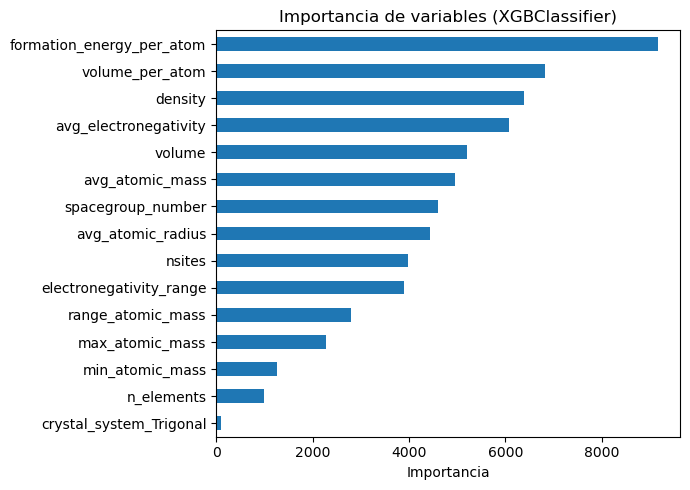

In [697]:
importances = best_model.feature_importances_
features = x_trainIS.columns  # usa el mismo orden de columnas que el entrenamiento

# Crear un DataFrame ordenado
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
print(feat_imp)

# Gráfico de barras de las 15 más importantes
feat_imp.head(15).plot(kind='barh', figsize=(7,5))
plt.gca().invert_yaxis()
plt.title("Importancia de variables (XGBClassifier)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

C:\Users\sevas\AppData\Local\Temp\ipykernel_12884\1819491183.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bin_tau = int(np.clip(np.digitize([TAU], bins)-1, 0, 19))


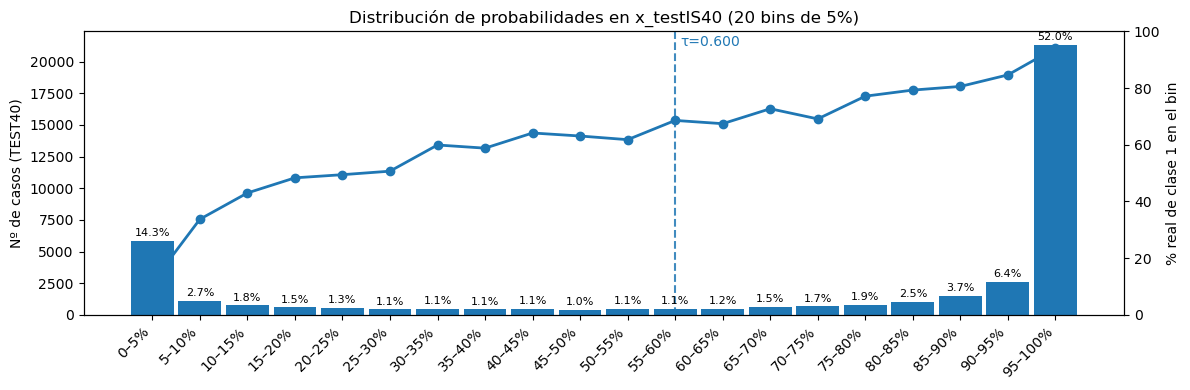

      bin  total  pct_total  avg_proba  pct_pos_real
0    0–5%   5853  14.275958   0.010813     11.447121
1   5–10%   1097   2.675675   0.073268     33.728350
2  10–15%    742   1.809800   0.123119     42.991914
3  15–20%    598   1.458572   0.174228     48.327759
4  20–25%    536   1.307349   0.225136     49.440299
5  25–30%    442   1.078075   0.275334     50.678733
6  30–35%    459   1.119540   0.325373     59.912854
7  35–40%    432   1.053684   0.374906     58.796296
8  40–45%    463   1.129296   0.425029     64.146868
9  45–50%    409   0.997585   0.475646     63.080685

== Métricas en TEST40 con τ=0.600 ==
CM [[TN, FP],[FN, TP]] = [[8133 2883], [3827 26156]]
              precision    recall  f1-score   support

           0      0.680     0.738     0.708     11016
           1      0.901     0.872     0.886     29983

    accuracy                          0.836     40999
   macro avg      0.790     0.805     0.797     40999
weighted avg      0.841     0.836     0.838     40999


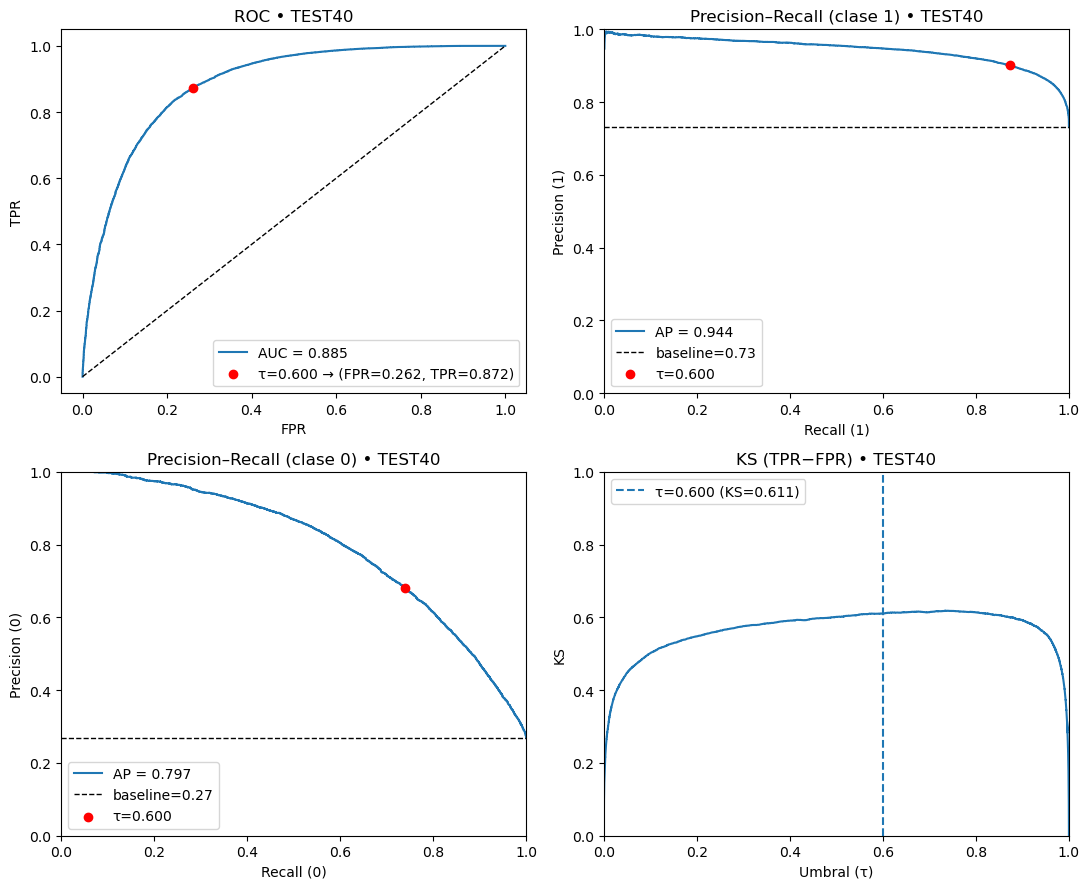

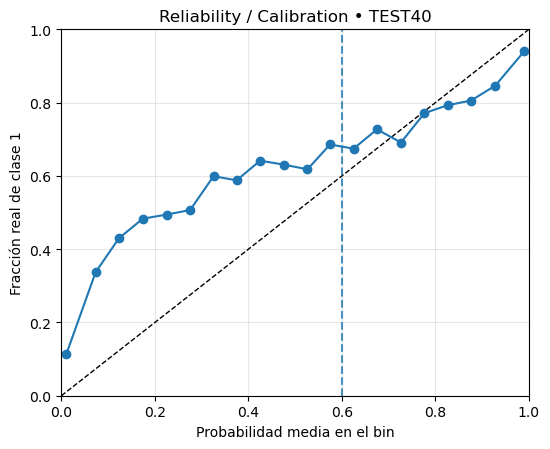

In [698]:
# ===== CONFIG =====
TAU = 0.6   # cambia aquí el umbral que quieras marcar/evaluar

# ===== IMPORTS =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)
from sklearn.calibration import calibration_curve

# ===== 1) Probabilidades en datos nunca vistos =====
p1 = best_model.predict_proba(x_testIS40)[:, 1].astype(float)  # P(y=1|x)

# ===== 2) Distribución de probabilidades (20 bins) =====
def dist_table_and_plot(p, y_true=None, title="Distribución de probabilidades (TEST40, 20 bins de 5%)"):
    bins = np.linspace(0, 1, 21)               # 20 bins
    idx  = np.clip(np.digitize(p, bins) - 1, 0, 19)
    total = np.array([(idx == i).sum() for i in range(20)])
    pct_total = 100 * total / max(1, len(p))
    avg_p  = np.array([p[idx == i].mean() if (idx == i).any() else np.nan for i in range(20)])
    labels = [f"{int(bins[i]*100)}–{int(bins[i+1]*100)}%" for i in range(20)]

    if y_true is not None:
        pos = np.array([y_true[idx == i].sum() if (idx == i).any() else 0 for i in range(20)])
        rate_pos = np.where(total > 0, 100 * pos / total, np.nan)
    else:
        rate_pos = None

    # plot
    fig, ax = plt.subplots(figsize=(12, 4))
    x = np.arange(20)
    bars = ax.bar(x, total, width=0.9)
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylabel("Nº de casos (TEST40)")
    ax.set_title(title)

    bump = max(total)*0.01 if total.max()>0 else 0.1
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()+bump, f"{pct_total[i]:.1f}%",
                ha="center", va="bottom", fontsize=8)

    # marca visual del umbral TAU
    bin_tau = int(np.clip(np.digitize([TAU], bins)-1, 0, 19))
    ax.axvline(bin_tau, ls="--", c="tab:blue", alpha=0.85)
    ax.text(bin_tau+0.1, ax.get_ylim()[1]*0.95, f"τ={TAU:.3f}", color="tab:blue")

    if rate_pos is not None:
        ax2 = ax.twinx()
        ax2.plot(x, rate_pos, marker="o", linewidth=2)
        ax2.set_ylim(0, 100)
        ax2.set_ylabel("% real de clase 1 en el bin")

    plt.tight_layout(); plt.show()

    # tabla
    tab = pd.DataFrame({
        "bin": labels,
        "total": total,
        "pct_total": pct_total,
        "avg_proba": avg_p,
        "pct_pos_real": rate_pos
    })
    return tab

tab_bins = dist_table_and_plot(p1, y_true=y_testIS40,
                               title="Distribución de probabilidades en x_testIS40 (20 bins de 5%)")
print(tab_bins.head(10))

# ===== 3) Curvas ROC, PR(1), PR(0), KS, Calibration + métricas en τ =====
y = y_testIS40.astype(int)
yhat_tau = (p1 >= TAU).astype(int)
tn, fp, fn, tp = confusion_matrix(y, yhat_tau).ravel()

print(f"\n== Métricas en TEST40 con τ={TAU:.3f} ==")
print(f"CM [[TN, FP],[FN, TP]] = [[{tn} {fp}], [{fn} {tp}]]")
print(classification_report(y, yhat_tau, digits=3))
print("precision_0:", precision_score(y, yhat_tau, pos_label=0, zero_division=0),
      "| recall_0:", recall_score(y, yhat_tau, pos_label=0),
      "| f1_0:",     f1_score(y, yhat_tau, pos_label=0, zero_division=0))
print("precision_1:", precision_score(y, yhat_tau, pos_label=1, zero_division=0),
      "| recall_1:", recall_score(y, yhat_tau, pos_label=1),
      "| f1_1:",     f1_score(y, yhat_tau, pos_label=1, zero_division=0))

# ROC
fpr, tpr, thr = roc_curve(y, p1)
auc = roc_auc_score(y, p1)
tpr_tau = tp / (tp + fn) if (tp + fn) else 0.0  # recall_1
fpr_tau = fp / (fp + tn) if (fp + tn) else 0.0

# PR clase 1
prec1, rec1, _ = precision_recall_curve(y, p1)
ap1 = average_precision_score(y, p1)
base1 = y.mean()

# PR clase 0 (invertido)
y0, p0 = 1 - y, 1 - p1
prec0, rec0, _ = precision_recall_curve(y0, p0)
ap0 = average_precision_score(y0, p0)
base0 = y0.mean()

# KS
ks_vals = tpr - fpr
ks_tau = tpr_tau - fpr_tau

# Calibration
prob_true, prob_pred = calibration_curve(y, p1, n_bins=20, strategy="uniform")

# === FIGURA 2x2 ===
fig, axs = plt.subplots(2, 2, figsize=(11, 9))

# ROC
axs[0,0].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
axs[0,0].plot([0,1],[0,1],'k--',lw=1)
axs[0,0].scatter([fpr_tau],[tpr_tau], c="red", zorder=3,
                 label=f"τ={TAU:.3f} → (FPR={fpr_tau:.3f}, TPR={tpr_tau:.3f})")
axs[0,0].set_title("ROC • TEST40"); axs[0,0].set_xlabel("FPR"); axs[0,0].set_ylabel("TPR")
axs[0,0].legend(loc="lower right")

# PR clase 1
axs[0,1].plot(rec1, prec1, label=f"AP = {ap1:.3f}")
axs[0,1].hlines(base1, 0, 1, colors='k', linestyles='--', lw=1, label=f"baseline={base1:.2f}")
axs[0,1].scatter([tpr_tau],[precision_score(y, yhat_tau, pos_label=1, zero_division=0)],
                 c="red", zorder=3, label=f"τ={TAU:.3f}")
axs[0,1].set_xlim(0,1); axs[0,1].set_ylim(0,1)
axs[0,1].set_title("Precision–Recall (clase 1) • TEST40")
axs[0,1].set_xlabel("Recall (1)"); axs[0,1].set_ylabel("Precision (1)")
axs[0,1].legend(loc="lower left")

# PR clase 0
axs[1,0].plot(rec0, prec0, label=f"AP = {ap0:.3f}")
axs[1,0].hlines(base0, 0, 1, colors='k', linestyles='--', lw=1, label=f"baseline={base0:.2f}")
axs[1,0].scatter([recall_score(y, yhat_tau, pos_label=0)],
                 [precision_score(y, yhat_tau, pos_label=0, zero_division=0)],
                 c="red", zorder=3, label=f"τ={TAU:.3f}")
axs[1,0].set_xlim(0,1); axs[1,0].set_ylim(0,1)
axs[1,0].set_title("Precision–Recall (clase 0) • TEST40")
axs[1,0].set_xlabel("Recall (0)"); axs[1,0].set_ylabel("Precision (0)")
axs[1,0].legend(loc="lower left")

# KS vs threshold (filtramos thresholds finitos en [0,1])
mask_thr = np.isfinite(thr) & (thr >= 0) & (thr <= 1)
axs[1,1].plot(thr[mask_thr], ks_vals[mask_thr])
axs[1,1].axvline(TAU, ls="--", c="tab:blue", label=f"τ={TAU:.3f} (KS={ks_tau:.3f})")
axs[1,1].set_xlim(0,1); axs[1,1].set_ylim(0,1)
axs[1,1].set_title("KS (TPR−FPR) • TEST40"); axs[1,1].set_xlabel("Umbral (τ)"); axs[1,1].set_ylabel("KS")
axs[1,1].legend()

plt.tight_layout(); plt.show()

# === Reliability separado ===
plt.figure(figsize=(5.6,4.6))
plt.plot([0,1],[0,1],'k--',lw=1)
plt.plot(prob_pred, prob_true, marker='o')
plt.axvline(TAU, ls='--', c='tab:blue', alpha=.8)
plt.xlim(0,1); plt.ylim(0,1)
plt.title("Reliability / Calibration • TEST40")
plt.xlabel("Probabilidad media en el bin"); plt.ylabel("Fracción real de clase 1")
plt.grid(alpha=.3); plt.tight_layout(); plt.show()


In [ ]:
# Unir y_data_band_gap y X_data en un solo DataFrame
df_bandgap = pd.concat([X_data, y_data_band_gap.rename("band_gap")], axis=1)

# Contar filas originales
total_rows = len(df_bandgap)

# Filas con band_gap > 10
mask = df_bandgap["band_gap"] > 8
n_eliminated = mask.sum()
pct_eliminated = 100 * n_eliminated / total_rows

print(f"Filas eliminadas: {n_eliminated}")
print(f"Porcentaje eliminado: {pct_eliminated:.3f}%")

# Eliminar filas con band_gap > 10
df_bandgap = df_bandgap[~mask]

# Volver a separar X_data y y_data_band_gap
X_data = df_bandgap.drop(columns=["band_gap"])
y_data_band_gap = df_bandgap["band_gap"]

Filas eliminadas: 34
Porcentaje eliminado: 0.041%


In [ ]:
x_trainBN40,x_testBN40, y_trainBN40,y_testBN40 = train_test_split(
    X_data, y_data_band_gap, test_size=0.5, random_state=RANDOM_STATE
)

In [ ]:
x_trainBN,x_testBN, y_trainBN, y_testBN = train_test_split(
    x_trainBN40, y_trainBN40, test_size=0.8, random_state=RANDOM_STATE  
)

# mejor modelo

LinearRegression -> RMSE: 1.3242 | MAE: 1.0592 | R2: 0.2704
Ridge           -> RMSE: 1.3242 | MAE: 1.0592 | R2: 0.2704
Lasso           -> RMSE: 1.3241 | MAE: 1.0593 | R2: 0.2705
ElasticNet      -> RMSE: 1.3241 | MAE: 1.0593 | R2: 0.2704
RandomForest    -> RMSE: 0.9640 | MAE: 0.7235 | R2: 0.6133
ExtraTrees      -> RMSE: 0.9613 | MAE: 0.7165 | R2: 0.6155
GradientBoosting -> RMSE: 1.0239 | MAE: 0.7957 | R2: 0.5638


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:15:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:15:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:15:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tr

XGBRegressor    -> RMSE: 0.9128 | MAE: 0.6738 | R2: 0.6533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2898
[LightGBM] [Info] Number of data points in the train set: 8195, number of used features: 22
[LightGBM] [Info] Start training from score 1.990477
LightGBM        -> RMSE: 0.9117 | MAE: 0.6749 | R2: 0.6541
CatBoost        -> RMSE: 0.9149 | MAE: 0.6857 | R2: 0.6517

== RESULTADOS TEST (ordenado por RMSE) ==
           model     RMSE      MAE       R2
        LightGBM 0.911739 0.674856 0.654106
    XGBRegressor 0.912760 0.673806 0.653331
        CatBoost 0.914901 0.685673 0.651703
      ExtraTrees 0.961315 0.716528 0.615468
    RandomForest 0.964024 0.723515 0.613297
GradientBoosting 1.023862 0.795685 0.563802
           Lasso 1.324085 1.059299 0.270487
      ElasticNet 1.324121 1.059266 0.270447
           Ridge 1.324203 1.059211 0.270357

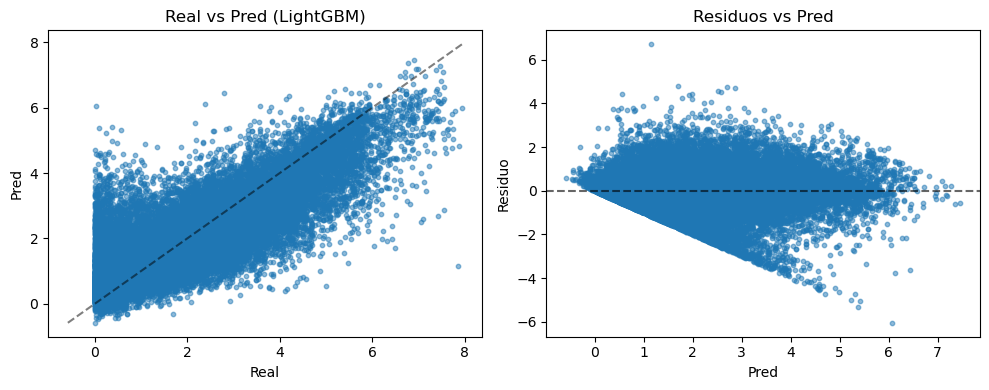

In [ ]:
# ====== QUICK REGRESSION LEADERBOARD (sin CV) ======
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

USE_GPU = True  # pon False si no tienes XGBoost con CUDA

models = {}

# 1) Modelos lineales (con escalado)
models["LinearRegression"] = Pipeline([("scaler", StandardScaler(with_mean=False)), ("mdl", LinearRegression())])
models["Ridge"]             = Pipeline([("scaler", StandardScaler(with_mean=False)), ("mdl", Ridge(alpha=1.0, random_state=42))])
models["Lasso"]             = Pipeline([("scaler", StandardScaler(with_mean=False)), ("mdl", Lasso(alpha=1e-3, max_iter=5000, random_state=42))])
models["ElasticNet"]        = Pipeline([("scaler", StandardScaler(with_mean=False)), ("mdl", ElasticNet(alpha=1e-3, l1_ratio=0.5, max_iter=5000, random_state=42))])

# 2) Árboles/Boosting sklearn
models["RandomForest"]      = RandomForestRegressor(n_estimators=500, max_depth=None, n_jobs=-1, random_state=42)
models["ExtraTrees"]        = ExtraTreesRegressor(n_estimators=500, max_depth=None, n_jobs=-1, random_state=42)
models["GradientBoosting"]  = GradientBoostingRegressor(random_state=42)

# 3) XGBoost (opcional)
try:
    from xgboost import XGBRegressor
    tree_method = "gpu_hist" if USE_GPU else "hist"
    predictor   = "gpu_predictor" if USE_GPU else "auto"
    models["XGBRegressor"] = XGBRegressor(
        n_estimators=900, max_depth=8, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, reg_alpha=0.0, min_child_weight=5,
        objective="reg:squarederror",
        random_state=42, n_jobs=-1, tree_method=tree_method, predictor=predictor
    )
except Exception as e:
    print("XGBoost no disponible:", e)

# 4) LightGBM (opcional)
try:
    from lightgbm import LGBMRegressor
    models["LightGBM"] = LGBMRegressor(
        n_estimators=1200, learning_rate=0.05,
        num_leaves=63, subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, random_state=42, n_jobs=-1
    )
except Exception as e:
    print("LightGBM no disponible:", e)

# 5) CatBoost (opcional)
try:
    from catboost import CatBoostRegressor
    models["CatBoost"] = CatBoostRegressor(
        iterations=1200, learning_rate=0.05, depth=8,
        loss_function="RMSE", subsample=0.8, random_state=42,
        verbose=False
    )
except Exception as e:
    print("CatBoost no disponible:", e)

def eval_model(m, Xtr, ytr, Xte, yte):
    m.fit(Xtr, ytr)
    pred = m.predict(Xte)
    rmse = mean_squared_error(yte, pred, squared=False)
    mae  = mean_absolute_error(yte, pred)
    r2   = r2_score(yte, pred)
    return rmse, mae, r2, pred

rows = []
preds = {}
for name, mdl in models.items():
    rmse, mae, r2, y_pred = eval_model(mdl, x_trainBN, y_trainBN, x_testBN, y_testBN)
    rows.append([name, rmse, mae, r2])
    preds[name] = y_pred
    print(f"{name:<15} -> RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

res = pd.DataFrame(rows, columns=["model","RMSE","MAE","R2"]).sort_values("RMSE")
print("\n== RESULTADOS TEST (ordenado por RMSE) ==")
print(res.to_string(index=False))

best_name  = res.iloc[0]["model"]
best_rmse  = res.iloc[0]["RMSE"]
print(f"\nMejor modelo: {best_name}  (RMSE={best_rmse:.4f})")

# Deja entrenado el mejor en 'best_model'
best_model = models[best_name]
best_model.fit(x_trainBN, y_trainBN)

# (Opcional) Predicciones del mejor:
y_pred_test = best_model.predict(x_testBN)

# (Opcional) Scatter y residuos rápidos
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(y_testBN, y_pred_test, s=10, alpha=0.5)
lims = [min(y_testBN.min(), y_pred_test.min()), max(y_testBN.max(), y_pred_test.max())]
plt.plot(lims, lims, 'k--', alpha=0.5)
plt.xlabel("Real"); plt.ylabel("Pred"); plt.title(f"Real vs Pred ({best_name})")

plt.subplot(1,2,2)
resid = y_testBN - y_pred_test
plt.scatter(y_pred_test, resid, s=10, alpha=0.5)
plt.axhline(0, color='k', ls='--', alpha=0.6)
plt.xlabel("Pred"); plt.ylabel("Residuo"); plt.title("Residuos vs Pred")
plt.tight_layout(); plt.show()


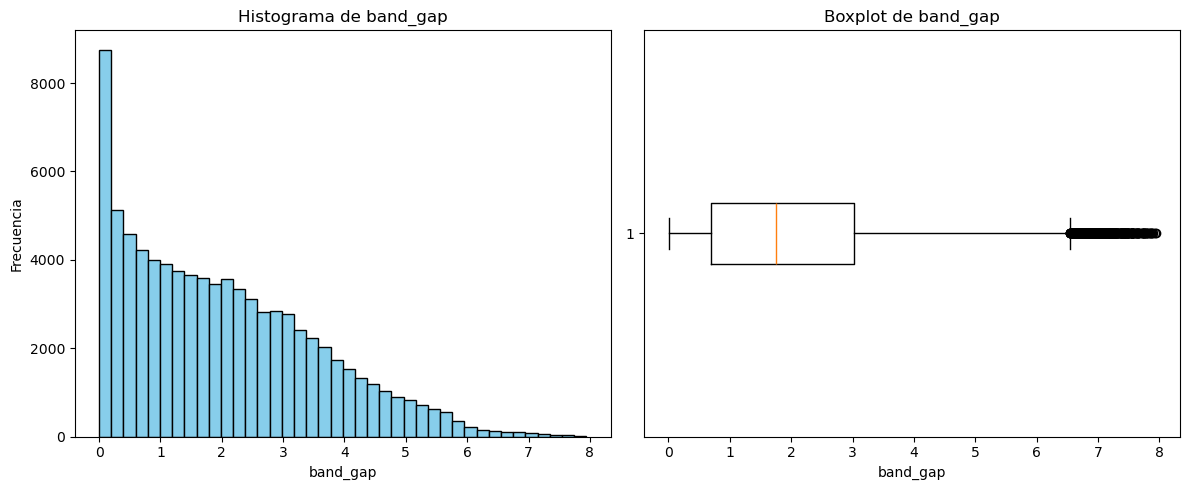

In [ ]:
import matplotlib.pyplot as plt

# Histograma de y_data_band_gap
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(y_data_band_gap.dropna(), bins=40, color='skyblue', edgecolor='k')
plt.title("Histograma de band_gap")
plt.xlabel("band_gap")
plt.ylabel("Frecuencia")

# Boxplot de y_data_band_gap
plt.subplot(1, 2, 2)
plt.boxplot(y_data_band_gap.dropna(), vert=False)
plt.title("Boxplot de band_gap")
plt.xlabel("band_gap")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Calcula el histograma de y_data_band_gap en 20 bins y el porcentaje de datos en cada bin

# Usamos 20 bins entre el mínimo y el máximo de band_gap
n_bins = 20
counts, bin_edges = np.histogram(y_data_band_gap.dropna(), bins=n_bins)
total = counts.sum()
pct_per_bin = counts / total * 100

# Creamos un DataFrame para mostrar los resultados
bins_labels = [f"{bin_edges[i]:.2f}–{bin_edges[i+1]:.2f}" for i in range(n_bins)]
hist_df = pd.DataFrame({
    "bin": bins_labels,
    "count": counts,
    "pct": pct_per_bin
})

print(hist_df)

          bin  count        pct
0   0.00–0.40  13875  16.929403
1   0.40–0.79   8824  10.766490
2   0.79–1.19   7917   9.659826
3   1.19–1.59   7403   9.032675
4   1.59–1.99   7064   8.619049
5   1.99–2.38   6917   8.439689
6   2.38–2.78   5937   7.243954
7   2.78–3.18   5602   6.835208
8   3.18–3.57   4643   5.665097
9   3.57–3.97   3761   4.588936
10  3.97–4.37   2851   3.478611
11  4.37–4.76   2230   2.720906
12  4.76–5.16   1725   2.104737
13  5.16–5.56   1337   1.631323
14  5.56–5.96    920   1.122526
15  5.96–6.35    358   0.436809
16  6.35–6.75    234   0.285512
17  6.75–7.15    207   0.252568
18  7.15–7.54    108   0.131775
19  7.54–7.94     45   0.054906


R2 ajuste lineal: 0.9038
R2 ajuste polinómico (grado 2): 0.9545


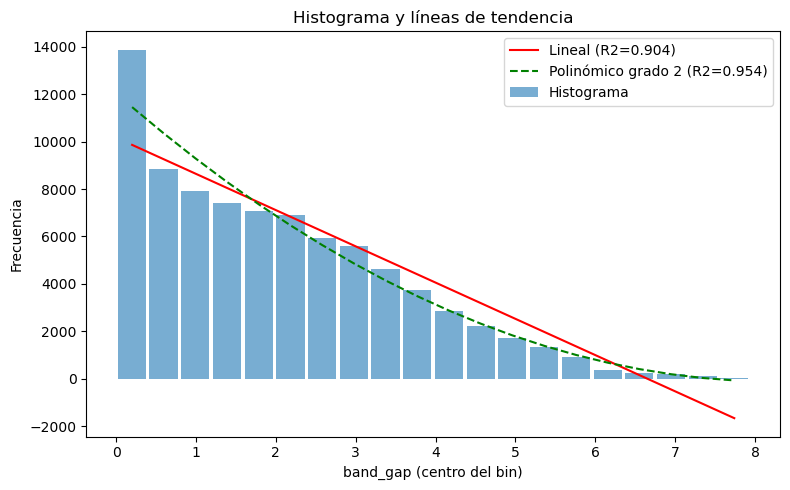

La línea de tendencia que mejor se ajusta es un polinomio de grado 2.


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt

# Usamos los datos del histograma anterior: hist_df (bins, count)
# Tomamos el centro de cada bin como x, y el count como y
bin_centers = np.array([(float(b.split('–')[0]) + float(b.split('–')[1])) / 2 for b in hist_df['bin']])
counts = hist_df['count'].values

# Ajuste lineal
linreg = LinearRegression()
bin_centers_reshape = bin_centers.reshape(-1, 1)
linreg.fit(bin_centers_reshape, counts)
y_pred_lin = linreg.predict(bin_centers_reshape)

# Ajuste polinómico (grado 2, por si mejora el ajuste)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(bin_centers_reshape)
linreg_poly = LinearRegression()
linreg_poly.fit(X_poly, counts)
y_pred_poly = linreg_poly.predict(X_poly)

# R2 para ambos
r2_lin = linreg.score(bin_centers_reshape, counts)
r2_poly = linreg_poly.score(X_poly, counts)

print(f"R2 ajuste lineal: {r2_lin:.4f}")
print(f"R2 ajuste polinómico (grado 2): {r2_poly:.4f}")

# Gráfico
plt.figure(figsize=(8,5))
plt.bar(bin_centers, counts, width=(bin_centers[1]-bin_centers[0])*0.9, alpha=0.6, label="Histograma")
plt.plot(bin_centers, y_pred_lin, 'r-', label=f"Lineal (R2={r2_lin:.3f})")
plt.plot(bin_centers, y_pred_poly, 'g--', label=f"Polinómico grado 2 (R2={r2_poly:.3f})")
plt.xlabel("band_gap (centro del bin)")
plt.ylabel("Frecuencia")
plt.title("Histograma y líneas de tendencia")
plt.legend()
plt.tight_layout()
plt.show()

# Mejor ajuste
if r2_poly > r2_lin:
    print("La línea de tendencia que mejor se ajusta es un polinomio de grado 2.")
else:
    print("La línea de tendencia que mejor se ajusta es una recta (ajuste lineal).")

Parámetros ajuste exponencial negativa: a=15056.74, b=0.2429, c=-2570.47
R2 ajuste exponencial negativa: 0.9561


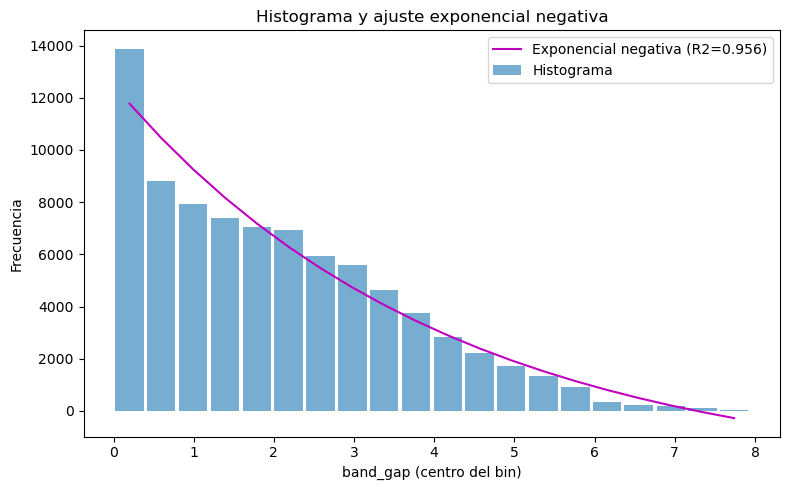

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

# Usamos los datos del histograma anterior: hist_df (bins, count)
bin_centers = np.array([(float(b.split('–')[0]) + float(b.split('–')[1])) / 2 for b in hist_df['bin']])
counts = hist_df['count'].values

# Definir función exponencial negativa: y = a * exp(-b * x) + c
def neg_exp(x, a, b, c):
    return a * np.exp(-b * x) + c

# Ajuste
popt, pcov = curve_fit(neg_exp, bin_centers, counts, p0=(counts.max(), 1.0, 0.0))
y_pred_exp = neg_exp(bin_centers, *popt)

# R2 score
ss_res = np.sum((counts - y_pred_exp) ** 2)
ss_tot = np.sum((counts - np.mean(counts)) ** 2)
r2_exp = 1 - ss_res / ss_tot

print(f"Parámetros ajuste exponencial negativa: a={popt[0]:.2f}, b={popt[1]:.4f}, c={popt[2]:.2f}")
print(f"R2 ajuste exponencial negativa: {r2_exp:.4f}")

# Gráfico
plt.figure(figsize=(8,5))
plt.bar(bin_centers, counts, width=(bin_centers[1]-bin_centers[0])*0.9, alpha=0.6, label="Histograma")
plt.plot(bin_centers, y_pred_exp, 'm-', label=f"Exponencial negativa (R2={r2_exp:.3f})")
plt.xlabel("band_gap (centro del bin)")
plt.ylabel("Frecuencia")
plt.title("Histograma y ajuste exponencial negativa")
plt.legend()
plt.tight_layout()
plt.show()

In [683]:
# ================== CONFIG ==================
RANDOM_STATE = 42
USE_TAIL_WEIGHTS = True   # refuerzo ligero a la cola (gaps altos)
ALPHA_TAIL = 0.25         # intensidad del refuerzo

# ================== IMPORTS ==================
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# ===== helpers =====
def report(y_true, y_pred, tag=""):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{tag} -> RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    return rmse

def log1p_tf(y):  return np.log1p(np.clip(y, 0, None))
def inv_log1p(z): return np.expm1(z)

# ===== split holdout =====
X_tr, X_val, y_tr, y_val = train_test_split(
    x_trainBN, y_trainBN, test_size=0.20, random_state=RANDOM_STATE
)

# ===== (opcional) pesos para cola =====
if USE_TAIL_WEIGHTS:
    y_std = (y_tr - y_tr.min()) / max(1e-9, (y_tr.max() - y_tr.min()))
    w_tr = np.exp(ALPHA_TAIL * y_std)   # mayor peso a gaps altos
else:
    w_tr = None

candidatos = []

# ----------------- 1) LightGBM con objetivo Gamma (sin ES) -----------------
lgb_gamma = LGBMRegressor(
    objective="gamma",
    n_estimators=2000,          # sin early stopping, fija nº de árboles
    learning_rate=0.03,
    num_leaves=64,
    min_child_samples=40,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=-1,
)
lgb_gamma.fit(X_tr, y_tr, sample_weight=w_tr)  # <-- sin eval_set ni callbacks
pred_val = lgb_gamma.predict(X_val)
rmse = report(y_val, pred_val, "VAL • LGBM(gamma)")
candidatos.append(("LGBM(gamma)", rmse, lgb_gamma))

# ----------------- 2) XGBoost con objetivo Gamma (sin ES) -----------------
xgb_gamma = XGBRegressor(
    objective="reg:gamma",
    n_estimators=2500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=6,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="gpu_hist",     # usa "hist" si no tienes GPU
    predictor="gpu_predictor",  # o "auto"
)
xgb_gamma.fit(X_tr, y_tr, sample_weight=w_tr)   # <-- sin eval_set, sin ES
pred_val = xgb_gamma.predict(X_val)
rmse = report(y_val, pred_val, "VAL • XGB(reg:gamma)")
candidatos.append(("XGB(reg:gamma)", rmse, xgb_gamma))

# ----------------- 3) LGBM con log1p(target) + Huber (sin ES) -----------------
y_tr_log  = log1p_tf(y_tr)
y_val_log = log1p_tf(y_val)

lgb_huber_log = LGBMRegressor(
    objective="huber",
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=64,
    min_child_samples=40,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=-1,
    alpha=0.9,     # parámetro de Huber (ajustable)
)
lgb_huber_log.fit(X_tr, y_tr_log, sample_weight=w_tr)  # <-- sin ES
pred_val_log = lgb_huber_log.predict(X_val)
pred_val = inv_log1p(pred_val_log)
rmse = report(y_val, pred_val, "VAL • LGBM(log1p+y, huber)")
candidatos.append(("LGBM(log1p+huber)", rmse, lgb_huber_log, "LOG1P"))

# ===== elige el mejor por RMSE y evalúa en TEST =====
candidatos.sort(key=lambda t: t[1])
ganador = candidatos[0]
nombre_mejor, rmse_best, modelo_best_R = ganador[0], ganador[1], ganador[2]
usa_log1p = (len(ganador) == 4)

print(f"\n>> Mejor en VALIDACIÓN: {nombre_mejor} (RMSE={rmse_best:.4f})")

if 'x_testBN' in globals() and 'y_testBN' in globals():
    if usa_log1p:
        y_hat = inv_log1p(modelo_best_R.predict(x_testBN))
    else:
        y_hat = modelo_best_R.predict(x_testBN)
    report(y_testBN, y_hat, f"TEST • {nombre_mejor}")


VAL • LGBM(gamma) -> RMSE: 1.0635 | MAE: 0.7749 | R2: 0.5273


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tr

VAL • XGB(reg:gamma) -> RMSE: 1.0915 | MAE: 0.8002 | R2: 0.5021
VAL • LGBM(log1p+y, huber) -> RMSE: 0.9796 | MAE: 0.7197 | R2: 0.5989

>> Mejor en VALIDACIÓN: LGBM(log1p+huber) (RMSE=0.9796)
TEST • LGBM(log1p+huber) -> RMSE: 0.9751 | MAE: 0.7179 | R2: 0.6044


In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ==== split holdout para calibrar ====
X_tr, X_val, y_tr, y_val = train_test_split(
    x_trainBN, y_trainBN, test_size=0.2, random_state=42
)

def report(y_true, y_pred, tag):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{tag} -> RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    return rmse, mae, r2

# ==== 1) XGB con TUS mejores hiperparámetros (squarederror) ====
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1339, max_depth=7, learning_rate=0.028471792300060264,
    subsample=0.7421018791191738, colsample_bytree=0.8257342957948911,
    min_child_weight=7, reg_alpha=0.006271789487853164, reg_lambda=1.1817135914056782,
    random_state=42, n_jobs=-1, tree_method="gpu_hist", predictor="gpu_predictor"
)
xgb.fit(X_tr, y_tr)
p_val_xgb  = xgb.predict(X_val)
p_test_xgb = xgb.predict(x_testBN)
report(y_val, p_val_xgb,  "VAL  XGB")
report(y_testBN, p_test_xgb, "TEST XGB")

# ==== 2) LGBM con MAE (l1) para complementar ====
lgb = LGBMRegressor(
    objective="l1",               # MAE
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=64,
    min_child_samples=40,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, n_jobs=-1, verbosity=-1
)
lgb.fit(X_tr, y_tr)
p_val_lgb  = lgb.predict(X_val)
p_test_lgb = lgb.predict(x_testBN)
report(y_val, p_val_lgb,  "VAL  LGB(l1)")
report(y_testBN, p_test_lgb, "TEST LGB(l1)")

# ==== 3) Blend simple (ajusta el peso si quieres) ====
w = 0.6  # peso del XGB
p_val_blend  = w*p_val_xgb  + (1-w)*p_val_lgb
p_test_blend = w*p_test_xgb + (1-w)*p_test_lgb
report(y_val, p_val_blend,  f"VAL  Blend (w={w:.1f})")
report(y_testBN, p_test_blend, f"TEST Blend (w={w:.1f})")

# ==== 4) Calibración isotónica sobre la validación ====
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(p_val_blend, y_val)                 # mapea pred -> real
p_test_blend_cal = iso.transform(p_test_blend)
report(y_testBN, p_test_blend_cal, "TEST Blend + Isotonic")


c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\sevas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tr

VAL  XGB -> RMSE: 0.9373 | MAE: 0.6888 | R2: 0.6328
TEST XGB -> RMSE: 0.9266 | MAE: 0.6874 | R2: 0.6427
VAL  LGB(l1) -> RMSE: 0.9544 | MAE: 0.6976 | R2: 0.6193
TEST LGB(l1) -> RMSE: 0.9454 | MAE: 0.6936 | R2: 0.6281
VAL  Blend (w=0.6) -> RMSE: 0.9330 | MAE: 0.6840 | R2: 0.6362
TEST Blend (w=0.6) -> RMSE: 0.9230 | MAE: 0.6824 | R2: 0.6455
TEST Blend + Isotonic -> RMSE: 0.9300 | MAE: 0.6907 | R2: 0.6401


(0.930031579773034, 0.6907372384798416, 0.6400876978511988)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV, HuberRegressor

def eval_pred(y_true, y_pred, tag):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{tag} -> RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    return rmse, mae, r2

# ========= 1) Barrido de pesos del blend =========
ws = np.linspace(0.3, 0.85, 23)  # XGB weight; ajusta rango si quieres
val_rmse = []
for w in ws:
    p_val_blend = w*p_val_xgb + (1-w)*p_val_lgb
    rmse = mean_squared_error(y_val, p_val_blend, squared=False)
    val_rmse.append(rmse)

best_w = ws[int(np.argmin(val_rmse))]
print("\n>> Mejor w en VALIDACIÓN:", round(best_w, 3), "| RMSE(val):", round(min(val_rmse), 4))

p_test_best = best_w*p_test_xgb + (1-best_w)*p_test_lgb
eval_pred(y_testBN, p_test_best, f"TEST Blend (w={best_w:.3f})")

# ========= 2) Stacking (meta-regresor RidgeCV) =========
X_meta_val  = np.c_[p_val_xgb,  p_val_lgb]
X_meta_test = np.c_[p_test_xgb, p_test_lgb]

meta = RidgeCV(alphas=np.logspace(-4, 4, 41), fit_intercept=True)
meta.fit(X_meta_val, y_val)

p_test_stack = meta.predict(X_meta_test)
eval_pred(y_testBN, p_test_stack, "TEST Stacking (RidgeCV)")

print("Pesos meta (Ridge):", meta.coef_, "| bias:", meta.intercept_)

# ========= 3) Corrección robusta 1D sobre el mejor blend =========
p_val_best = best_w*p_val_xgb + (1-best_w)*p_val_lgb
hub = HuberRegressor().fit(p_val_best.reshape(-1,1), y_val)
p_test_best_huber = hub.predict(p_test_best.reshape(-1,1))
eval_pred(y_testBN, p_test_best_huber, "TEST Blend (w*) + Huber")
print("Huber: y =", round(hub.intercept_,4), "+", round(hub.coef_[0],4), "* y_pred")



>> Mejor w en VALIDACIÓN: 0.675 | RMSE(val): 0.9326
TEST Blend (w=0.675) -> RMSE: 0.9226 | MAE: 0.6825 | R2: 0.6458
TEST Stacking (RidgeCV) -> RMSE: 0.9232 | MAE: 0.6841 | R2: 0.6453
Pesos meta (Ridge): [0.62920909 0.35881047] | bias: 0.027548784943458582
TEST Blend (w*) + Huber -> RMSE: 0.9226 | MAE: 0.6790 | R2: 0.6458
Huber: y = -0.0614 + 1.0384 * y_pred


TEST • LGBM(log1p+huber) -> RMSE: 0.9751 | MAE: 0.7179 | R2: 0.6044


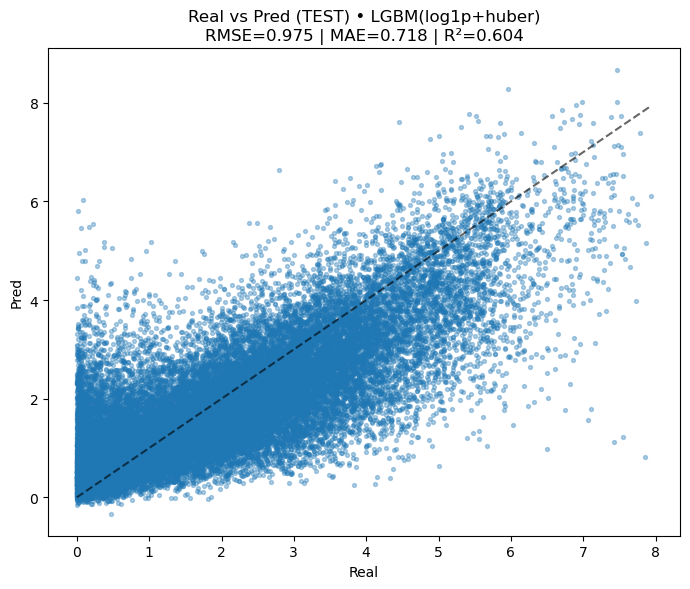

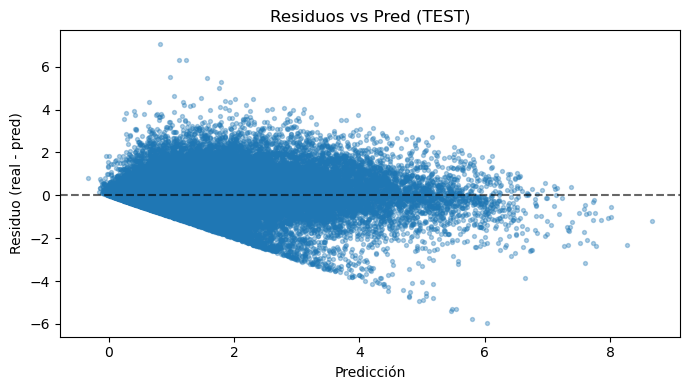

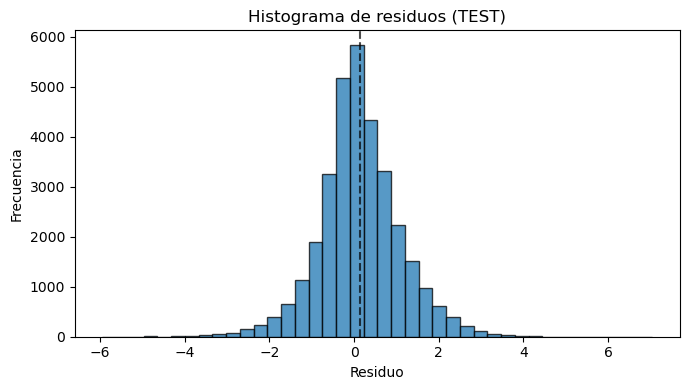


== Sesgo por deciles (TEST) ==
                   n  avg_real  avg_pred      bias
bin                                               
(0.0, 0.181]    3279  0.075725  0.838882  0.763157
(0.181, 0.499]  3278  0.329477  0.921105  0.591628
(0.499, 0.877]  3278  0.681603  1.033961  0.352359
(0.877, 1.295]  3279  1.080623  1.194825  0.114202
(1.295, 1.747]  3278  1.519910  1.421286 -0.098624
(1.747, 2.221]  3278  1.984048  1.771332 -0.212716
(2.221, 2.734]  3279  2.467913  2.095314 -0.372599
(2.734, 3.336]  3278  3.024953  2.422594 -0.602359
(3.336, 4.2]    3278  3.731650  2.954622 -0.777028
(4.2, 7.94]     3279  5.119502  4.064331 -1.055171


In [700]:
# ====== Evaluación en TEST40 con gráficas y tabla de sesgo ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- helpers (por si no están definidos arriba) ---
def inv_log1p(z): 
    return np.expm1(z)

def report(y_true, y_pred, tag=""):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{tag} -> RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    return rmse, mae, r2

# --- 1) Predicción en TEST ---
if 'x_testBN' not in globals() or 'y_testBN' not in globals():
    raise RuntimeError("Faltan x_testBN / y_testBN en memoria.")

if 'modelo_best' not in globals() or 'nombre_mejor' not in globals():
    raise RuntimeError("Faltan modelo_best / nombre_mejor (ejecuta antes la selección de modelo).")

y_pred = modelo_best_R.predict(x_testBN)
if 'usa_log1p' in globals() and usa_log1p:
    y_pred = inv_log1p(y_pred)

rmse, mae, r2 = report(y_testBN, y_pred, f"TEST • {nombre_mejor}")

# --- 2) Gráficas: Real vs Pred y Residuos ---
res = y_testBN - y_pred

plt.figure(figsize=(7,6))
plt.scatter(y_testBN, y_pred, s=8, alpha=0.35)
mn, mx = float(np.min(y_testBN)), float(np.max(y_testBN))
plt.plot([mn, mx], [mn, mx], 'k--', alpha=0.6)
plt.xlabel("Real")
plt.ylabel("Pred")
plt.title(f"Real vs Pred (TEST) • {nombre_mejor}\nRMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.scatter(y_pred , res, s=8, alpha=0.35)
plt.axhline(0, color='k', linestyle='--', alpha=0.6)
plt.xlabel("Predicción")
plt.ylabel("Residuo (real - pred)")
plt.title("Residuos vs Pred (TEST)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.hist(res, bins=40, edgecolor='k', alpha=0.75)
plt.axvline(np.mean(res), color='k', linestyle='--', alpha=0.7)
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuos (TEST)")
plt.tight_layout()
plt.show()

# --- 3) Sesgo por deciles (en y real) ---
df = pd.DataFrame({"y": y_testBN, "yhat": y_pred})
df["bin"] = pd.qcut(df["y"], q=10, duplicates="drop")
tab = (df.groupby("bin", observed=True)
         .agg(n=("y", "size"),
              avg_real=("y", "mean"),
              avg_pred=("yhat", "mean"))
         .assign(bias=lambda d: d["avg_pred"] - d["avg_real"]))

print("\n== Sesgo por deciles (TEST) ==")
print(tab)



== Top 15 variables por importancia ==
formation_energy_per_atom    13073
energy_above_hull            12458
volume_per_atom              11984
density                      11776
volume                       10428
avg_electronegativity        10189
avg_atomic_mass               9840
avg_atomic_radius             8970
range_atomic_mass             7288
spacegroup_number             7143
max_atomic_mass               6515
nsites                        6092
electronegativity_range       5685
min_atomic_mass               2042
n_elements                    1346


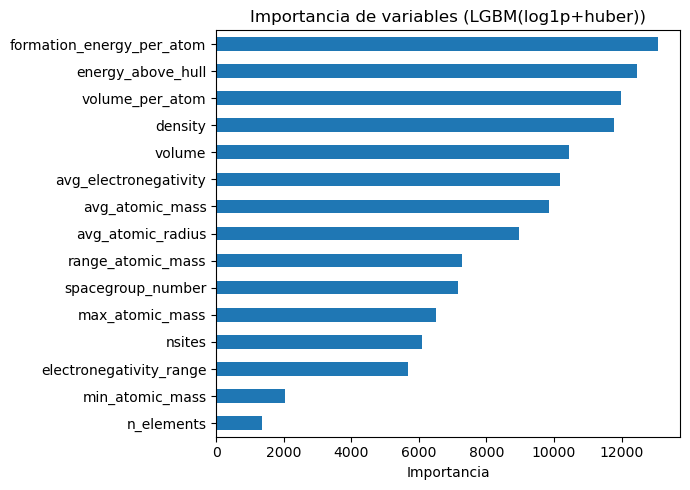

In [686]:
# Importancias de modelo_best_R (alineadas con X_tr)
importances = modelo_best_R.feature_importances_
cols = X_tr.columns if len(importances) == X_tr.shape[1] else [f"f{i}" for i in range(len(importances))]

feat_imp = pd.Series(importances, index=cols).sort_values(ascending=False)

print("\n== Top 15 variables por importancia ==")
print(feat_imp.head(15).to_string())

# Gráfico (top-15)
feat_imp.head(15).plot(kind="barh", figsize=(7,5))
plt.gca().invert_yaxis()
plt.title(f"Importancia de variables ({nombre_mejor})")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

Top-3 variables por importancia: ['formation_energy_per_atom', 'energy_above_hull', 'volume_per_atom']


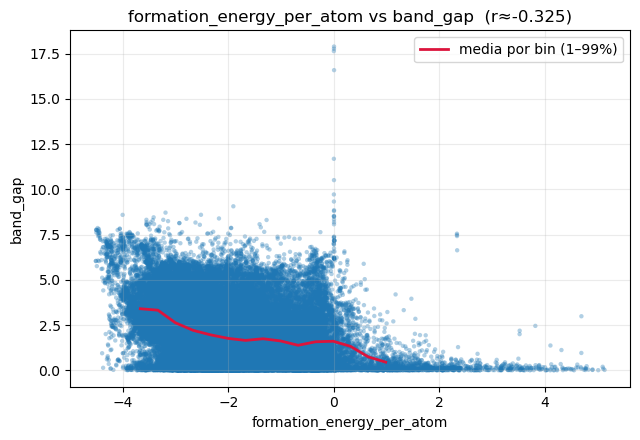

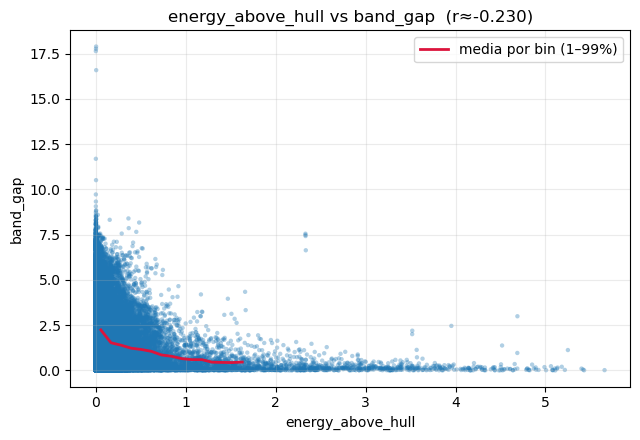

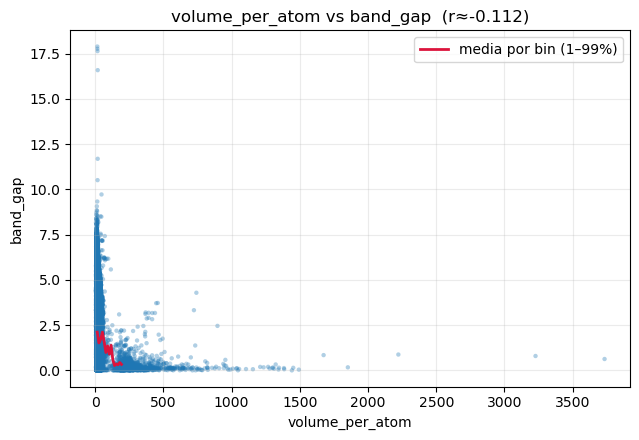

In [687]:
# Top-3 features por importancia y 3 gráficos vs band_gap

# 1) Detecta feat_imp (o lo calcula desde el último modelo de regresión si no existe)
try:
    feat_imp  # serie ya existente
except NameError:
    # fallback: importancias del mejor modelo de regresión (modelo_best_R) con columnas X_tr
    importances = modelo_best_R.feature_importances_
    cols = X_tr.columns if len(importances) == X_tr.shape[1] else [f"f{i}" for i in range(len(importances))]
    feat_imp = pd.Series(importances, index=cols).sort_values(ascending=False)

top3 = list(feat_imp.head(3).index)
print("Top-3 variables por importancia:", top3)

# 2) Graficar cada feature vs band_gap
for col in top3:
    # dataset alineado y limpio
    df_plot = pd.DataFrame({
        col: X_data[col],
        "band_gap": y_data_band_gap
    }).replace([np.inf, -np.inf], np.nan).dropna()

    x = df_plot[col].values
    y = df_plot["band_gap"].values

    # correlación de referencia
    r = np.corrcoef(x, y)[0, 1] if len(df_plot) > 1 else np.nan

    # bins para tendencia (recorte 1–99%)
    x_lo, x_hi = df_plot[col].quantile([0.01, 0.99]).values
    edges = np.linspace(x_lo, x_hi, 16)
    bins = pd.cut(df_plot[col], edges, include_lowest=True)
    gb = df_plot.groupby(bins, observed=True)["band_gap"].agg(["mean", "size"])
    centers = [iv.mid for iv in gb.index]

    # figura
    plt.figure(figsize=(6.5, 4.5))
    plt.scatter(df_plot[col], df_plot["band_gap"], s=10, alpha=0.35, edgecolor="none")
    # tendencia por bins
    if len(gb) > 1:
        plt.plot(centers, gb["mean"].values, color="crimson", lw=2, label="media por bin (1–99%)")

    plt.xlabel(col)
    plt.ylabel("band_gap")
    plt.title(f"{col} vs band_gap  (r≈{r:.3f})")
    if len(gb) > 1:
        plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()